### Pseudo Code

1. Use S&P 100 Tickers for anlyzing the tool
2. Use Treasury Bond Rates for measuring Sharpe ratio
3. Use SMP100 index Rates for input in Blacklitterman model for market price
4. Download the historical rates from yahoo finance and merge them to get all common rows
5. For each ticker in S&P tickers
   1. Evaluate a mean of each stock for a rolling window of 20
   2. RSI Evaluation
      1. Evaluate RSI for a rolling window of 20
      2. Find the percentile of the RSI obatined in the last step for a rolling window of 20 (Percentile evaluation is important else it will miss the position)
      3. Create a zscore using the modified error function
     
   3. Stochastic Evaluation
      1. Evaluate Stochastic %K on a period of 20 window
      2. Evaluate %D on %K on a SMA of 3-period
      3. Find the percentile of the stochastic %D from the last 20 window size
      4. Create a zscore using the modified error function
     
   4. Bollingier Evaluation
      1. lambda is evaluated using the formula: (closing price - SMA of price for last 20 period)/(standard deviation of price on last 20 period)
      2. Find the percentile of the lambda from the last 20 window size
      3. Create a zscore using the modified error function
     
   5. Find the mean of zscore from RSI, zscore from Stochastic and zscore of lambda (This mean zscore will contain the combined signal information of all the technical indicators)
   6. Find the sharpe ratio, normalize in the range of 0 to 100 and generate zscore from the modified error function.(generating an equivalent zscore is important to keep the units of all the metrics in same range.)
   7. Find the slope for the last week to exclude any wrong signal or noise.
   8. Find view and expected interval for each stock for BlackLitterman model
      1. Find expected upward movement i.e distance of price from the (sma_20 + 2*sigma)
      2. Find expected downward movement i.e distance of price from the (sma_20 - 2*sigma)
      3. From the expected upward and downward movement, evaluate the upward and downward interval.
     
   9. Create six sets based on zscore of technical, sharpe ratio and performance rank.(Our interest is on 3 buying recommendation sets)
       1. set 1 - buy recommendation using technical indicators; sort stocks based on zscore of technical indicators and pick the top quartile.
       2. set 2 - buy recommendation using sharpe ratio; sort stocks based on zscore of sharpe ratio and pick the top quartile.
       3. set 3 - buy recommendation using performance rank; sort stocks based on zscore of performance rank and pick the top quartile.
     
   10. Using the three above sets 1,2,3
       1. Create a set from the intersection of all the 3 sets (This is the best recommendation as all the indicators have performed good)
       2. If the above set is not sufficient, append stocks from the intersection of sets of sharpe ratio and technical indicators.
       3. If the above set is not sufficient, append stocks from the intersection of sets of sharpe ratio and performance rank.
       4. If the above set is not sufficent, append stocks from the sharpe ratio set
      
   11. Create a column with random selection of `n` stocks from the tickers.
   12. Perform asset allocation using BL model for our recommended stocks
   13. Perform asset allocation using BL model for our random stocks.
  
6. On performing above steps, we will get a dataframe with all the metrics required to perform different strategies and generating reports

#### Import Libraries

In [481]:
import os, sys
import yfinance as yf
# import ta
import pandas as pd
import numpy as np
import vectorbt as vbt
from datetime import date, timedelta, datetime
from itertools import product
from IPython.display import clear_output
import matplotlib.pyplot as plt
from csv import writer
import warnings
import talib as ta
import math
import re
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

In [482]:
def print_exception_detail(err, *args, **kwargs):
    exc_type, exc_obj, exc_tb = sys.exc_info()
    if len(args):
        for _arg in args:
            print(_arg)
    print(f"Error Message: {err}")
    print(f"Error at line number: {exc_tb.tb_lineno}")

#### Tickers of S&P100 and Treasury Bond Rates of 1day frequency

In [483]:
# treasury_bond = ["^TYX"]
# smp100 = ["^OEX"]
# ticker = ["NVDA","AAPL","MSFT","AMZN","GOOGL","GOOG","META","TSLA","AVGO","COST","NFLX","ASML","TMUS","AMD","CSCO","PEP","ADBE","LIN","AZN","TXN","QCOM	","INTU","ISRG","AMGN	","CMCSA","PDD","BKNG","AMAT","ARM","HON","VRTX","PANW","ADP","MU","GILD","ADI","SBUX","MELI","INTC","LRCX","KLAC","MDLZ","ABNB","REGN","CTAS","SNPS","CDNS","PYPL","CRWD","MRVL","MAR","CEG","CSX","ORLY","DASH","WDAY","CHTR","ADSK","FTNT","TTD","ROP","PCAR","NXPI","TEAM","FANG","MNST","CPRT","PAYX","AEP","ODFL","ROST","FAST","KDP","DDOG","EA","BKR","KHC","MCHP","VRSK","GEHC","CTSH","LULU","EXC","XEL","CCEP","IDXX","ON","CSGP","ZS","TTWO","ANSS","CDW","DXCM","BIIB","GFS","ILMN","MDB","WBD","MRNA","DLTR","WBA"]
# ticker = [_t.strip() for _t in ticker if _t.strip() not in ["ARM","ABNB","CEG","DASH","GEHC","GFS"]]

##### Methods to download data

In [484]:
# def download_data(ticker, interval='1d'):

#     end_date = datetime.now() #- timedelta(days=30)
#     start_date = end_date - timedelta(days=1855)

#     # extract data from yahoo finanace\
#     btc_price = vbt.YFData.download(
#     ticker,
#     interval=interval,
#     start = start_date,
#     end = end_date,
#     missing_index='drop').get("Close")
#     df = pd.DataFrame(btc_price)
#     df.rename(columns={"Close":ticker}, inplace=True)
#     df.head()
#     df.index=df.index.strftime("%Y-%m-%d")
#     df.index = pd.to_datetime(df.index)
#     return df

In [485]:
# df = pd.DataFrame()
# for _t in ticker:
#     try:
#         if df.empty:
#             df=download_data(_t)
#         else:
#             df1 = pd.DataFrame()
#             df1 = download_data(_t)
#             df = pd.merge(df, df1, left_index=True, right_index=True, how='inner')  # Only keep matching rows
#     except Exception as err:
#         print_exception_detail(err)

In [486]:
# Check columns with nan
# df.isna().sum()[df.isna().sum() >0]

In [487]:
import pandas as pd
import vectorbt as vbt
from datetime import datetime, timedelta
import sys
from pandas.tseries.offsets import BDay

class SNP100DataLoader:
  """Data loader for S&P 100 stocks"""
  
  DEFAULT_TICKERS = [
      "NVDA", "AAPL", "MSFT", "AMZN", "GOOGL", "GOOG", "META", "TSLA", "AVGO", 
      "COST", "NFLX", "ASML", "TMUS", "AMD", "CSCO", "PEP", "ADBE", "LIN", 
      "AZN", "TXN", "QCOM", "INTU", "ISRG", "AMGN", "CMCSA", "PDD", "BKNG", 
      "AMAT", "HON", "VRTX", "PANW", "ADP", "MU", "GILD", "ADI", "SBUX", 
      "MELI", "INTC", "LRCX", "KLAC", "MDLZ", "REGN", "CTAS", "SNPS", "CDNS", 
      "PYPL", "CRWD", "MRVL", "MAR", "CSX", "ORLY", "WDAY", "CHTR", "ADSK", 
      "FTNT", "TTD", "ROP", "PCAR", "NXPI", "TEAM", "FANG", "MNST", "CPRT", 
      "PAYX", "AEP", "ODFL", "ROST", "FAST", "KDP", "DDOG", "EA", "BKR", 
      "KHC", "MCHP", "VRSK", "CTSH", "LULU", "EXC", "XEL", "CCEP", "IDXX", 
      "ON", "CSGP", "ZS", "TTWO", "ANSS", "CDW", "DXCM", "BIIB", "ILMN", 
      "MDB", "WBD", "MRNA", "DLTR", "WBA"
  ]

  EXCLUDED_TICKERS = ["ARM", "ABNB", "CEG", "DASH", "GEHC", "GFS"]
  
  TREASURY_BOND = "^TYX"
  SP100_INDEX = "^OEX"
  END_DATE = pd.Timestamp('2024-11-16')

  def __init__(self):
      """Initialize the data loader"""
      self.tickers = [t.strip() for t in self.DEFAULT_TICKERS 
                     if t.strip() not in self.EXCLUDED_TICKERS]

  def get_start_date(self, start_input):
      """
      Get start date based on input type
      
      Parameters:
      -----------
      start_input : str, datetime, or int
          Can be:
          - datetime string ('2020-01-01')
          - datetime object
          - integer (number of days to look back from end date)
          
      Returns:
      --------
      datetime
          Calculated start date
      """
      if isinstance(start_input, (str, pd.Timestamp, datetime)):
          return pd.Timestamp(start_input)
      elif isinstance(start_input, int):
          return self.END_DATE - BDay(start_input)
      else:
          raise ValueError("start_input must be date string, datetime, or integer days")

  def download_single_ticker(self, ticker, start_date, interval='1d'):
      """Download data for a single ticker"""
      try:
          price_data = vbt.YFData.download(
              ticker,
              interval=interval,
              start=start_date,
              end=self.END_DATE,
              missing_index='drop'
          ).get("Close")

          df = pd.DataFrame(price_data)
          df.rename(columns={"Close": ticker}, inplace=True)
          df.index = pd.to_datetime(df.index.strftime("%Y-%m-%d"))
          return df

      except Exception as err:
          self.print_exception_detail(err, f"Error downloading {ticker}")
          return None

  def load_all_data(self, start_date, include_indices=True):
      """
      Load data for all stocks and indices
      
      Parameters:
      -----------
      start_date : datetime
          Start date for data download
      include_indices : bool
          Whether to include treasury bond and S&P 100 index
          
      Returns:
      --------
      pd.DataFrame
          DataFrame with closing prices for all securities
      """
      # Start with stock tickers
      df = pd.DataFrame()
      
      # Download stock data
      for ticker in self.tickers:
          try:
              if df.empty:
                  df = self.download_single_ticker(ticker, start_date)
              else:
                  ticker_data = self.download_single_ticker(ticker, start_date)
                  if ticker_data is not None:
                      df = df.join(ticker_data, how='outer')
          except Exception as err:
              self.print_exception_detail(err)

      if include_indices:
          # Download and merge Treasury Bond data
          treasury_data = self.download_single_ticker(self.TREASURY_BOND, start_date)
          if treasury_data is not None:
              df = df.join(treasury_data, how='inner')
              # Calculate 20-day percentage change for treasury
              df[f"{self.TREASURY_BOND}_pct_change_20"] = df[self.TREASURY_BOND].pct_change(20)

          # Download and merge S&P 100 data
          sp100_data = self.download_single_ticker(self.SP100_INDEX, start_date)
          if sp100_data is not None:
              df = df.join(sp100_data, how='inner')

      return df.sort_index()

  def get_data(self, start_input, include_indices=True):
      """
      Get data for specified date range
      
      Parameters:
      -----------
      start_input : str, datetime, or int
          Start date specification:
          - date string ('2020-01-01')
          - datetime object
          - number of trading days to look back from end date
      include_indices : bool
          Whether to include treasury bond and S&P 100 index data
          
      Returns:
      --------
      pd.DataFrame
          DataFrame with closing prices for specified date range
      """
      start_date = self.get_start_date(start_input)
      return self.load_all_data(start_date, include_indices)

  @staticmethod
  def print_exception_detail(err, *args):
      """Print detailed error information"""
      exc_type, exc_obj, exc_tb = sys.exc_info()
      if len(args):
          for _arg in args:
              print(_arg)
      print(f"Error Message: {err}")
      print(f"Error at line number: {exc_tb.tb_lineno}")

if __name__ == "__main__":
  
  
# Initialize the loader
    loader = SNP100DataLoader()

    # Get data using different start date specifications:

    # 1. Using date string
    # df = loader.get_data('2020-01-01')

    # 2. Using number of trading days
    df1 = loader.get_data(1298, include_indices=False)  # Last trading days from Nov 14, 2023

    # 3. Without indices if needed
    # df = loader.get_data('2019-01-01', include_indices=False)

    # print(f"Date range: {df.index.min()} to {df.index.max()}")
    # print(f"Columns included: {df.columns.tolist()}")

  
    print("\nData Summary:")
    print(f"Start Date: {df1.index.min()}")
    print(f"End Date: {df1.index.max()}")
    print(f"Number of trading days: {len(df1)}")
    print(f"Number of columns: {len(df1.columns)}")
    
    # Check if indices are present
    if '^TYX' in df1.columns:
        print("\nTreasury bond data included")
        print("20-day percentage change column present:", 
                f"{'^TYX_pct_change_20' in df1.columns}")
    
    if '^OEX' in df1.columns:
        print("S&P 100 index data included")


Data Summary:
Start Date: 2019-11-26 00:00:00
End Date: 2024-11-15 00:00:00
Number of trading days: 1252
Number of columns: 95


In [488]:
df1.shape

(1252, 95)

In [489]:
df = df1.copy()

In [490]:
# # Treasury bill data downloaded and percentage change on a window of 20
df_treasury = download_data(treasury_bond[0])

# # SMP 100 data download
df_smp100 = download_data(smp100[0])

In [491]:
# # # Merge ticker price with treasury bill and smp100 

df = pd.merge(df, df_treasury, left_index=True, right_index=True, how="inner")
df = pd.merge(df, df_smp100, left_index=True, right_index=True, how="inner")

In [492]:
df.shape

(1252, 97)

##### Percentile Method

$
 \frac{rank of an element}{total number of element}\,* 100 
$

In [493]:
def percentile(window):
    index = window.index[-1]
    window = window.rank(method="min", ascending=True).apply(lambda x: (x/20)*100)
    return window.loc[index]

### Indicator

##### There are two sets of indicators used
1. ##### For timing the entry and exit; RSI, Stochastic and Bollingier
2. ##### For selection of best stocks; Performance Rank and Sharpe Ratio
3. ##### As an additional support to our decision; Sentiment of S&P and Slope of the assets for last 1 or 2 weeks

#### Stochastic Indicator

Stochastic indicator is a momentum indicator that uses support and resistance levels as an oscillator

%K = (Current Close - Lowest Low)/(Highest High - Lowest Low) * 100
%D = 3-day SMA of %K

We will focus on the stock with %D-Slow turnaround in the bottom as they will signal an entry. 
For normalization of the historic %D, the percentile of value wrt last 20 days is evaluated.

#### RSI Indicator


#### Bollingier

In [494]:
def stochastic_k(price, period):
    index = price.index[-1]
    sorted_price = price.sort_values(ascending=True)
    closing_price = price.loc[index]
    highest_high = sorted_price.iloc[-1]
    lowest_low = sorted_price.iloc[0]
    per_k = (closing_price - lowest_low)/(highest_high-lowest_low)*100
    return per_k

In [495]:
# To evaluate zscore using a penalized version error function
def zscore(x):
    return (math.erf(6-(12*(x/100))))

In [496]:
def rank_asset(row):
    size = len(row)
    sorted_row = row.sort_values(ascending=True) 
    buy_recom = [{col[:col.find('_')]:sorted_row[col]} for col in list(sorted_row[math.floor(size*.75):].index)]
    sell_recom = [{col[:col.find('_')]:sorted_row[col]} for col in list(sorted_row[:math.floor(size*.25)].index)]
    return buy_recom, sell_recom

In [497]:
def return_interval(window, ticker, mov):
    if mov=="up":
        # print(window[f"{ticker}_std_20"].div(window[f"{ticker}_mean_20"]))
        return ((window[f"{ticker}_expected_upward_movement"]-window[f"{ticker}_std_by_mean"]), (window[f"{ticker}_expected_upward_movement"]+window[f"{ticker}_std_by_mean"]))
    else:
        return ((window[f"{ticker}_expected_downward_movement"]-window[f"{ticker}_std_by_mean"]), (window[f"{ticker}_expected_downward_movement"]+window[f"{ticker}_std_by_mean"]))

In [498]:
# Variable Initialize
sharpe_window=20
window_size=20
rsi_slow=3
per_rank_day=7
holding_period=60

In [499]:
# percentage change on 20 days window required for evaluating sharpe ratio
df[f"{treasury_bond[0]}_pct_change_{sharpe_window}"] = df[f"{treasury_bond[0]}"].pct_change(sharpe_window)

In [500]:
for _t in ticker:
    try:
        # Technical Indicator
        # -------------------
        print(_t)
        # mean
        df[f"{_t}_mean_{window_size}"]=df[f"{_t}"].rolling(window=window_size).mean()
        
        # RSI of last n days
        df[f"{_t}_rsi_{window_size}"] = ta.RSI(df[_t], timeperiod=window_size)
        # Percentile of RSI value wrt last n days. This will give us the respective position
        df[f"{_t}_rsi_{window_size}_percentile_last_{window_size}"]=df[f"{_t}_rsi_{window_size}"].rolling(window=window_size).apply(percentile)

        # Stochastic of last n days
        df[f"{_t}_sto_fast_{window_size}"]=df[f"{_t}"].rolling(window=window_size).apply(lambda x: stochastic_k(x, window_size))
        df[f"{_t}_sto_slow_{window_size}"]=ta.SMA(df[f"{_t}_sto_fast_{window_size}"],rsi_slow)
        # Percentile of Stochastic slow value wrt last n days. This will give us the respective position
        df[f"{_t}_sto_slow_{window_size}_percentile_last_{window_size}"]=df[f"{_t}_sto_slow_{window_size}"].rolling(window=window_size).apply(percentile)

        # Bollingier Indicator for last n days
        df[f"{_t}_sma_{window_size}"] = ta.SMA(df[f"{_t}"],window_size)
        df[f"{_t}_std_{window_size}"] = df[f"{_t}"].rolling(window=window_size).std()
        # Lamda = (P(t) - SMA_20)/Std_20
        df[f"{_t}_lamda_{window_size}"] = (df[f"{_t}"] - df[f"{_t}_sma_{window_size}"])/df[f"{_t}_std_{window_size}"]
        # Percentile of lambda value wrt last n days. This will give us the respective position
        df[f"{_t}_lamda_{window_size}_percentile_lst_{window_size}"] = df[f"{_t}_lamda_{window_size}"].rolling(window=window_size).apply(percentile)

        # z- scores
        # ---------

        # z-score of RSI
        df[f"{_t}_rsi_{window_size}_zscore"] = df[f"{_t}_rsi_{window_size}_percentile_last_{window_size}"].apply(zscore)
        # z-score of Stochastic Slow
        df[f"{_t}_sto_slow_{window_size}_zscore"] = df[f"{_t}_sto_slow_{window_size}_percentile_last_{window_size}"].apply(zscore)
        # z-score of Lambda - a derived bollinger value
        df[f"{_t}_lamda_{window_size}_zscore"] = df[f"{_t}_lamda_{window_size}_percentile_lst_{window_size}"].apply(zscore)

        # Mean of z-scores of RSI, Stochastic slow and Lambda
        # z-score tends to 1 means indication of reversal at the bottom 
        df[f"{_t}_mean_zscore"] = (df[f"{_t}_rsi_{window_size}_zscore"] + df[f"{_t}_sto_slow_{window_size}_zscore"] + df[f"{_t}_lamda_{window_size}_zscore"])/3

        # Selection Indicators
        # --------------------

        # Sharpe Ratio - This will be evaluated for long period
        df[f"{_t}_pct_change_{sharpe_window}"] = df[f"{_t}"].pct_change(sharpe_window)
        df[f"{_t}_return_std_{sharpe_window}"] = df[f"{_t}_pct_change_{sharpe_window}"].rolling(window=sharpe_window).std()
        df[f"{_t}_sharpe_ratio_t"] = (df[f"{_t}_pct_change_{sharpe_window}"] - df[f"{treasury_bond[0]}_pct_change_{sharpe_window}"])/df[f"{_t}_return_std_{sharpe_window}"]
        df[f"{_t}_sharpe_ratio"] = ((1 - (df[f"{_t}_sharpe_ratio_t"] - df[f"{_t}_sharpe_ratio_t"].min())/(df[f"{_t}_sharpe_ratio_t"].max() - df[f"{_t}_sharpe_ratio_t"].min()))*100).apply(zscore)

        # Performance Rank - This will be evaluated for last 7 days
        df[f"{_t}_performance_rank_t"] = ((df[f"{_t}"] - df[f"{_t}"].shift(per_rank_day))/df[f"{_t}"])*100
        df[f"{_t}_performance_rank"] = ((1 - (df[f"{_t}_performance_rank_t"] - df[f"{_t}_performance_rank_t"].min())/(df[f"{_t}_performance_rank_t"].max() - df[f"{_t}_performance_rank_t"].min()))*100).apply(zscore)

        # Slope of stock at each timestamp; evaluated {[(P(t)+P(t-1))-(P(t-7)+P(t-8))]/2*P(t)}
        df[f"{_t}_shift1"] = df[f"{_t}"].shift(1)
        df[f"{_t}_shift6"] = df[f"{_t}"].shift(6)
        df[f"{_t}_shift7"] = df[f"{_t}"].shift(7)
        df[f"{_t}_slope"] = ((df[f"{_t}"] + df[f"{_t}_shift1"])-(df[f"{_t}_shift6"] + df[f"{_t}_shift7"]))/(2*df[f"{_t}"] )

        #Percentage expected increase wrt to upper bollingier band
        df[f"{_t}_expected_upward_movement"] = (((df[f"{_t}_sma_{window_size}"] + 2 * df[f"{_t}_std_{window_size}"])-(df[f"{_t}"]))/(df[f"{_t}"]))
        df[f"{_t}_expected_downward_movement"] = (((df[f"{_t}"]) - (df[f"{_t}_sma_{window_size}"] - 2 * df[f"{_t}_std_{window_size}"]))/(df[f"{_t}"]))

        # confidence interval i.e 1 std deviation
        df[f"{_t}_std_by_mean"] = df[f"{_t}_std_{window_size}"].div(df[f"{_t}_mean_{window_size}"])
        df[f"{_t}_expected_upward_movement_interval"] = df.apply(return_interval, args=(_t, "up"), axis=1)
        df[f"{_t}_expected_downward_movement_interval"] = df.apply(return_interval, args=(_t, "down"), axis=1)

        # Create three separate set : Top quartile set for buy and low quartile set for sell

        # Set of stocks on mean z-score
        df[["buy_recom_zscore", "sell_recom_zscore"]] = \
                df[[col for col in df.columns if re.search(".*mean_zscore$", col)]].apply(rank_asset, axis=1, \
                        result_type='expand')
        
        # Set of stocks on the sharpe ratio
        df[["buy_recom_sharpe", "sell_recom_sharpe"]] = \
                df[[col for col in df.columns if re.search(".*sharpe_ratio$", col)]].apply(rank_asset, axis=1, result_type='expand')
        
        # Set of stocks on the sharpe ratio
        df[["buy_recom_perf", "sell_recom_perf"]] = \
                df[[col for col in df.columns if re.search(".*performance_rank$", col)]].apply(rank_asset, axis=1, result_type='expand')
    except Exception as err:
        print_exception_detail(err)
        sys.exit()
    

NVDA
AAPL
MSFT
AMZN
GOOGL
GOOG
META
TSLA
AVGO
COST
NFLX
ASML
TMUS
AMD
CSCO
PEP
ADBE
LIN
AZN
TXN
QCOM
INTU
ISRG
AMGN
CMCSA
PDD
BKNG
AMAT
HON
VRTX
PANW
ADP
MU
GILD
ADI
SBUX
MELI
INTC
LRCX
KLAC
MDLZ
REGN
CTAS
SNPS
CDNS
PYPL
CRWD
MRVL
MAR
CSX
ORLY
WDAY
CHTR
ADSK
FTNT
TTD
ROP
PCAR
NXPI
TEAM
FANG
MNST
CPRT
PAYX
AEP
ODFL
ROST
FAST
KDP
DDOG
EA
BKR
KHC
MCHP
VRSK
CTSH
LULU
EXC
XEL
CCEP
IDXX
ON
CSGP
ZS
TTWO
ANSS
CDW
DXCM
BIIB
ILMN
MDB
WBD
MRNA
DLTR
WBA


In [501]:
df.to_csv("out202411190001.csv")
df.dropna(inplace=True)

In [502]:
df.head(1)


,NVDA,AAPL,MSFT,AMZN,GOOGL,GOOG,META,TSLA,AVGO,COST,...,WBA_performance_rank,WBA_shift1,WBA_shift6,WBA_shift7,WBA_slope,WBA_expected_upward_movement,WBA_expected_downward_movement,WBA_std_by_mean,WBA_expected_upward_movement_interval,WBA_expected_downward_movement_interval
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-27,5.980344,74.880417,155.529205,91.417,71.409683,71.519363,214.224991,37.201332,26.898298,284.393951,...,0.969108,40.768875,42.633404,42.641239,-0.043845,0.169708,0.034039,0.047701,"(0.12200737969625723, 0.21740937604016985)","(-0.013662231592221019, 0.08173976475169162)"


In [503]:
for i in df.columns:
    if "NVDA" in i:
        print(i)

NVDA
NVDA_mean_20
NVDA_rsi_20
NVDA_rsi_20_percentile_last_20
NVDA_sto_fast_20
NVDA_sto_slow_20
NVDA_sto_slow_20_percentile_last_20
NVDA_sma_20
NVDA_std_20
NVDA_lamda_20
NVDA_lamda_20_percentile_lst_20
NVDA_rsi_20_zscore
NVDA_sto_slow_20_zscore
NVDA_lamda_20_zscore
NVDA_mean_zscore
NVDA_pct_change_20
NVDA_return_std_20
NVDA_sharpe_ratio_t
NVDA_sharpe_ratio
NVDA_performance_rank_t
NVDA_performance_rank
NVDA_shift1
NVDA_shift6
NVDA_shift7
NVDA_slope
NVDA_expected_upward_movement
NVDA_expected_downward_movement
NVDA_std_by_mean
NVDA_expected_upward_movement_interval
NVDA_expected_downward_movement_interval


#### -------------------data preperation complete------------------------------------

### Selection of Stocks
### ----------------------------------------------------

#### set selected for portfolio stocks

In [504]:
df["set_tech"] = df["buy_recom_zscore"].apply(lambda x : {list(_d.keys())[0] for _d in x})
df["set_sharpe"] = df["buy_recom_sharpe"].apply(lambda x : {list(_d.keys())[0] for _d in x})
df["set_perf"] = df["buy_recom_perf"].apply(lambda x : {list(_d.keys())[0] for _d in x})

In [505]:
df["tech_inter_sharpe"] = df[["set_tech", "set_sharpe"]].apply(lambda x : x["set_tech"].intersection(x["set_sharpe"]), axis=1)
df["tech_inter_perf"] = df[["set_tech", "set_perf"]].apply(lambda x : x["set_tech"].intersection(x["set_perf"]), axis=1)
df["sharpe_inter_perf"] = df[["set_sharpe", "set_perf"]].apply(lambda x : x["set_sharpe"].intersection(x["set_perf"]), axis=1)
df["tech_inter_sharpe_inter_perf"] = df[["set_tech","set_sharpe","set_perf"]].apply(lambda x : (x["set_tech"].intersection(x["set_perf"]).intersection(x["set_sharpe"])), axis=1)

#### set of randomly selected stocks

In [506]:
import random

def return_rand_ticker(window, ticker, num_of_rand):
    return random.sample(ticker, num_of_rand)
    
df["random_selection"] = df.apply(return_rand_ticker, args=(ticker, 10), axis=1)

In [507]:
df.dropna(inplace=True)

#### Backtesting

In [663]:
blacklit_df = df.copy()

In [664]:
buy_recom_col = [col for col in df.columns if re.search(".*buy_recom.*", col)]
set_col = [col for col in df.columns if re.search(".*set.*", col)]
set_inter_col = [col for col in df.columns if re.search(".*inter.*", col)]
score_col = [col for col in df.columns if re.search(".*_mean_zscore.*|.*_performance_rank$|.*_sharpe_ratio$|.*slope$|.*expected.*", col)]

In [665]:
blacklit_df = blacklit_df[buy_recom_col+set_col+set_inter_col+score_col+ticker+smp100+["random_selection"]]

Hierarchy of sets to be seen while searching for stocks:

1. tech_inter_sharpe_inter_perf
2. tech_inter_sharpe
3. sharpe_inter_perf
4. tech_inter_perf
5. set_sharpe

If User wants a portfolio of 10 stocks, the portfolio building logic would be

1. find the number of stocks in the given hierarchy of sets, starting from top if we get stocks say `n`
2. if `n`>10 : find the top 10 using cumulative score of (zscore + performance_rank + sharpe_ratio + slope + sentiment)
3. if `n`==10: no further search required
4. if `n`<10: take all the stocks from the current set, then look for the remaining stocks in the next set and repeat steps 1..4

In [666]:
from collections import OrderedDict

In [667]:
# check for 
num_of_stock = 10

def return_view_and_interval(list_of_stock, window):
    score_dict = {_l:0 for _l in list_of_stock}
    # for k, v in score_dict.items():
    for k in list_of_stock:
        if window[f"{k}_slope"]>0:
            score_dict[k] = score_dict[k] + window[f"{k}_mean_zscore"] + window[f"{k}_sharpe_ratio"] + window[f"{k}_performance_rank"]
            score_dict[k] = window[f"{k}_expected_upward_movement"] * score_dict[k]/3
        else:
            del score_dict[k]
    return score_dict

In [668]:
def return_portfolio_view_dict(window):
    od = OrderedDict()
    od['tech_inter_sharpe_inter_perf'] = window["tech_inter_sharpe_inter_perf"]
    od['tech_inter_sharpe'] = window["tech_inter_sharpe"]
    od['sharpe_inter_perf'] = window["sharpe_inter_perf"]
    od['tech_inter_perf'] = window["tech_inter_perf"]
    od['set_sharpe'] = window["set_sharpe"]
    
    portfolio = []
    
    for key, value in od.items():
        if value:
            score_dict = return_view_and_interval(list(value), window)
            sorted_stock = sorted(score_dict, key=score_dict.get, reverse=True)

            if len(portfolio)>=10:
                portfolio_dict = return_view_and_interval(portfolio, window)
                return portfolio_dict
            else:
                len_diff = num_of_stock-len(portfolio)
                if len_diff:
                    portfolio.extend(sorted_stock[:len_diff])

In [669]:
blacklit_df = blacklit_df.loc[:,~blacklit_df.columns.duplicated()].copy()

In [670]:
def return_portfolio_interval_dict(window):
    interval = {}
    try:
        for k,v in window["portfolio_view_dict"].items():
            interval[k]=window[f"{k}_expected_upward_movement_interval"]
        return interval
    except Exception as err:
        print_exception_detail(err)
        print(window["portfolio_view_dict"])
        return {}

In [671]:
# evaluating view dict and interval vector for recommended portfolio

blacklit_df["portfolio_view_dict"] = blacklit_df.apply(return_portfolio_view_dict, axis=1)
blacklit_df["portfolio_interval"] = blacklit_df.apply(return_portfolio_interval_dict, axis=1)

Error Message: 'NoneType' object has no attribute 'items'
Error at line number: 4
None
Error Message: 'NoneType' object has no attribute 'items'
Error at line number: 4
None
Error Message: 'NoneType' object has no attribute 'items'
Error at line number: 4
None
Error Message: 'NoneType' object has no attribute 'items'
Error at line number: 4
None
Error Message: 'NoneType' object has no attribute 'items'
Error at line number: 4
None
Error Message: 'NoneType' object has no attribute 'items'
Error at line number: 4
None
Error Message: 'NoneType' object has no attribute 'items'
Error at line number: 4
None
Error Message: 'NoneType' object has no attribute 'items'
Error at line number: 4
None
Error Message: 'NoneType' object has no attribute 'items'
Error at line number: 4
None
Error Message: 'NoneType' object has no attribute 'items'
Error at line number: 4
None
Error Message: 'NoneType' object has no attribute 'items'
Error at line number: 4
None
Error Message: 'NoneType' object has no att

In [672]:
def return_view_dict_rand(window):
    
    list_of_stock = window["random_selection"]
    score_dict = {_l:0 for _l in list_of_stock}
    # for k, v in score_dict.items():
    for k in list_of_stock:
        score_dict[k] = score_dict[k] + window[f"{k}_mean_zscore"] + window[f"{k}_sharpe_ratio"] + window[f"{k}_performance_rank"]
        score_dict[k] = window[f"{k}_expected_upward_movement"]*(score_dict[k]/3)
    return score_dict

In [673]:
def return_portfolio_interval_dict_rand(window):
    interval = {}
    try:
        for k,v in window["portfolio_rand_view_dict"].items():
            # print(k)
            # print(v)
            interval[k]=window[f"{k}_expected_upward_movement_interval"]
        return interval
    except Exception as err:
        print_exception_detail(err)
        print(window["portfolio_view_dict"])
        return {}

In [674]:
# evaluating view dict and interval vector for random portfolio
blacklit_df["portfolio_rand_view_dict"] = blacklit_df.apply(return_view_dict_rand, axis=1)
blacklit_df["portfolio_rand_interval"] = blacklit_df.apply(return_portfolio_interval_dict_rand, axis=1)

In [675]:
# blacklit_df = blacklit_df.mask(blacklit_df.eq('None')).dropna()
blacklit_df.shape

(1212, 871)

In [676]:
blacklit_df.replace('None',np.nan,inplace=True)
blacklit_df = blacklit_df.ffill(axis=1)
blacklit_df = blacklit_df.bfill(axis=1)

/tmp/ipykernel_896029/1343609217.py:3: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [687]:
# blacklit_df = blacklit_df.mask(lambda x: x is None or (isinstance(x, dict) and len(x) == 0)).ffill().bfill()
blacklit_df = blacklit_df.apply(lambda x: None if (x is None or (isinstance(x, dict) and len(x) == 0)) else x).ffill().bfill()

In [688]:
blacklit_df.shape

(1212, 871)

In [689]:
blacklit_df

,buy_recom_zscore,buy_recom_sharpe,buy_recom_perf,set_tech,set_sharpe,set_perf,NVDA_expected_upward_movement_interval,NVDA_expected_downward_movement_interval,AAPL_expected_upward_movement_interval,AAPL_expected_downward_movement_interval,...,WBD,MRNA,DLTR,WBA,^OEX,random_selection,portfolio_view_dict,portfolio_interval,portfolio_rand_view_dict,portfolio_rand_interval
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-27,"[{'AMZN': 0.9999999999999777}, {'META': 0.9999...","[{'LIN': 0.9999286024469451}, {'PEP': 0.999949...","[{'WDAY': 0.9975751115013308}, {'MRNA': 0.9977...","{QCOM, FANG, CTAS, AMD, PDD, AZN, NXPI, MAR, H...","{CSX, ROST, CTSH, CCEP, KDP, AEP, PEP, TSLA, X...","{WBD, FANG, CTAS, CSX, NFLX, PAYX, MRNA, CCEP,...","(0.039909111081734665, 0.09093190701164902)","(0.012511583316337761, 0.06353437924625213)","(0.02703013108732301, 0.0911480356072142)","(0.03648175510616995, 0.10059965962606114)",...,30.200001,22.740000,88.400002,40.917721,1451.199951,"[MNST, INTU, FANG, PEP, NXPI, TXN, NVDA, SBUX,...","[MNST, INTU, FANG, PEP, NXPI, TXN, NVDA, SBUX,...",{},"{'MNST': 0.02916672144335532, 'INTU': 0.024563...","{'MNST': (0.004119813149072383, 0.054763793716..."
2020-01-28,"[{'MRVL': 0.9999999990443772}, {'NXPI': 0.9999...","[{'CPRT': 0.9996861837654004}, {'NFLX': 0.9997...","[{'DDOG': 0.9981731095695248}, {'MU': 0.998230...","{QCOM, CTAS, PDD, ON, LULU, ROST, NXPI, HON, N...","{CSX, AMD, NFLX, ROST, CTSH, KDP, CPRT, TSLA, ...","{WBD, CSX, FANG, NFLX, PAYX, CCEP, PYPL, KDP, ...","(0.008312845837700648, 0.05816981916140447)","(0.03996599716468281, 0.08982297048838662)","(0.0003320527691703795, 0.05972317177130136)","(0.05576673823180374, 0.11515785723393472)",...,30.520000,22.360001,86.760002,41.348606,1465.560059,"[ON, ADP, MRNA, VRSK, ODFL, MAR, GILD, INTC, T...","[ON, ADP, MRNA, VRSK, ODFL, MAR, GILD, INTC, T...",{},"{'ON': 0.05357474641611733, 'ADP': 0.004086285...","{'ON': (0.04445382018202687, 0.082920435289662..."
2020-01-29,"[{'ADP': 0.9999999990406004}, {'NXPI': 0.99999...","[{'GILD': 0.9999971226134624}, {'CHTR': 0.9999...","[{'ADSK': 0.9972032347081363}, {'CPRT': 0.9977...","{QCOM, AMD, ON, ROST, KLAC, NXPI, NVDA, TXN, C...","{CSX, ODFL, SNPS, CTSH, KDP, ADSK, CPRT, TSLA,...","{FANG, CTAS, CSX, NFLX, PAYX, MDB, LULU, CCEP,...","(0.018624988039466217, 0.06296537913469642)","(0.0254143596626989, 0.06975475075792911)","(-0.016573366863509326, 0.04031019685777055)","(0.06861132191270962, 0.1254948856339895)",...,29.700001,20.549999,86.110001,40.956905,1466.699951,"[CDNS, SNPS, ZS, DDOG, SBUX, INTC, BKR, CSX, A...","[CDNS, SNPS, ZS, DDOG, SBUX, INTC, BKR, CSX, A...",{},"{'CDNS': 0.03594747207516657, 'SNPS': 0.045197...","{'CDNS': (0.016933695741001967, 0.060676231563..."
2020-01-30,"[{'AZN': 0.9999998804233869}, {'ISRG': 0.99999...","[{'ADBE': 0.9999999796140525}, {'META': 0.9999...","[{'MAR': 0.9992533890429186}, {'PAYX': 0.99940...","{QCOM, AMD, ON, PDD, AZN, ROST, KLAC, NXPI, NV...","{CSX, ODFL, SNPS, CTSH, KDP, ADSK, CPRT, TSLA,...","{FANG, CTAS, CSX, NFLX, PAYX, MDB, CCEP, PYPL,...","(0.01775774162571385, 0.05816606684457165)","(0.022460550944738415, 0.06286887616359621)","(-0.011687278966844504, 0.04193197682287652)","(0.06138827778700477, 0.11500753357672579)",...,29.920000,20.990000,87.610001,40.698376,1471.239990,"[ADSK, GOOGL, XEL, AEP, HON, PDD, KDP, KHC, LI...","[ADSK, GOOGL, XEL, AEP, HON, PDD, KDP, KHC, LI...",{},"{'ADSK': 0.01309412480051325, 'GOOGL': 0.03638...","{'ADSK': (-0.006658185234000354, 0.04052298854..."
2020-01-31,"[{'NVDA': 0.9999999999999777}, {'ROST': 0.9999...","[{'GILD': 0.9999978642146653}, {'CSX': 0.99999...","[{'KDP': 0.9950547506817581}, {'CHTR': 0.99513...","{QCOM, AMD, SNPS, ROST, PYPL, FTNT, KLAC, GOOG...","{CSX, MDB, CTSH, CCEP, KDP, ADSK, CPRT, TSLA, ...","{WBD, FANG, CTAS, CSX, NFLX, MDB, CCEP, PYPL, ...","(0.05928804006448224, 0.10177730587628964)","(-0.013697665220364672, 0.028791600591442732)","(0.03551353638349854, 0.08627655573665317)","(0.016228452077508237, 0.06699147143066288)",...,29.2

### Result comparision of recommended and random portfolio

In [690]:
portfolio = blacklit_df.copy()
portfolio_rand = blacklit_df.copy()

In [691]:
portfolio = portfolio[ticker+["portfolio_view_dict", "portfolio_interval"]+smp100]
portfolio_rand = portfolio_rand[ticker+smp100+["portfolio_rand_view_dict", "portfolio_rand_interval"]]

In [692]:
print(portfolio.shape)
print(portfolio_rand.shape)

(1212, 98)
(1212, 98)


### Asset allocation

In [693]:
"""
The BL model takes a Bayesian approach to asset allocation. It combines a prior estimate of return with views on certain assets, to produce a 
posterior estimate of the expected returns.

Advantage of BL:

1. you can provide views on only a subset of assets and BL will propagate, taking into account the covariance with other assets.
2. you can provide confidence in your views
3. BL posterior returns results in much more stable portfolio than using mean historical return.


Black Litterman Allocation
https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html

Interactive BL implementation by Thomas Kirschenman
https://github.com/thk3421-models/cardiel
"""
import pypfopt
from pypfopt import black_litterman, risk_models, objective_functions
from pypfopt.black_litterman import BlackLittermanModel
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import DiscreteAllocation

# from Collector import YahooFin
import yfinance as yf


class BlackLitterman:
    
    all_ticker = None
    market_ticker = None
    all_mcaps = {}

    def __init__(self, window, port_type, portfolio_df):
        self.window = window
        self.delta = None
        self.prior = None
        self.mcaps = {}
        self.cov_shrinkage = None
        self.price = None # List of tickers to create a portfolio
        self.market_price = None # Any comparision ticker like S&P to refer the market return
        self.omega = None
        self.return_bl = None
        self.alloc = None
        self.weight = None
        self.viewdict = None
        self.cov_mat_bl = None
        self.ticker = None
        self.market_ticker = None
        # self.df = df
        self.index = None
        self.port_type = port_type
        self.portfolio_df = portfolio_df

    @classmethod
    def create_mcaps(cls):
        for t in cls.all_ticker:
            s = yf.Ticker(t)
            cls.all_mcaps[t] = s.info["marketCap"]

    def initialize_variables(self):
        if self.port_type=="portfolio":
            self.viewdict = self.window["portfolio_view_dict"]
            self.interval = self.window["portfolio_interval"]
        else:
            self.viewdict = self.window["portfolio_rand_view_dict"]
            self.interval = self.window["portfolio_rand_interval"]

        self.ticker = [k for k,v in self.viewdict.items()]
        print(self.ticker)
        self.price = self.portfolio_df[self.ticker]
        self.market_price = self.portfolio_df[smp100]
        self.mcaps = {k:BlackLitterman.all_mcaps[k] for k in BlackLitterman.all_mcaps.keys() if k in self.ticker}
        print(self.mcaps)
        self.window = self.window[self.ticker]

        self.cov_shrinkage = risk_models.CovarianceShrinkage(self.price).ledoit_wolf()
        self.delta = black_litterman.market_implied_risk_aversion(self.market_price).item()

    def evaluate_prior(self):
        """
            prior: N x 1 vector of prior expected return (by definition)
            Prior is quantified by the market-implied risk premium, which is the market's excess return divided by its variance:
            delta = ()
        """
        self.prior = black_litterman.market_implied_prior_returns(self.mcaps, self.delta, self.cov_shrinkage)

    def evaluate_view(self):
        """
        NOTE: We are using a absolute view for now. This will be replaced by the self.weighted metrics derived from
        the tuned FinLLM 

        viewdict = <call-back function>
        confidence = <call-back function>(viewdict)
        """
        variances = []
        _interval = [v for k, v in self.interval.items()]
        for lb, ub in _interval:
            sigma = (ub - lb)/2
            variances.append(sigma ** 2)

        self.omega = np.diag(variances)

    def evaluate_posterior(self):

        bl = BlackLittermanModel(self.cov_shrinkage, pi="market", \
                                 market_caps=self.mcaps, risk_aversion=self.delta,\
                                    absolute_views=self.viewdict, omega=self.omega)
        # Posterior estimate of returns
        self.return_bl = bl.bl_returns()
        return_df = pd.DataFrame([self.prior, self.return_bl, pd.Series(self.viewdict)], index=["Prior", "Posterior", "Views"]).T

        # rets_df.plot.bar(figsize=(12,8));

        self.cov_mat_bl = bl.bl_cov()

    def portfolio_allocation(self):

        ef = EfficientFrontier(self.return_bl, self.cov_mat_bl)
        ef.add_objective(objective_functions.L2_reg)
        ef.max_sharpe()
        self.weight = ef.clean_weights()
        # pd.Series(self.weight).plot.pie(figsize=(10,10));
        da = DiscreteAllocation(self.weight, pd.to_numeric(self.window, errors='coerce').astype('float64'), total_portfolio_value=20000)
        self.alloc, leftover = da.lp_portfolio()
        print(f"Leftover: ${leftover:.2f}")

In [694]:
# Inititalize class variables

BlackLitterman.all_ticker = ticker
BlackLitterman.market_ticker = smp100
BlackLitterman.all_mcaps = {}
BlackLitterman.create_mcaps()


In [695]:
def allocate_assets(window, port_type, portfolio):
    try:
        b = BlackLitterman(window, port_type, portfolio)
        b.initialize_variables()
        b.evaluate_prior()
        b.evaluate_view()
        b.evaluate_posterior()
        b.portfolio_allocation()
        return b.alloc
    except Exception as err:
        print_exception_detail(err)
        return np.NaN

In [718]:
portfolio.isna().sum()[portfolio.isna().sum() >0]

portfolio          223
shift_index         59
shift_portfolio    250
NVDA_min            59
NVDA_max            59
                  ... 
WBA_max             59
portfolio_max      256
portfolio_min      256
portfolio_buy      223
portfolio_curr     256
Length: 197, dtype: int64

In [696]:
portfolio["portfolio"] = portfolio.apply(allocate_assets, args=("portfolio", portfolio,), axis=1)

Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
['INTC', 'CSX', 'ROP', 'KDP', 'MSFT', 'DXCM', 'MDB', 'XEL', 'MDLZ', 'TSLA']
{'MSFT': 3092117454848, 'TSLA': 1065611493376, 'INTC': 106487537664, 'MDLZ': 85907775488, 'CSX': 67764674560, 'ROP': 58708414464, 'KDP': 42490798080, 'XEL': 40285945856, 'DXCM': 29997697024, 'MDB': 20734431232}
Leftover: $2.47
['DXCM', 'MDB', 'XEL', 'KDP', 'MDLZ', 'MSFT', 'NFLX', 'AMZN', 'CHTR', 'TSLA']
{'MSFT': 3092117454848, 'AMZN': 2115109126144, 'TSLA': 1065611493376, 'NFLX': 360133361664, 'MDLZ': 85907775488, 'CHTR': 54888001536, 'KDP': 42490798080, 'XEL': 40285945856, 'DXCM': 29997697024, 'MDB': 20734431232}
Leftover: $32.00
['XEL', 'MDLZ', 'FAST', 'CHTR', 'VRTX', 'DXCM', 'AMZN', 'MDB', 'LRCX', 'TSL

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $5.56
['INTC', 'VRTX', 'XEL', 'VRSK', 'MU', 'NFLX', 'COST', 'AMAT']
{'COST': 407052025856, 'NFLX': 360133361664, 'AMAT': 140387745792, 'VRTX': 120138563584, 'MU': 107691909120, 'INTC': 106487537664, 'VRSK': 39637929984, 'XEL': 40285945856}
Leftover: $18.58
['INTC', 'CCEP', 'VRTX', 'AEP', 'XEL', 'VRSK', 'NFLX']
{'NFLX': 360133361664, 'VRTX': 120138563584, 'INTC': 106487537664, 'AEP': 51740712960, 'VRSK': 39637929984, 'XEL': 40285945856, 'CCEP': 36172292096}
Leftover: $7.38
['INTC', 'ADSK', 'PEP', 'VRTX', 'MDB', 'ADBE', 'CTAS', 'WDAY']
{'PEP': 218352205824, 'ADBE': 219739029504, 'VRTX': 120138563584, 'INTC': 106487537664, 'CTAS': 87279951872, 'WDAY': 68335550464, 'ADSK': 65053540352, 'MDB': 20734431232}
Leftover: $7.56
['INTC', 'MDLZ', 'XEL', 'NFLX', 'MU', 'MDB', 'ADBE', 'CTAS']
{'NFLX': 360133361664, 'ADBE': 219739029504, 'MU': 107691909120, 'INTC': 106487537664, 'MDLZ': 85907775488, 'CTAS': 87279951872, 'XEL': 40285945856, 'MDB': 20734431232}
Leftover: $30.28
['ADSK', 'ADBE',

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $10.39
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
['MRNA', 'GILD', 'WBA', 'DLTR', 'NFLX', 'AMZN', 'ZS']
{'AMZN': 2115109126144, 'NFLX': 360133361664, 'GILD': 110581538816, 'ZS': 31004268544, 'MRNA': 14923240448, 'DLTR': 14210970624, 'WBA': 7522081280}
L

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $31.43
['XEL', 'DXCM', 'MDLZ', 'PEP', 'INTC', 'NFLX', 'EA', 'TTWO', 'MRNA', 'VRTX']
{'NFLX': 360133361664, 'PEP': 218352205824, 'VRTX': 120138563584, 'INTC': 106487537664, 'MDLZ': 85907775488, 'EA': 42892124160, 'XEL': 40285945856, 'TTWO': 31969384448, 'DXCM': 29997697024, 'MRNA': 14923240448}
Leftover: $19.64
['XEL', 'DXCM', 'MDLZ', 'INTC', 'NFLX', 'REGN', 'VRTX', 'AMGN']
{'NFLX': 360133361664, 'AMGN': 149576630272, 'VRTX': 120138563584, 'INTC': 106487537664, 'MDLZ': 85907775488, 'REGN': 83505414144, 'XEL': 40285945856, 'DXCM': 29997697024}
Leftover: $21.82
['REGN', 'DXCM', 'XEL', 'ZS', 'GILD', 'MDLZ', 'MRNA']
{'GILD': 110581538816, 'MDLZ': 85907775488, 'REGN': 83505414144, 'XEL': 40285945856, 'ZS': 31004268544, 'DXCM': 29997697024, 'MRNA': 14923240448}
Leftover: $11.21
['NFLX', 'ZS', 'MRNA', 'REGN', 'GILD', 'ODFL', 'MDLZ', 'INTC']
{'NFLX': 360133361664, 'GILD': 110581538816, 'INTC': 106487537664, 'MDLZ': 85907775488, 'REGN': 83505414144, 'ODFL': 45996011520, 'ZS': 310042685

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $7.76
['LIN', 'ZS', 'MU', 'INTC', 'AMZN', 'AMAT', 'FAST']
{'AMZN': 2115109126144, 'LIN': 213514010624, 'AMAT': 140387745792, 'MU': 107691909120, 'INTC': 106487537664, 'FAST': 47016755200, 'ZS': 31004268544}
Leftover: $34.10
['MU', 'REGN', 'LIN', 'INTC', 'VRTX', 'TXN', 'ZS', 'FAST', 'AMD', 'NFLX']
{'NFLX': 360133361664, 'AMD': 226463137792, 'LIN': 213514010624, 'TXN': 188135636992, 'VRTX': 120138563584, 'MU': 107691909120, 'INTC': 106487537664, 'REGN': 83505414144, 'FAST': 47016755200, 'ZS': 31004268544}
Leftover: $21.74
['LIN', 'MDLZ', 'META', 'REGN', 'WBD', 'INTC', 'DXCM', 'AMGN', 'FAST', 'AMD']
{'META': 1398340190208, 'AMD': 226463137792, 'LIN': 213514010624, 'AMGN': 149576630272, 'INTC': 106487537664, 'MDLZ': 85907775488, 'REGN': 83505414144, 'FAST': 47016755200, 'DXCM': 29997697024, 'WBD': 23170189312}
Leftover: $11.18
['AMZN', 'MDLZ', 'KLAC', 'INTC', 'LIN', 'ZS', 'REGN', 'XEL', 'VRTX']
{'AMZN': 2115109126144, 'LIN': 213514010624, 'VRTX': 120138563584, 'INTC': 10648753766

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $11.18
['VRTX', 'EA', 'GILD', 'MRNA', 'NFLX', 'AMZN', 'DXCM', 'META']
{'AMZN': 2115109126144, 'META': 1398340190208, 'NFLX': 360133361664, 'VRTX': 120138563584, 'GILD': 110581538816, 'EA': 42892124160, 'DXCM': 29997697024, 'MRNA': 14923240448}
Leftover: $15.50
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
['AMGN', 'DXCM', 'INTC', 'BKR', 'META', 'CTSH', 'TXN', 'MU', 'TTD', 'WBD']
{'META': 1398340190208, 'TXN': 188135636992, 'AMGN': 149576630272, 'MU': 107691909120, 'INTC': 106487537664, 'TTD': 57703739392, 'BKR': 42604044288, 'CTSH': 38316036096, 'DXCM': 29997697024, 'WBD': 23170189312}
Leftover: $16.10
['INTC', 'MU', 'CTSH', 'ODFL', 'TXN', 'TTD', 'META']
{'META': 1398340190208, 'TXN': 188135636992, 'MU': 107691909120, 'INTC': 106487537664, 'TTD': 57703739392, 'ODFL': 45996011520, 'CTSH': 383

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $5.04
['DDOG', 'MRNA', 'ROP', 'REGN', 'WBD', 'MDB', 'NFLX', 'PANW']
{'NFLX': 360133361664, 'PANW': 126397423616, 'REGN': 83505414144, 'ROP': 58708414464, 'DDOG': 42448388096, 'MDB': 20734431232, 'WBD': 23170189312, 'MRNA': 14923240448}
Leftover: $15.39
['NFLX', 'MRNA', 'CTSH', 'FAST', 'MDB', 'PANW', 'DLTR', 'NVDA']
{'NVDA': 3421912956928, 'NFLX': 360133361664, 'PANW': 126397423616, 'FAST': 47016755200, 'CTSH': 38316036096, 'MDB': 20734431232, 'MRNA': 14923240448, 'DLTR': 14210970624}
Leftover: $0.99
['MRNA', 'FAST', 'TTD', 'PANW', 'DLTR', 'MDB', 'NVDA', 'INTC', 'META', 'BKR']
{'NVDA': 3421912956928, 'META': 1398340190208, 'PANW': 126397423616, 'INTC': 106487537664, 'TTD': 57703739392, 'FAST': 47016755200, 'BKR': 42604044288, 'MDB': 20734431232, 'MRNA': 14923240448, 'DLTR': 14210970624}
Leftover: $59.38
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $8.04
['MRNA', 'MDB', 'DLTR', 'ZS', 'LULU', 'XEL', 'CRWD', 'LIN', 'MAR', 'WBD']
{'LIN': 213514010624, 'CRWD': 83592863744, 'MAR': 78181023744, 'LULU': 37944500224, 'XEL': 40285945856, 'ZS': 31004268544, 'MDB': 20734431232, 'WBD': 23170189312, 'MRNA': 14923240448, 'DLTR': 14210970624}
Leftover: $2.22
['LULU', 'MRNA', 'DDOG', 'META', 'REGN', 'ZS', 'ON', 'LRCX']
{'META': 1398340190208, 'LRCX': 90486472704, 'REGN': 83505414144, 'DDOG': 42448388096, 'LULU': 37944500224, 'ON': 27912013824, 'ZS': 31004268544, 'MRNA': 14923240448}
Leftover: $0.10
['MRNA', 'LULU', 'META', 'ZS', 'ON', 'CMCSA', 'MCHP', 'CTAS', 'MAR', 'TXN']
{'META': 1398340190208, 'TXN': 188135636992, 'CMCSA': 164502962176, 'CTAS': 87279951872, 'MAR': 78181023744, 'MCHP': 34685472768, 'LULU': 37944500224, 'ON': 27912013824, 'ZS': 31004268544, 'MRNA': 14923240448}
Leftover: $33.63
['LULU', 'MCHP', 'INTC', 'WBD', 'CMCSA', 'MAR', 'BKR', 'ON', 'FANG', 'TXN']
{'TXN': 188135636992, 'CMCSA': 164502962176, 'INTC': 106487537664,

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $23.73
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
['MCHP', 'TTD', 'LRCX', 'AMAT', 'DXCM', 'META', 'EA', 'VRTX', 'NFLX', 'PDD']
{'META': 1398340190208, 'NFLX': 360133361664, 'PDD': 163555442688, 'AMAT': 140387745792, 'VRTX': 120138563584, 'LRCX': 90486472704, 'TTD': 57703739392, 'EA': 42892124160, 'MCHP': 34685472768, 'DXCM': 29997697024}
Leftover: $29.12
['DLTR', 'MCHP', 'FAST', 'ON', 'MU', 'LRCX', 'DXCM', 'AMAT', 'META', 'VRTX']
{'META': 1398340190208, 'AMAT': 140387745792, 'VRTX': 120138563584, 'MU': 107691909120, 'LRCX': 90486472704, 'FAST': 47016755200, 'MCHP': 34685472768, 'ON': 27912013824, 'DXCM': 29997697024, 'DLTR': 1421097062

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $34.40
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute '

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $1.99
['CTSH', 'NFLX', 'NVDA', 'LULU', 'META', 'INTC', 'DLTR', 'WBD', 'AMZN', 'TSLA']
{'NVDA': 3421912956928, 'AMZN': 2115109126144, 'META': 1398340190208, 'TSLA': 1065611493376, 'NFLX': 360133361664, 'INTC': 106487537664, 'CTSH': 38316036096, 'LULU': 37944500224, 'WBD': 23170189312, 'DLTR': 14210970624}
Leftover: $22.09
['ADBE', 'LULU', 'WDAY', 'INTC', 'TSLA', 'DLTR', 'AAPL', 'WBD', 'AMZN', 'ZS']
{'AAPL': 3457890123776, 'AMZN': 2115109126144, 'TSLA': 1065611493376, 'ADBE': 219739029504, 'INTC': 106487537664, 'WDAY': 68335550464, 'LULU': 37944500224, 'ZS': 31004268544, 'WBD': 23170189312, 'DLTR': 14210970624}
Leftover: $61.64
['CTSH', 'TMUS', 'WDAY', 'ADBE', 'INTC', 'META', 'NFLX', 'TSLA', 'MAR', 'EXC']
{'META': 1398340190208, 'TSLA': 1065611493376, 'NFLX': 360133361664, 'TMUS': 275616366592, 'ADBE': 219739029504, 'INTC': 106487537664, 'MAR': 78181023744, 'WDAY': 68335550464, 'CTSH': 38316036096, 'EXC': 39540060160}
Leftover: $43.62
Error Message: 'list' object has no attribu

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $23.85
['SBUX', 'CMCSA', 'META', 'DLTR', 'DXCM', 'NFLX', 'PEP', 'INTC', 'CDW', 'DDOG']
{'META': 1398340190208, 'NFLX': 360133361664, 'PEP': 218352205824, 'CMCSA': 164502962176, 'SBUX': 113508696064, 'INTC': 106487537664, 'DDOG': 42448388096, 'CDW': 23822272512, 'DXCM': 29997697024, 'DLTR': 14210970624}
Leftover: $155.35
['CCEP', 'MRNA', 'SBUX', 'CTSH', 'CMCSA', 'META', 'CDW', 'MDLZ', 'DLTR', 'XEL']
{'META': 1398340190208, 'CMCSA': 164502962176, 'SBUX': 113508696064, 'MDLZ': 85907775488, 'CTSH': 38316036096, 'XEL': 40285945856, 'CCEP': 36172292096, 'CDW': 23822272512, 'MRNA': 14923240448, 'DLTR': 14210970624}
Leftover: $120.24
['WBD', 'CCEP', 'MRNA', 'AMGN', 'SBUX', 'CTSH', 'AEP', 'DLTR']
{'AMGN': 149576630272, 'SBUX': 113508696064, 'AEP': 51740712960, 'CTSH': 38316036096, 'CCEP': 36172292096, 'WBD': 23170189312, 'MRNA': 14923240448, 'DLTR': 14210970624}
Leftover: $13.23
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
['MDLZ', 'DDOG', 'NFLX', 'AMA

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $36.01
['INTC', 'TTD', 'XEL', 'NFLX', 'DXCM', 'MDB', 'TXN', 'DLTR']
{'NFLX': 360133361664, 'TXN': 188135636992, 'INTC': 106487537664, 'TTD': 57703739392, 'XEL': 40285945856, 'DXCM': 29997697024, 'MDB': 20734431232, 'DLTR': 14210970624}
Leftover: $9.54
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no 

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $78.44
['TTD', 'BKR', 'LIN', 'LRCX', 'AMAT', 'MCHP', 'BKNG', 'ROST', 'ADI', 'MAR']
{'LIN': 213514010624, 'BKNG': 165721800704, 'AMAT': 140387745792, 'ADI': 103404601344, 'LRCX': 90486472704, 'MAR': 78181023744, 'TTD': 57703739392, 'ROST': 46556160000, 'BKR': 42604044288, 'MCHP': 34685472768}
Leftover: $4.21
['LRCX', 'ADP', 'MCHP', 'BKNG', 'ROST', 'MAR', 'BKR', 'WBD', 'MU', 'MRNA']
{'BKNG': 165721800704, 'ADP': 121764446208, 'MU': 107691909120, 'LRCX': 90486472704, 'MAR': 78181023744, 'ROST': 46556160000, 'BKR': 42604044288, 'MCHP': 34685472768, 'WBD': 23170189312, 'MRNA': 14923240448}
Leftover: $28.39
['XEL', 'AMAT', 'ROST', 'MDLZ', 'MRNA', 'CMCSA', 'BKR', 'WBD', 'MU', 'WBA']
{'CMCSA': 164502962176, 'AMAT': 140387745792, 'MU': 107691909120, 'MDLZ': 85907775488, 'ROST': 46556160000, 'BKR': 42604044288, 'XEL': 40285945856, 'WBD': 23170189312, 'MRNA': 14923240448, 'WBA': 7522081280}
Leftover: $41.36
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Er

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $27.53
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
['BKR', 'AMAT', 'WBD', 'MU', 'MCHP', 'TTD', 'DLTR', 'INTC', 'MDB', 'MRNA']
{'AMAT': 140387745792, 'MU': 107691909120, 'INTC': 106487537664, 'TTD': 57703739392, 'BKR': 42604044288, 'MCHP': 34685472768, 'MDB': 20734431232, 'WBD': 23170189312, 'MRNA': 14923240448, 'DLTR': 14210970624}
Leftover: $1.30
['BKR', 'WBD', 'AMAT', 'MU', 'MCHP', 'META', 'DLTR', 'VRTX', 'MRNA', 'INTC']
{'META': 1398340190208, 'AMAT': 140387745792, 'VRTX': 120138563584, 'MU': 107691909120, 'INTC': 106487537664, 'BKR': 42604044288, 'MCHP': 34685472768, 'WBD': 23170189312, 'MRNA': 14923240448, 'DLTR': 14210970624}
Leftover: $3.24
['BKR', 'ROST', 'LIN', 'FAST', 'WBD', 'MRNA', 'AMAT', 'DLTR']
{'LIN': 213514010624, 'AMAT': 140387745792, 'ROST': 46556160000, 'FAST': 47016755200, 'BKR': 42604044288, 'WBD': 23170189312, 'MRNA': 14923240448, 'DLTR': 14210

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $21.00
['KLAC', 'CTSH', 'MDLZ', 'SBUX', 'WBD', 'MCHP', 'AMAT', 'MU', 'LRCX', 'INTC']
{'AMAT': 140387745792, 'MU': 107691909120, 'SBUX': 113508696064, 'INTC': 106487537664, 'LRCX': 90486472704, 'KLAC': 82491129856, 'MDLZ': 85907775488, 'MCHP': 34685472768, 'CTSH': 38316036096, 'WBD': 23170189312}
Leftover: $8.73
['CTSH', 'MU', 'WBD', 'AMAT', 'LRCX', 'INTC', 'ON', 'DXCM', 'BKR', 'MDB']
{'AMAT': 140387745792, 'MU': 107691909120, 'INTC': 106487537664, 'LRCX': 90486472704, 'BKR': 42604044288, 'CTSH': 38316036096, 'ON': 27912013824, 'DXCM': 29997697024, 'MDB': 20734431232, 'WBD': 23170189312}
Leftover: $23.75
['MU', 'AMAT', 'WBD', 'MCHP', 'FANG', 'BKR', 'ON', 'NFLX', 'DXCM', 'MDB']
{'NFLX': 360133361664, 'AMAT': 140387745792, 'MU': 107691909120, 'FANG': 53192773632, 'BKR': 42604044288, 'MCHP': 34685472768, 'ON': 27912013824, 'DXCM': 29997697024, 'MDB': 20734431232, 'WBD': 23170189312}
Leftover: $18.54
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Err

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $7.12
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
['INTC', 'ON', 'NFLX', 'ROST', 'XEL', 'DXCM', 'ADI', 'MU']
{'NFLX': 360133361664, 'MU': 107691909120, 'ADI': 103404601344, 'INTC': 106487537664, 'ROST': 46556160000, 'XEL': 40285945856, 'ON': 27912013824, 'DXCM': 29997697024}
Leftover: $2.89
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
['INTC', 'CCEP', 'DLTR', 'FANG', 'AMAT', 'MU', 'DXCM', 'LIN', 'ON', 'WBD']
{'LIN': 213514010624, 'AMAT': 140387745792, 'MU': 107691909120, 'INTC': 106487537664, 'FANG': 53192773632, 'CCEP': 361722

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/cvxpy/problems/problem.py:1407: UserWarning:

Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/e

Leftover: $6.48
['WBD', 'FANG', 'INTC', 'WBA', 'ADI', 'ON', 'TXN', 'ZS', 'AMGN', 'MCHP']
{'TXN': 188135636992, 'AMGN': 149576630272, 'ADI': 103404601344, 'INTC': 106487537664, 'FANG': 53192773632, 'MCHP': 34685472768, 'ON': 27912013824, 'ZS': 31004268544, 'WBD': 23170189312, 'WBA': 7522081280}
Leftover: $18.26
['WBD', 'FANG', 'ON', 'MU', 'WBA', 'KLAC', 'INTC', 'AMAT', 'LRCX', 'MCHP']
{'AMAT': 140387745792, 'MU': 107691909120, 'INTC': 106487537664, 'LRCX': 90486472704, 'KLAC': 82491129856, 'FANG': 53192773632, 'MCHP': 34685472768, 'ON': 27912013824, 'WBD': 23170189312, 'WBA': 7522081280}
Leftover: $10.40
['WBD', 'FANG', 'ON', 'DXCM', 'AMAT', 'MU', 'LRCX', 'AMGN', 'ILMN', 'META']
{'META': 1398340190208, 'AMGN': 149576630272, 'AMAT': 140387745792, 'MU': 107691909120, 'LRCX': 90486472704, 'FANG': 53192773632, 'ON': 27912013824, 'DXCM': 29997697024, 'ILMN': 20618000384, 'WBD': 23170189312}
Leftover: $6.58
['ON', 'INTC', 'MU', 'WBD', 'AMAT', 'DXCM', 'FANG', 'LRCX', 'NFLX', 'AMGN']
{'NFLX': 3

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $25.04
['AMAT', 'MELI', 'TXN', 'INTC', 'NFLX', 'WDAY', 'DXCM', 'MDB', 'CDW', 'MU']
{'NFLX': 360133361664, 'TXN': 188135636992, 'AMAT': 140387745792, 'MU': 107691909120, 'MELI': 96822902784, 'INTC': 106487537664, 'WDAY': 68335550464, 'CDW': 23822272512, 'DXCM': 29997697024, 'MDB': 20734431232}
Leftover: $8.05
['WBD', 'AMAT', 'ILMN', 'INTC', 'MU', 'DXCM', 'ON', 'CDW']
{'AMAT': 140387745792, 'MU': 107691909120, 'INTC': 106487537664, 'ON': 27912013824, 'CDW': 23822272512, 'DXCM': 29997697024, 'ILMN': 20618000384, 'WBD': 23170189312}
Leftover: $15.43
['AMAT', 'MDLZ', 'WBD', 'AMZN', 'TXN', 'KDP', 'INTC', 'NFLX']
{'AMZN': 2115109126144, 'NFLX': 360133361664, 'TXN': 188135636992, 'AMAT': 140387745792, 'INTC': 106487537664, 'MDLZ': 85907775488, 'KDP': 42490798080, 'WBD': 23170189312}
Leftover: $0.18
['ILMN', 'MU', 'KDP', 'INTC', 'NFLX', 'DXCM', 'WBD', 'ON', 'DLTR', 'WDAY']
{'NFLX': 360133361664, 'MU': 107691909120, 'INTC': 106487537664, 'WDAY': 68335550464, 'KDP': 42490798080, 'ON': 2

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

{'META': 1398340190208, 'MU': 107691909120, 'INTC': 106487537664, 'KHC': 37774471168, 'IDXX': 34502938624, 'DXCM': 29997697024, 'ILMN': 20618000384, 'WBD': 23170189312}
Leftover: $97.19
['ILMN', 'DXCM', 'CDW', 'WBD', 'AMAT', 'INTC', 'MU', 'CCEP']
{'AMAT': 140387745792, 'MU': 107691909120, 'INTC': 106487537664, 'CCEP': 36172292096, 'CDW': 23822272512, 'DXCM': 29997697024, 'ILMN': 20618000384, 'WBD': 23170189312}
Leftover: $42.04
['ILMN', 'DXCM', 'INTC', 'MAR', 'BKNG', 'CCEP', 'KHC', 'AMAT']
{'BKNG': 165721800704, 'AMAT': 140387745792, 'INTC': 106487537664, 'MAR': 78181023744, 'KHC': 37774471168, 'CCEP': 36172292096, 'DXCM': 29997697024, 'ILMN': 20618000384}
Leftover: $109.95
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
['WBD', 'CDW', 'INTC', 'BKNG', 'MAR', 'BKR', 'MU', 'AMAT', 'ROST', 'FANG']
{'BKNG': 165721800704, 'AMAT': 140387745792, 'MU': 107691909120, 'INTC': 106487537664, 'MAR': 78181023744, 'FANG': 53192773632, 'ROST': 46556160000, 'BKR': 42604044

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $26.59
['WBD', 'FANG', 'INTC', 'KDP', 'LIN', 'MDLZ', 'CCEP', 'VRTX', 'KHC', 'XEL']
{'LIN': 213514010624, 'VRTX': 120138563584, 'INTC': 106487537664, 'MDLZ': 85907775488, 'FANG': 53192773632, 'KDP': 42490798080, 'KHC': 37774471168, 'XEL': 40285945856, 'CCEP': 36172292096, 'WBD': 23170189312}
Leftover: $0.52
['WBD', 'MAR', 'BKNG', 'KHC', 'FANG', 'MDLZ', 'LIN', 'INTC']
{'LIN': 213514010624, 'BKNG': 165721800704, 'INTC': 106487537664, 'MDLZ': 85907775488, 'MAR': 78181023744, 'FANG': 53192773632, 'KHC': 37774471168, 'WBD': 23170189312}
Leftover: $47.44
['NFLX', 'FANG', 'ILMN', 'IDXX', 'AMAT', 'BKR']
{'NFLX': 360133361664, 'AMAT': 140387745792, 'FANG': 53192773632, 'BKR': 42604044288, 'IDXX': 34502938624, 'ILMN': 20618000384}
Leftover: $6.95
['ILMN', 'BKR', 'MAR', 'WBA', 'WBD', 'CTSH', 'XEL', 'LIN', 'INTC', 'FAST']
{'LIN': 213514010624, 'INTC': 106487537664, 'MAR': 78181023744, 'FAST': 47016755200, 'BKR': 42604044288, 'CTSH': 38316036096, 'XEL': 40285945856, 'ILMN': 20618000384, 'W

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $12.96
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
['WBD', 'MU', 'DLTR', 'XEL', 'INTC', 'MDLZ', 'PEP', 'AMGN']
{'PEP': 218352205824, 'AMGN': 149576630272, 'MU': 107691909120, 'INTC': 106487537664, 'MDLZ': 85907775488, 'XEL': 40285945856, 'WBD': 23170189312, 'DLTR': 14210970624}
Leftover: $54.73
['WBD', 'INTC', 'AMAT', 'DXCM', 'DLTR', 'MDLZ']
{'AMAT': 140387745792, 'INTC': 106487537664, 'MDLZ': 85907775488, 'DXCM': 29997697024, 'WBD': 23170189312, 'DLTR': 14210970624}
Leftover: $31.76
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
['INTC', 'META', 'XEL', 'TXN', 'DLTR', 'FAST', 'CSCO', 'AMAT', 'VRSK', 'PEP']
{'META': 1398340190208, 'CSCO': 229355601920, 'PEP': 218352205824, 'TXN': 188135636992, 'AMAT': 140387745792, 'INTC': 106487537664, 'FAST': 47016755200, 'V

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $75.44
['PEP', 'XEL', 'DLTR', 'REGN', 'MDLZ', 'KDP', 'GILD', 'AMAT', 'LRCX', 'MU']
{'PEP': 218352205824, 'AMAT': 140387745792, 'MU': 107691909120, 'GILD': 110581538816, 'LRCX': 90486472704, 'MDLZ': 85907775488, 'REGN': 83505414144, 'KDP': 42490798080, 'XEL': 40285945856, 'DLTR': 14210970624}
Leftover: $6.63
['INTC', 'TXN', 'DLTR', 'PEP', 'XEL', 'MDLZ', 'META', 'MU']
{'META': 1398340190208, 'PEP': 218352205824, 'TXN': 188135636992, 'MU': 107691909120, 'INTC': 106487537664, 'MDLZ': 85907775488, 'XEL': 40285945856, 'DLTR': 14210970624}
Leftover: $48.84
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribut

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $180.32
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
['ODFL', 'CHTR', 'KHC', 'CSCO', 'FAST', 'MDLZ', 'DXCM', 'AMAT', 'INTC', 'NFLX']
{'NFLX': 360133361664, 'CSCO': 229355601920, 'AMAT': 140387745792, 'INTC': 106487537664, 'MDLZ': 85907775488, 'CHTR': 54888001536, 'ODFL': 45996011520, 'FAST': 47016755200, 'KHC': 37774471168, 'DXCM': 29997697024}
Leftover: $107.82
['FAST', 'MDLZ', 'PEP', 'DXCM', 'AMAT', 'INTC', 'ADI', 'META', 'NFLX', 'ZS']
{'META': 1398340190208, 'NFLX': 360133361664, 'PEP': 218352205824, 'AMAT': 140387745792, 'ADI': 103404601344, 'INTC': 106487537664, 'MDLZ': 85907775488, 'FAST': 47016755200, 'ZS': 31004268544, 'DXCM': 29997697024}
Leftover: $0.99
['REGN', 'LIN', 'AMAT', 'ZS', 'META', 'LRCX', 'DXCM', 'INTC', 'MRNA', 'CSX']
{'META': 1398340190208, 'LIN': 213514010624, 'AMAT': 140387745792, 'INTC': 106487537664, 'LRCX': 90486472704, 'REGN': 83505414144,

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $45.07
['DXCM', 'MDB', 'MDLZ', 'PEP', 'INTC', 'MU', 'TXN', 'META']
{'META': 1398340190208, 'PEP': 218352205824, 'TXN': 188135636992, 'MU': 107691909120, 'INTC': 106487537664, 'MDLZ': 85907775488, 'DXCM': 29997697024, 'MDB': 20734431232}
Leftover: $35.81
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
['DXCM', 'ILMN', 'MDLZ', 'TTD', 'NFLX', 'NVDA', 'META']
{'NVDA': 3421912956928, 'META': 1398340190208, 'NFLX': 360133361664, 'MDLZ': 85907775488, 'TTD': 57703739392, 'DXCM': 29997697024, 'ILMN': 20618000384}
Leftover: $116.73
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
['DDOG', 'TEAM', 'META', 'NFLX', 'ADBE', 'LULU', 'DXCM', 'MSFT', 'ROP', 'AMZN']
{'MSFT': 3092117454848, 'AMZN': 2115109126144, 'META': 1398340190208, 'NFLX': 360133361664, 'ADBE': 219739029504, 'ROP': 58708414464, 'TEAM': 62184886272, 'DDOG': 42448388096, 'LULU': 37944500224,

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $20.32
['DXCM', 'ROP', 'PAYX', 'META', 'TEAM', 'CTAS', 'ORLY']
{'META': 1398340190208, 'CTAS': 87279951872, 'ORLY': 70139330560, 'ROP': 58708414464, 'TEAM': 62184886272, 'PAYX': 51386232832, 'DXCM': 29997697024}
Leftover: $45.45
['PAYX', 'ROP', 'INTU', 'WBD', 'DXCM', 'META', 'ORLY', 'GOOG']
{'GOOG': 2145033781248, 'META': 1398340190208, 'INTU': 189747888128, 'ORLY': 70139330560, 'ROP': 58708414464, 'PAYX': 51386232832, 'DXCM': 29997697024, 'WBD': 23170189312}
Leftover: $37.57
['DXCM', 'SBUX', 'TMUS', 'INTU', 'CMCSA', 'META', 'WBD', 'PAYX']
{'META': 1398340190208, 'TMUS': 275616366592, 'INTU': 189747888128, 'CMCSA': 164502962176, 'SBUX': 113508696064, 'PAYX': 51386232832, 'DXCM': 29997697024, 'WBD': 23170189312}
Leftover: $72.09
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'li

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $30.15
['ODFL', 'WBD', 'MCHP', 'BKR', 'NFLX', 'INTC', 'DXCM', 'WBA', 'META', 'WDAY']
{'META': 1398340190208, 'NFLX': 360133361664, 'INTC': 106487537664, 'WDAY': 68335550464, 'ODFL': 45996011520, 'BKR': 42604044288, 'MCHP': 34685472768, 'DXCM': 29997697024, 'WBD': 23170189312, 'WBA': 7522081280}
Error Message: at least one of the assets must have an expected return exceeding the risk-free rate
Error at line number: 8
['DDOG', 'LIN', 'BKR', 'ZS', 'WDAY', 'WBA', 'NFLX', 'META', 'DXCM', 'NXPI']
{'META': 1398340190208, 'NFLX': 360133361664, 'LIN': 213514010624, 'WDAY': 68335550464, 'NXPI': 55567396864, 'DDOG': 42448388096, 'BKR': 42604044288, 'ZS': 31004268544, 'DXCM': 29997697024, 'WBA': 7522081280}
Leftover: $27.55
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
['MDLZ', 'CHTR', 'LIN', 'GILD', 'BKR', 'META', 'VRSK', 'NFLX', 'ZS', 'DXCM']
{'META': 1398340190208, 'NFLX': 360133361664, 'LIN': 213514010624, 'GILD': 110581538816, 'MDLZ': 85907775488, 'CH

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/cvxpy/problems/problem.py:1407: UserWarning:

Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/e

Leftover: $25.09
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
['NFLX', 'MDB', 'DXCM', 'MCHP', 'MU', 'BKR', 'AMAT', 'KLAC', 'TXN', 'INTC']
{'NFLX': 360133361664, 'TXN': 188135636992, 'AMAT': 140387745792, 'MU': 107691909120, 'INTC': 106487537664, 'KLAC': 82491129856, 'BKR': 42604044288, 'MCHP': 34685472768, 'DXCM': 29997697024, 'MDB': 20734431232}
Leftover: $118.51
['DXCM', 'META', 'MDB', 'MCHP', 'MU', 'BKR', 'INTC', 'KLAC', 'AMAT', 'TXN']
{'META': 1398340190208, 'TXN': 188135636992, 'AMAT': 140387745792, 'MU': 107691909120, 'INTC': 106487537664, 'KLAC': 82491129856, 'BKR': 42604044288, 'MCHP': 34685472768, 'DXCM': 29997697024, 'MDB': 20734431232}
Leftover: $6.04
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
['LIN', 'MDB', 'BKR', 'MCHP', 'LULU', 'MU', 'INTC', 'DXCM', 'T

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $64.43
['PEP', 'TEAM', 'DXCM', 'ADI', 'NFLX', 'LULU', 'DLTR', 'NVDA', 'TSLA', 'FANG']
{'NVDA': 3421912956928, 'TSLA': 1065611493376, 'NFLX': 360133361664, 'PEP': 218352205824, 'ADI': 103404601344, 'TEAM': 62184886272, 'FANG': 53192773632, 'LULU': 37944500224, 'DXCM': 29997697024, 'DLTR': 14210970624}
Leftover: $10.83
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
['TEAM', 'MU', 'DXCM', 'NFLX', 'LULU', 'DLTR', 'TSLA', 'REGN']
{'TSLA': 1065611493376, 'NFLX': 360133361664, 'MU': 107691909120, 'REGN': 83505414144, 'TEAM': 62184886272, 'LULU': 37944500224, 'DXCM': 29997697024, 'DLTR': 14210970624}
Leftover: $185.97
['AMD', 'DLTR', 'NFLX', 'LULU', 'REGN', 'TEAM', 'KLAC', 'DXCM', 'TTWO', 'CTAS']
{'NFLX': 360133361664, 'AMD': 226463137792, 'KLAC': 82491129856, 'REGN': 83505414144, 'CTAS': 87279951872, 'TEAM': 62184886272, 'LULU': 37944500224, 'TTWO': 31969384448, 'DXCM': 29997697024, 'DLTR': 14210970624}
Leftover: $40.51
['MDB', 'PANW', 'NFLX', 'MU', 'A

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $8.65
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
['PEP', 'DXCM', 'WBD', 'VRTX', 'MU', 'MDB', 'TTD', 'AMD', 'TEAM', 'EXC']
{'AMD': 226463137792, 'PEP': 218352205824, 'VRTX': 120138563584, 'MU': 107691909120, 'TTD': 57703739392, 'TEAM': 62184886272, 'EXC': 39540060160, 'DXCM': 29997697024, 'MDB': 20734431232, 'WBD': 23170189312}
Leftover: $32.96
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
['NFLX', 'ZS', 'DXCM', 'MDB', 'AMAT', 'WBD', 'MU', 'META']
{'META': 1398340190208, 'NFLX': 360133361664, 'AMAT': 140387745792, 'MU': 107691909120, 'ZS': 31004268544, 'DXCM': 29997697024, 'MDB': 20734431232, 'WBD': 23170189312}
Leftover: $47.00
['DXCM', 'AMAT', 'WBD', 'NFLX', 'MU', 'MDB', 'FAST', 

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $51.53
['META', 'CDW', 'VRSK', 'DXCM', 'DLTR', 'INTC', 'MDLZ', 'BKR', 'PEP', 'FAST']
{'META': 1398340190208, 'PEP': 218352205824, 'INTC': 106487537664, 'MDLZ': 85907775488, 'FAST': 47016755200, 'BKR': 42604044288, 'VRSK': 39637929984, 'CDW': 23822272512, 'DXCM': 29997697024, 'DLTR': 14210970624}
Leftover: $22.41
['MU', 'LRCX', 'CDW', 'TXN', 'DLTR', 'META', 'INTC', 'CSCO', 'MDLZ', 'AEP']
{'META': 1398340190208, 'CSCO': 229355601920, 'TXN': 188135636992, 'MU': 107691909120, 'INTC': 106487537664, 'LRCX': 90486472704, 'MDLZ': 85907775488, 'AEP': 51740712960, 'CDW': 23822272512, 'DLTR': 14210970624}
Leftover: $38.47
['MU', 'DLTR', 'LRCX', 'VRSK']
{'MU': 107691909120, 'LRCX': 90486472704, 'VRSK': 39637929984, 'DLTR': 14210970624}
Leftover: $39.48
['MU', 'DLTR', 'REGN', 'LRCX', 'META', 'CSCO', 'XEL', 'AEP']
{'META': 1398340190208, 'CSCO': 229355601920, 'MU': 107691909120, 'LRCX': 90486472704, 'REGN': 83505414144, 'AEP': 51740712960, 'XEL': 40285945856, 'DLTR': 14210970624}
Leftover:

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $18.54
['MRVL', 'REGN', 'VRTX', 'AMGN', 'FAST', 'GILD', 'MU', 'INTC', 'AMAT', 'DLTR']
{'AMGN': 149576630272, 'AMAT': 140387745792, 'VRTX': 120138563584, 'MU': 107691909120, 'GILD': 110581538816, 'INTC': 106487537664, 'REGN': 83505414144, 'MRVL': 76212609024, 'FAST': 47016755200, 'DLTR': 14210970624}
Leftover: $27.58
['AVGO', 'LIN', 'REGN', 'META', 'MU', 'CTSH', 'DLTR', 'INTC', 'WBD', 'WBA']
{'META': 1398340190208, 'AVGO': 771393060864, 'LIN': 213514010624, 'MU': 107691909120, 'INTC': 106487537664, 'REGN': 83505414144, 'CTSH': 38316036096, 'WBD': 23170189312, 'DLTR': 14210970624, 'WBA': 7522081280}
Leftover: $44.69
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
['MU', 'CTSH', 'DLTR', 'MDLZ', 'INTC', 'WBA', 'XEL', 'CCEP', 'KDP', 'WBD']
{'MU': 107691909120, 'INTC': 106487537664, 'MDLZ': 85907775488, 'KDP': 42490798080, 'CTSH': 38316036096, 'XEL': 40285945856, 'CCEP': 36172292096, 'WBD': 23170189312, 'DLTR': 14210970624, 'WBA': 7522081280}
Leftover:

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $51.77
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
['PEP', 'FANG', 'KDP', 'CCEP', 'MDLZ', 'VRTX', 'EA']
{'PEP': 218352205824, 'VRTX': 120138563584, 'MDLZ': 85907775488, 'FANG': 53192773632, 'KDP': 42490798080, 'EA': 42892124160, 'CCEP': 36172292096}
Leftover: $67.42
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
['WBD', 'FANG', 'BKR', 'DLTR']
{'FANG': 53192773632, 'BKR': 42604044288, 'WBD': 23170189312, 'DLTR': 14210970624}
Leftover: $1.63
['WBD', 'KDP', 'BKR', 'CCEP', 'AMGN', 'XEL', 'CMCSA', 'GILD']
{'AMGN': 149576630272, 'CMCSA

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $36.22
['TMUS', 'DLTR', 'WBD', 'MDB', 'FANG', 'ZS', 'DDOG', 'DXCM', 'BKR', 'TTWO']
{'TMUS': 275616366592, 'FANG': 53192773632, 'DDOG': 42448388096, 'BKR': 42604044288, 'ZS': 31004268544, 'TTWO': 31969384448, 'DXCM': 29997697024, 'MDB': 20734431232, 'WBD': 23170189312, 'DLTR': 14210970624}
Leftover: $29.01
['DLTR', 'MDB', 'BKR', 'ZS', 'MAR', 'WBD', 'MU', 'DDOG', 'TTWO', 'TTD']
{'MU': 107691909120, 'MAR': 78181023744, 'TTD': 57703739392, 'DDOG': 42448388096, 'BKR': 42604044288, 'ZS': 31004268544, 'TTWO': 31969384448, 'MDB': 20734431232, 'WBD': 23170189312, 'DLTR': 14210970624}
Leftover: $48.35
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
['MDB', 'TTD', 'BKNG', 'MU', 'MAR', 'WBD', 'BKR', 'DDOG', 'FANG', 'TEAM']
{'BKNG': 165721800704, 'MU': 107691909120, 'MAR': 78181023744, 'TTD': 57703739392, 'TEAM': 62184886272, 'FANG': 53192773632, 'DDOG': 42448388096, 'BKR': 42604044288, 'MDB': 20734431232, 'WBD': 23170189312}
Leftover: $346.20
Error Message: 

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $8.33
['MDLZ', 'DLTR', 'FAST', 'REGN', 'TMUS', 'ODFL', 'META', 'NFLX', 'DXCM', 'INTC']
{'META': 1398340190208, 'NFLX': 360133361664, 'TMUS': 275616366592, 'INTC': 106487537664, 'MDLZ': 85907775488, 'REGN': 83505414144, 'ODFL': 45996011520, 'FAST': 47016755200, 'DXCM': 29997697024, 'DLTR': 14210970624}
Leftover: $59.27
['MDLZ', 'BKR', 'DLTR', 'FAST', 'ODFL', 'VRTX', 'AMGN', 'NFLX', 'META', 'MDB']
{'META': 1398340190208, 'NFLX': 360133361664, 'AMGN': 149576630272, 'VRTX': 120138563584, 'MDLZ': 85907775488, 'ODFL': 45996011520, 'FAST': 47016755200, 'BKR': 42604044288, 'MDB': 20734431232, 'DLTR': 14210970624}
Leftover: $22.44
['BKR', 'FAST', 'DLTR', 'REGN', 'VRTX', 'META', 'DXCM', 'NFLX', 'MDB', 'NVDA']
{'NVDA': 3421912956928, 'META': 1398340190208, 'NFLX': 360133361664, 'VRTX': 120138563584, 'REGN': 83505414144, 'FAST': 47016755200, 'BKR': 42604044288, 'DXCM': 29997697024, 'MDB': 20734431232, 'DLTR': 14210970624}
Leftover: $46.69
['BKR', 'FAST', 'DLTR', 'VRTX', 'MRNA', 'META', '

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $19.46
['MRNA', 'LIN', 'DLTR', 'DXCM', 'MDB', 'META', 'NFLX', 'MDLZ', 'ILMN', 'VRTX']
{'META': 1398340190208, 'NFLX': 360133361664, 'LIN': 213514010624, 'VRTX': 120138563584, 'MDLZ': 85907775488, 'DXCM': 29997697024, 'ILMN': 20618000384, 'MDB': 20734431232, 'MRNA': 14923240448, 'DLTR': 14210970624}
Leftover: $27.90
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
['LULU', 'VRTX', 'PEP', 'BKR', 'XEL', 'PANW', 'ROST', 'CCEP', 'CRWD', 'DLTR']
{'PEP': 218352205824, 'VRTX': 120138563584, 'PANW

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $98.16
['DLTR', 'VRTX', 'EA', 'MDLZ', 'CCEP', 'BKR', 'XEL']
{'VRTX': 120138563584, 'MDLZ': 85907775488, 'EA': 42892124160, 'BKR': 42604044288, 'XEL': 40285945856, 'CCEP': 36172292096, 'DLTR': 14210970624}
Leftover: $9.22
['EA', 'BKR', 'MDLZ', 'XEL', 'VRTX', 'LIN', 'AMGN', 'GILD']
{'LIN': 213514010624, 'AMGN': 149576630272, 'VRTX': 120138563584, 'GILD': 110581538816, 'MDLZ': 85907775488, 'EA': 42892124160, 'BKR': 42604044288, 'XEL': 40285945856}
Leftover: $12.82
['DLTR', 'MDLZ', 'BKR', 'AMGN', 'EA', 'META', 'CHTR', 'GILD', 'CMCSA']
{'META': 1398340190208, 'AMGN': 149576630272, 'CMCSA': 164502962176, 'GILD': 110581538816, 'MDLZ': 85907775488, 'CHTR': 54888001536, 'EA': 42892124160, 'BKR': 42604044288, 'DLTR': 14210970624}
Leftover: $0.59
['MDLZ', 'CCEP', 'META', 'EA', 'VRTX', 'ADI', 'BKR', 'DLTR', 'INTC', 'NFLX']
{'META': 1398340190208, 'NFLX': 360133361664, 'VRTX': 120138563584, 'ADI': 103404601344, 'INTC': 106487537664, 'MDLZ': 85907775488, 'EA': 42892124160, 'BKR': 426040442

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $31.20
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute '

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

{'META': 1398340190208, 'NFLX': 360133361664, 'TXN': 188135636992, 'ADP': 121764446208, 'TTD': 57703739392, 'ROST': 46556160000, 'FAST': 47016755200, 'KDP': 42490798080, 'CDW': 23822272512, 'DXCM': 29997697024}
Leftover: $75.12
['DXCM', 'NFLX', 'TXN', 'ODFL', 'META', 'FAST']
{'META': 1398340190208, 'NFLX': 360133361664, 'TXN': 188135636992, 'ODFL': 45996011520, 'FAST': 47016755200, 'DXCM': 29997697024}
Leftover: $15.17
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
['DXCM', 'NFLX', 'ON', 'ROST', 'LULU', 'CDW', 'CSCO', 'WBD']
{'NFLX': 360133361664, 'CSCO': 229355601920, 'ROST': 46556160000, 'LULU': 37944500224, 'ON': 27912013824, 'CDW': 23822272512, 'DXCM': 29997697024, 'WBD': 23170189312}
Leftover: $2.07
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list'

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $12.95
['ON', 'TTD', 'REGN', 'VRTX', 'DXCM', 'NFLX', 'SBUX', 'LULU']
{'NFLX': 360133361664, 'VRTX': 120138563584, 'SBUX': 113508696064, 'REGN': 83505414144, 'TTD': 57703739392, 'LULU': 37944500224, 'ON': 27912013824, 'DXCM': 29997697024}
Leftover: $45.59
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has 

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $153.75
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
['BIIB', 'VRTX', 'MDLZ', 'AMGN', 'BKR', 'PEP', 'WBD', 'MU', 'NFLX', 'FANG']
{'NFLX': 360133361664, 'PEP': 218352205824, 'AMGN': 149576630272, 'VRTX': 120138563584, 'MU': 107691909120, 'MDLZ': 85907775488, 'FANG': 53192773632, 'BKR': 42604044288, 'BIIB': 22999560192, 'WBD': 23170189312}
Leftover: $18.38
['BIIB', 'ZS', 'BKR', 'WBD', 'NFLX', 'TTWO', 'PEP', 'CHTR', 'FANG', 'MDB']
{'NFLX': 360133361664, 'PEP': 218352205824, 'CHTR': 54888001536, 'FANG': 53192773632, 'BKR': 42604044288, 'ZS': 31004268544, 'TTWO': 31969384448, 'BIIB': 22999560192, 'MDB': 20734431232, 'WBD': 23170189312}
Leftov

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $98.06
['AMGN', 'NFLX', 'PEP', 'BIIB', 'DLTR', 'INTC', 'MDLZ', 'XEL']
{'NFLX': 360133361664, 'PEP': 218352205824, 'AMGN': 149576630272, 'INTC': 106487537664, 'MDLZ': 85907775488, 'XEL': 40285945856, 'BIIB': 22999560192, 'DLTR': 14210970624}
Leftover: $21.20
['BKR', 'DLTR', 'LIN', 'DXCM', 'INTC', 'GILD', 'XEL', 'LULU', 'MDLZ', 'ROST']
{'LIN': 213514010624, 'GILD': 110581538816, 'INTC': 106487537664, 'MDLZ': 85907775488, 'ROST': 46556160000, 'BKR': 42604044288, 'LULU': 37944500224, 'XEL': 40285945856, 'DXCM': 29997697024, 'DLTR': 14210970624}
Leftover: $43.62
['DXCM', 'BKR', 'DLTR', 'INTC', 'WBA', 'XEL', 'MDLZ', 'GILD', 'VRTX', 'CCEP']
{'VRTX': 120138563584, 'GILD': 110581538816, 'INTC': 106487537664, 'MDLZ': 85907775488, 'BKR': 42604044288, 'XEL': 40285945856, 'CCEP': 36172292096, 'DXCM': 29997697024, 'DLTR': 14210970624, 'WBA': 7522081280}
Leftover: $22.58
['DXCM', 'DLTR', 'GILD', 'BKR', 'XEL', 'INTC', 'AMAT', 'MDLZ', 'WBA', 'TXN']
{'TXN': 188135636992, 'AMAT': 140387745792, 

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $10.15
['DXCM', 'NFLX', 'GILD', 'AMGN', 'BKR', 'MDLZ', 'INTC', 'LRCX', 'KLAC', 'TXN']
{'NFLX': 360133361664, 'TXN': 188135636992, 'AMGN': 149576630272, 'GILD': 110581538816, 'INTC': 106487537664, 'LRCX': 90486472704, 'KLAC': 82491129856, 'MDLZ': 85907775488, 'BKR': 42604044288, 'DXCM': 29997697024}
Leftover: $3.46
['DXCM', 'BKR', 'ROST', 'AMGN', 'MDLZ', 'LRCX', 'AMAT', 'KLAC', 'INTC', 'TXN']
{'TXN': 188135636992, 'AMGN': 149576630272, 'AMAT': 140387745792, 'INTC': 106487537664, 'LRCX': 90486472704, 'KLAC': 82491129856, 'MDLZ': 85907775488, 'ROST': 46556160000, 'BKR': 42604044288, 'DXCM': 29997697024}
Leftover: $23.09
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
['NFLX', 'DLTR', 'EA', 'CHTR', 'INTC', 'CMCSA', 'WBD']
{'NFLX': 360133361664, 'CMCSA': 164502962176, 'INTC': 106487537664, 'CHTR': 54888001536, 'EA': 42892124160, 'WBD': 23170189312, 'DLTR': 14210970624}
Lefto

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $9.82
['CCEP', 'MCHP', 'ADI', 'LULU', 'AZN', 'MDLZ', 'PAYX']
{'AZN': 203403853824, 'ADI': 103404601344, 'MDLZ': 85907775488, 'PAYX': 51386232832, 'MCHP': 34685472768, 'LULU': 37944500224, 'CCEP': 36172292096}
Leftover: $16.47
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
['CMCSA', 'GILD', 'DLTR', 'META', 'DXCM', 'CCEP', 'AVGO', 'XEL', 'MRNA', 'AMAT']
{'META': 1398340190208, 'AVGO': 771393060864, 'CMCSA': 164502962176, 'AMAT': 140387745792, 'GILD': 110581538816, 'XEL': 40285945856, 'CCEP': 36172292096, 'DXCM': 29997697024, 'MRNA': 14923240448, 'DLTR': 14210970624}
Leftover: $15.65
Error Message: 'list' object has no attribute 'items'
Error

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $5.88
['MRNA', 'CCEP', 'ROST', 'NFLX', 'TXN', 'META', 'MU', 'CMCSA', 'INTC', 'CTSH']
{'META': 1398340190208, 'NFLX': 360133361664, 'TXN': 188135636992, 'CMCSA': 164502962176, 'MU': 107691909120, 'INTC': 106487537664, 'ROST': 46556160000, 'CTSH': 38316036096, 'CCEP': 36172292096, 'MRNA': 14923240448}
Leftover: $3.04
['CCEP', 'MDLZ', 'ROST', 'KHC', 'GILD', 'MU', 'TXN', 'NFLX', 'CMCSA', 'IDXX']
{'NFLX': 360133361664, 'TXN': 188135636992, 'CMCSA': 164502962176, 'MU': 107691909120, 'GILD': 110581538816, 'MDLZ': 85907775488, 'ROST': 46556160000, 'KHC': 37774471168, 'CCEP': 36172292096, 'IDXX': 34502938624}
Leftover: $48.44
['META', 'XEL', 'MDLZ', 'ROST', 'GILD', 'CHTR', 'WBD', 'INTC']
{'META': 1398340190208, 'GILD': 110581538816, 'INTC': 106487537664, 'MDLZ': 85907775488, 'CHTR': 54888001536, 'ROST': 46556160000, 'XEL': 40285945856, 'WBD': 23170189312}
Leftover: $34.67
['XEL', 'META', 'CCEP', 'INTC', 'WBD', 'NFLX', 'CTSH', 'IDXX', 'AMZN', 'VRTX']
{'AMZN': 2115109126144, 'META': 139

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $11.15
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
['META', 'WBD', 'NVDA', 'PANW', 'DXCM', 'LIN']
{'NVDA': 3421912956928, 'META': 1398340190208, 'LIN': 213514010624, 'PANW': 126397423616, 'DXCM': 29997697024, 'WBD': 23170189312}
Leftover: $29.22
['ADI', 'INTC', 'META', 'NVDA', 'DXCM', 'ANSS', 'DLTR', 'LIN', 'AMAT', 'MCHP']
{'NVDA'

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $185.55
['CRWD', 'AMAT', 'FAST', 'DXCM', 'META', 'CCEP', 'MU', 'MDLZ', 'VRTX', 'WBD']
{'META': 1398340190208, 'AMAT': 140387745792, 'VRTX': 120138563584, 'MU': 107691909120, 'MDLZ': 85907775488, 'CRWD': 83592863744, 'FAST': 47016755200, 'CCEP': 36172292096, 'DXCM': 29997697024, 'WBD': 23170189312}
Leftover: $7.88
['META', 'AVGO', 'FAST', 'DXCM', 'MU', 'VRTX', 'CCEP', 'MDLZ', 'REGN', 'TTWO']
{'META': 1398340190208, 'AVGO': 771393060864, 'VRTX': 120138563584, 'MU': 107691909120, 'MDLZ': 85907775488, 'REGN': 83505414144, 'FAST': 47016755200, 'CCEP': 36172292096, 'TTWO': 31969384448, 'DXCM': 29997697024}
Leftover: $39.02
['META', 'DLTR', 'LIN', 'MU', 'NFLX', 'CCEP', 'LULU', 'VRTX']
{'META': 1398340190208, 'NFLX': 360133361664, 'LIN': 213514010624, 'VRTX': 120138563584, 'MU': 107691909120, 'LULU': 37944500224, 'CCEP': 36172292096, 'DLTR': 14210970624}
Leftover: $79.85
['META', 'VRTX', 'NFLX', 'CCEP', 'MDLZ', 'INTC', 'MU', 'LULU']
{'META': 1398340190208, 'NFLX': 360133361664, 'VRTX

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $77.82
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
['META', 'MDLZ', 'VRTX', 'MDB', 'CCEP', 'BKR', 'DXCM', 'ISRG']
{'META': 1398340190208, 'ISRG': 189394616320, 'VRTX': 120138563584, 'MDLZ': 85907775488, 'BKR': 42604044288, 'CCEP': 36172292096, 'DXCM': 29997697024, 'MDB': 20734431232}
Leftover: $39.03
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object h

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $13.01
['VRTX', 'PEP', 'LIN', 'META', 'CCEP', 'ZS', 'NFLX', 'MDB', 'MU', 'DLTR']
{'META': 1398340190208, 'NFLX': 360133361664, 'PEP': 218352205824, 'LIN': 213514010624, 'VRTX': 120138563584, 'MU': 107691909120, 'CCEP': 36172292096, 'ZS': 31004268544, 'MDB': 20734431232, 'DLTR': 14210970624}
Leftover: $146.84
['CCEP', 'LIN', 'META', 'NFLX', 'MDB', 'ON', 'DLTR', 'MU']
{'META': 1398340190208, 'NFLX': 360133361664, 'LIN': 213514010624, 'MU': 107691909120, 'CCEP': 36172292096, 'ON': 27912013824, 'MDB': 20734431232, 'DLTR': 14210970624}
Leftover: $175.51
['CCEP', 'META', 'ON', 'MDB', 'AMZN', 'KLAC', 'MU', 'CPRT', 'NVDA', 'TTWO']
{'NVDA': 3421912956928, 'AMZN': 2115109126144, 'META': 1398340190208, 'MU': 107691909120, 'KLAC': 82491129856, 'CPRT': 54666711040, 'CCEP': 36172292096, 'ON': 27912013824, 'TTWO': 31969384448, 'MDB': 20734431232}
Leftover: $126.59
['CCEP', 'META', 'ON', 'INTC', 'DLTR', 'KLAC', 'AMAT', 'NVDA', 'LRCX', 'NFLX']
{'NVDA': 3421912956928, 'META': 1398340190208, 'N

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $38.24
['MU', 'AMD', 'LIN', 'AMAT', 'NVDA', 'AVGO', 'NFLX', 'AMZN']
{'NVDA': 3421912956928, 'AMZN': 2115109126144, 'AVGO': 771393060864, 'NFLX': 360133361664, 'AMD': 226463137792, 'LIN': 213514010624, 'AMAT': 140387745792, 'MU': 107691909120}
Leftover: $12.48
['AVGO', 'MU', 'AMD', 'LRCX', 'VRTX', 'NVDA', 'AMAT', 'KLAC']
{'NVDA': 3421912956928, 'AVGO': 771393060864, 'AMD': 226463137792, 'AMAT': 140387745792, 'VRTX': 120138563584, 'MU': 107691909120, 'LRCX': 90486472704, 'KLAC': 82491129856}
Leftover: $6.67
['VRTX', 'NFLX', 'META', 'INTC', 'AMZN', 'DXCM', 'CTAS', 'ZS', 'BKR', 'MDB']
{'AMZN': 2115109126144, 'META': 1398340190208, 'NFLX': 360133361664, 'VRTX': 120138563584, 'INTC': 106487537664, 'CTAS': 87279951872, 'BKR': 42604044288, 'ZS': 31004268544, 'DXCM': 29997697024, 'MDB': 20734431232}
Leftover: $25.57
['META', 'AMZN', 'ZS', 'MDB', 'NFLX', 'TTD', 'DXCM', 'INTC', 'ON', 'MCHP']
{'AMZN': 2115109126144, 'META': 1398340190208, 'NFLX': 360133361664, 'INTC': 106487537664, 'TTD'

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $10.04
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
['AMD', 'MDB', 'LRCX', 'WBD', 'ZS', 'NFLX', 'DXCM', 'AMAT', 'TSLA', 'ON']
{'TSLA': 1065611493376, 'NFLX': 360133361664, 'AMD': 226463137792, 'AMAT': 140387745792, 'LRCX': 90486472704, 'ON': 27912013824, 'ZS': 31004268544, 'DXCM': 29997697024, 'MDB': 20734431232, 'WBD': 23170189312}
Leftover: $55.34
['MU', 'AMD', 'META', 'AMZN', 'NVDA', 'WBD', 'AVGO', 'AMAT']
{'NVDA': 3421912956928, 'AMZN': 2115109126144, 'META': 1398340190208, 'AVGO': 771393060864, 'AMD': 226463137792, 'AMAT': 140387745792, 'MU': 107691909120, 'WBD': 23170189312}
Leftover: $8.49
['AMAT', 'MDB', 'AMD', 'MU', 'KLAC', 'LRCX', 'TTD', 'AMZN', 'NVDA']
{'NVDA': 3421912956928, 'AMZN': 2115109126144, 'AMD': 226463137792, 'AMAT': 140387745792, 'MU': 107691909120, 'LRCX': 90486472704, 'KLAC': 82491129856, 'TTD': 57703739392, 'MDB': 20734431232}
Leftover: $38.95
['MDB', 'AMD', 'ZS', 'AVGO', 'TTD', 'NFLX', 'NVDA', 'WDAY', 'META', 'DXCM']


/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $14.10
['AMAT', 'LIN', 'WBD', 'DXCM', 'ON', 'ODFL', 'MCHP', 'NXPI']
{'LIN': 213514010624, 'AMAT': 140387745792, 'NXPI': 55567396864, 'ODFL': 45996011520, 'MCHP': 34685472768, 'ON': 27912013824, 'DXCM': 29997697024, 'WBD': 23170189312}
Leftover: $46.99
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
['NFLX', 'DLTR', 'ON', 'NXPI', 'META', 'DXCM', 'TTWO', 'CTSH', 'BKR', 'EA']
{'META': 1398340190208, 'NFLX': 360133361664, 'NXPI': 55567396864, 'EA': 42892124160, 'BKR': 42604044288, 'CTSH': 38316036096, 'ON': 27912013824, 'TTWO': 31969384448, 'DXCM': 29997697024, 'DLTR': 14210970624}
Leftover: $37.62
['CSGP', 'INTC', 'DLTR', 'NFLX', 'NXPI', 'EA', 'ON', 'DXCM', 'BKR', 'META']
{'META': 1398340190208, 'NFLX': 360133361664, 'INTC': 106487537664, 'NXPI': 55567396864, 'EA': 42892124160, 'BKR': 42604044288

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $37.20
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
['WBD', 'BKR', 'MAR', 'CHTR', 'INTC', 'DLTR', 'MDLZ', 'ROP']
{'INTC': 106487537664, 'MDLZ': 85907775488, 'MAR': 78181023744, 'CHTR': 54888001536, 'ROP': 58708414464, 'BKR': 42604044288, 'WBD': 23170189312, 'DLTR': 14210970624}
Leftover: $9.33
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
['BKR', 'NXPI', 'ON', 'DLTR', 'META', 'KDP', 'MU', 'CMCSA', 'INTC', 'LRCX']
{'META': 1398340190208, 'CMCSA': 164502962176, 'MU': 107691909120, 'INTC': 106487537664, 'LRCX': 90486472704, 'NXPI': 55567396864, 'KDP': 42490798080, 'BKR': 42604044288, 'ON': 27912013824, 'DLTR': 14210970624}
Leftover: $56.42
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
['BKR', 'NFLX', 'META', 'INTC', 'MU', 'ON', 'C

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $3.13
['WBD', 'AMZN', 'META', 'MDLZ', 'CHTR', 'GILD', 'CMCSA', 'INTC']
{'AMZN': 2115109126144, 'META': 1398340190208, 'CMCSA': 164502962176, 'GILD': 110581538816, 'INTC': 106487537664, 'MDLZ': 85907775488, 'CHTR': 54888001536, 'WBD': 23170189312}
Leftover: $1.71
['WBD', 'CHTR', 'BKNG', 'MDLZ', 'GILD', 'NFLX']
{'NFLX': 360133361664, 'BKNG': 165721800704, 'GILD': 110581538816, 'MDLZ': 85907775488, 'CHTR': 54888001536, 'WBD': 23170189312}
Leftover: $7.69
['KDP', 'ROST', 'FAST', 'NFLX', 'AMAT', 'MU', 'INTC', 'WDAY', 'CDW', 'LULU']
{'NFLX': 360133361664, 'AMAT': 140387745792, 'MU': 107691909120, 'INTC': 106487537664, 'WDAY': 68335550464, 'ROST': 46556160000, 'FAST': 47016755200, 'KDP': 42490798080, 'LULU': 37944500224, 'CDW': 23822272512}
Error Message: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')
Error at line number: 8
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $11.36
['NFLX', 'VRTX', 'LULU', 'DLTR', 'DXCM', 'INTC', 'SBUX', 'META']
{'META': 1398340190208, 'NFLX': 360133361664, 'VRTX': 120138563584, 'SBUX': 113508696064, 'INTC': 106487537664, 'LULU': 37944500224, 'DXCM': 29997697024, 'DLTR': 14210970624}
Leftover: $12.03
['NFLX', 'DLTR', 'INTC', 'SBUX', 'MU', 'LRCX', 'AMAT', 'KLAC']
{'NFLX': 360133361664, 'AMAT': 140387745792, 'MU': 107691909120, 'SBUX': 113508696064, 'INTC': 106487537664, 'LRCX': 90486472704, 'KLAC': 82491129856, 'DLTR': 14210970624}
Leftover: $104.27
['NFLX', 'SBUX', 'AMZN', 'ROST', 'TMUS', 'INTC', 'DXCM', 'MU']
{'AMZN': 2115109126144, 'NFLX': 360133361664, 'TMUS': 275616366592, 'MU': 107691909120, 'SBUX': 113508696064, 'INTC': 106487537664, 'ROST': 46556160000, 'DXCM': 29997697024}
Leftover: $170.67
['NFLX', 'SBUX', 'INTC', 'DXCM', 'MU', 'META', 'LRCX', 'AMAT']
{'META': 1398340190208, 'NFLX': 360133361664, 'AMAT': 140387745792, 'MU': 107691909120, 'SBUX': 113508696064, 'INTC': 106487537664, 'LRCX': 90486472704, 'D

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $29.24
['INTC', 'AMD', 'KLAC', 'AMZN', 'WBD', 'ROST', 'NFLX', 'DXCM']
{'AMZN': 2115109126144, 'NFLX': 360133361664, 'AMD': 226463137792, 'INTC': 106487537664, 'KLAC': 82491129856, 'ROST': 46556160000, 'DXCM': 29997697024, 'WBD': 23170189312}
Leftover: $8.88
['MU', 'INTC', 'META', 'REGN', 'MDLZ', 'WBD']
{'META': 1398340190208, 'MU': 107691909120, 'INTC': 106487537664, 'MDLZ': 85907775488, 'REGN': 83505414144, 'WBD': 23170189312}
Leftover: $8.48
['KLAC', 'LIN', 'TMUS', 'WBD', 'INTC', 'DXCM', 'NFLX', 'ROST', 'DLTR', 'CCEP']
{'NFLX': 360133361664, 'TMUS': 275616366592, 'LIN': 213514010624, 'INTC': 106487537664, 'KLAC': 82491129856, 'ROST': 46556160000, 'CCEP': 36172292096, 'DXCM': 29997697024, 'WBD': 23170189312, 'DLTR': 14210970624}
Leftover: $3.46
['ROST', 'MSFT', 'PEP', 'NFLX', 'INTC', 'DXCM', 'LULU', 'DLTR', 'CRWD', 'WDAY']
{'MSFT': 3092117454848, 'NFLX': 360133361664, 'PEP': 218352205824, 'INTC': 106487537664, 'CRWD': 83592863744, 'WDAY': 68335550464, 'ROST': 46556160000, 'L

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $79.18
['NXPI', 'XEL', 'TMUS', 'MAR', 'MU', 'CCEP', 'DLTR', 'MRNA']
{'TMUS': 275616366592, 'MU': 107691909120, 'MAR': 78181023744, 'NXPI': 55567396864, 'XEL': 40285945856, 'CCEP': 36172292096, 'MRNA': 14923240448, 'DLTR': 14210970624}
Leftover: $23.19
['NXPI', 'CSX', 'FAST', 'AMAT', 'MAR', 'META']
{'META': 1398340190208, 'AMAT': 140387745792, 'MAR': 78181023744, 'CSX': 67764674560, 'NXPI': 55567396864, 'FAST': 47016755200}
Leftover: $13.76
['NXPI', 'ZS', 'ADI', 'BKNG', 'ASML', 'QCOM', 'FAST', 'MAR']
{'ASML': 281134235648, 'QCOM': 182403989504, 'BKNG': 165721800704, 'ADI': 103404601344, 'MAR': 78181023744, 'NXPI': 55567396864, 'FAST': 47016755200, 'ZS': 31004268544}
Leftover: $8.17
['LRCX', 'QCOM', 'MU', 'INTC', 'MAR', 'CCEP', 'DLTR', 'PEP', 'MDLZ', 'XEL']
{'PEP': 218352205824, 'QCOM': 182403989504, 'MU': 107691909120, 'INTC': 106487537664, 'LRCX': 90486472704, 'MDLZ': 85907775488, 'MAR': 78181023744, 'XEL': 40285945856, 'CCEP': 36172292096, 'DLTR': 14210970624}
Leftover: $12.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $22.80
['BIIB', 'DXCM', 'INTC', 'NVDA', 'TXN', 'FAST', 'AVGO', 'LRCX', 'PANW', 'AMAT']
{'NVDA': 3421912956928, 'AVGO': 771393060864, 'TXN': 188135636992, 'AMAT': 140387745792, 'PANW': 126397423616, 'INTC': 106487537664, 'LRCX': 90486472704, 'FAST': 47016755200, 'DXCM': 29997697024, 'BIIB': 22999560192}
Leftover: $101.95
['DXCM', 'AMGN', 'INTC', 'NVDA', 'FAST', 'META', 'KLAC', 'AVGO']
{'NVDA': 3421912956928, 'META': 1398340190208, 'AVGO': 771393060864, 'AMGN': 149576630272, 'INTC': 106487537664, 'KLAC': 82491129856, 'FAST': 47016755200, 'DXCM': 29997697024}
Leftover: $0.28
['DXCM', 'MRNA', 'TXN', 'AMGN', 'NVDA', 'FAST', 'META', 'INTC']
{'NVDA': 3421912956928, 'META': 1398340190208, 'TXN': 188135636992, 'AMGN': 149576630272, 'INTC': 106487537664, 'FAST': 47016755200, 'DXCM': 29997697024, 'MRNA': 14923240448}
Leftover: $15.86
['INTC', 'MRNA', 'TXN', 'REGN', 'NVDA', 'FAST', 'META', 'CMCSA', 'ASML', 'MU']
{'NVDA': 3421912956928, 'META': 1398340190208, 'ASML': 281134235648, 'TXN': 

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $12.49
['INTC', 'META', 'MAR', 'NVDA', 'AMZN', 'ODFL', 'KLAC', 'LRCX', 'MDB', 'PANW']
{'NVDA': 3421912956928, 'AMZN': 2115109126144, 'META': 1398340190208, 'PANW': 126397423616, 'INTC': 106487537664, 'LRCX': 90486472704, 'KLAC': 82491129856, 'MAR': 78181023744, 'ODFL': 45996011520, 'MDB': 20734431232}
Leftover: $9.28
['REGN', 'INTC', 'NVDA', 'MDB', 'ROST', 'AMAT', 'LRCX', 'KLAC', 'DLTR', 'FANG']
{'NVDA': 3421912956928, 'AMAT': 140387745792, 'INTC': 106487537664, 'LRCX': 90486472704, 'KLAC': 82491129856, 'REGN': 83505414144, 'FANG': 53192773632, 'ROST': 46556160000, 'MDB': 20734431232, 'DLTR': 14210970624}
Leftover: $24.83
['META', 'NFLX', 'MDB', 'NVDA', 'ZS', 'DLTR', 'LRCX', 'AMAT', 'TTD', 'CRWD']
{'NVDA': 3421912956928, 'META': 1398340190208, 'NFLX': 360133361664, 'AMAT': 140387745792, 'LRCX': 90486472704, 'CRWD': 83592863744, 'TTD': 57703739392, 'ZS': 31004268544, 'MDB': 20734431232, 'DLTR': 14210970624}
Leftover: $61.20
['ROST', 'NVDA', 'MDB', 'META', 'NFLX', 'DLTR', 'KLAC

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $7.53
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
['NVDA', 'META', 'DLTR', 'NXPI', 'NFLX', 'MU', 'FAST', 'ROST']
{'NVDA': 3421912956928, 'META': 1398340190208, 'NFLX': 360133361664, 'MU': 107691909120, 'NXPI': 55567396864, 'ROST': 46556160000, 'FAST': 47016755200, 'DLTR': 14210970624}
Leftover: $71.42
['NVDA', 'MDB', 'AMAT', 'META', 'MU', 'AMZN', 'NXPI', 'NFLX']
{'NVDA': 3421912956928, 'AMZN': 2115109126144, 'META': 1398340190208, 'NFLX': 360133361664, 'AMAT': 140387745792, 'MU': 107691909120, 'NXPI': 55567396864, 'MDB': 20734431232}
Leftover: $20.88
['AMAT', 'NVDA', 'INTC', 'LRCX', 'KLAC', 'NFLX', 'NXPI', 'META', 'MU', 'AVGO']
{'NVDA': 3421912956928, 'META': 1398340190208, 'AVGO': 771393060864, 'NFLX': 360133361664, 'AMAT': 140387745792, 'MU': 107691909120, 'INTC': 106487537664, 'LRCX': 90486472704, 'KLAC': 82491129856, 'NXPI': 55567396864}
Leftover: $10.49
['DLTR'

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $70.94
['TMUS', 'MU', 'NVDA', 'DLTR', 'LIN', 'FANG', 'INTC', 'CCEP', 'DXCM', 'MRNA']
{'NVDA': 3421912956928, 'TMUS': 275616366592, 'LIN': 213514010624, 'MU': 107691909120, 'INTC': 106487537664, 'FANG': 53192773632, 'CCEP': 36172292096, 'DXCM': 29997697024, 'MRNA': 14923240448, 'DLTR': 14210970624}
Leftover: $61.14
['META', 'NVDA', 'NFLX', 'DXCM', 'MAR', 'LIN', 'CCEP', 'FANG', 'BKR', 'NXPI']
{'NVDA': 3421912956928, 'META': 1398340190208, 'NFLX': 360133361664, 'LIN': 213514010624, 'MAR': 78181023744, 'NXPI': 55567396864, 'FANG': 53192773632, 'BKR': 42604044288, 'CCEP': 36172292096, 'DXCM': 29997697024}
Leftover: $60.09
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
['AMAT', 'NVDA', 'META', 'NFLX', 'BKR', 'PEP', 'FAST'

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $12.26
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
['MU', 'NFLX', 'DXCM', 'BKR', 'XEL', 'FANG', 'META', 'AMZN', 'TTWO', 'AMAT']
{'AMZN': 2115109126144, 'META': 1398340190208, 'NFLX': 360133361664, 'AMAT': 140387745792, 'MU': 107691909120, 'FANG': 53192773632, 'BKR': 42604044288, 'XEL': 40285945856, 'TTWO': 31969384448, 'DXCM': 29997697024}
Leftover: $88.26
['NFLX', 'MU', 'FANG', 'BKR', 'DXCM', 'META', 'XEL', 'AMAT']
{'META': 1398340190208, 'NFLX': 360133361664, 'AMAT': 140387745792, 'MU': 107691909120, 'FANG': 53192773632, 'BKR': 42604044288, 'XEL': 40285945856, 'DXCM': 29997697024}
Leftover: $16.41
['NFLX', 'BKR', 'FANG', 'XEL', 'DXCM', 'META', 'AMAT', 'AMZN']
{'AMZN': 2115109126144, 'META': 1398340190208, 'NFLX': 360133361664, 'AMAT': 140387745792, 'FANG': 53192773632, 'BKR': 42604044288

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $20.58
['MU', 'KDP', 'TXN', 'MDB', 'CCEP', 'AZN', 'AEP']
{'AZN': 203403853824, 'TXN': 188135636992, 'MU': 107691909120, 'AEP': 51740712960, 'KDP': 42490798080, 'CCEP': 36172292096, 'MDB': 20734431232}
Leftover: $31.73
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
['META', 'DXCM', 'NFLX', 'MU', 'CCEP', 'AMGN', 'AMZN', 'VRSK', 'PANW', 'AEP']
{'AMZN': 2115109126144, 'META': 1398340190208, 'NFLX': 360133361664, 'AMGN': 149576630272, 'PANW': 126397423616, 'MU': 107691909120, 'AEP': 51740712960, 'VRSK': 39637929984, 'CCEP': 36172292096, 'DXCM': 29997697024}
Leftover: $253.18
['KDP', 'META', 'DLTR', 'NFLX', 'MU', 'CCEP', 'AEP', 'CHTR', 'AMGN', 'VRTX']
{'META': 1398340190208, 'NFLX': 360133361664, 'AMGN': 149576630272, 'VRTX': 120138563584, 'MU': 107691909120, 'CHTR': 54888001536, 'AEP': 51740712960

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $2.01
['KDP', 'FAST', 'TMUS', 'REGN', 'DXCM', 'TXN', 'AMAT', 'ADI', 'MU', 'VRTX']
{'TMUS': 275616366592, 'TXN': 188135636992, 'AMAT': 140387745792, 'VRTX': 120138563584, 'MU': 107691909120, 'ADI': 103404601344, 'REGN': 83505414144, 'FAST': 47016755200, 'KDP': 42490798080, 'DXCM': 29997697024}
Leftover: $2.32
['TXN', 'KDP', 'MDLZ', 'XEL', 'TMUS', 'DXCM', 'MU', 'NFLX']
{'NFLX': 360133361664, 'TMUS': 275616366592, 'TXN': 188135636992, 'MU': 107691909120, 'MDLZ': 85907775488, 'KDP': 42490798080, 'XEL': 40285945856, 'DXCM': 29997697024}
Leftover: $5.09
['MDLZ', 'MDB', 'DXCM', 'TXN', 'MU', 'VRTX', 'ADI', 'NFLX', 'MCHP', 'KLAC']
{'NFLX': 360133361664, 'TXN': 188135636992, 'VRTX': 120138563584, 'MU': 107691909120, 'ADI': 103404601344, 'KLAC': 82491129856, 'MDLZ': 85907775488, 'MCHP': 34685472768, 'DXCM': 29997697024, 'MDB': 20734431232}
Leftover: $61.31
['BIIB', 'PEP', 'TMUS', 'DXCM', 'VRTX', 'MU', 'TXN', 'ADI', 'AMAT', 'NFLX']
{'NFLX': 360133361664, 'TMUS': 275616366592, 'PEP': 2183

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $57.71
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
['MRNA', 'NVDA', 'NFLX', 'VRTX', 'INTC', 'ROP', 'COST', 'LRCX', 'MU', 'AMAT']
{'NVDA': 3421912956928, 'COST': 407052025856, 'NFLX': 360133361664, 'AMAT': 140387745792, 'VRTX': 120138563584, 'MU': 107691909120, 'INTC': 106487537664, 'LRCX': 90486472704, 'ROP': 58708414464, 'MRNA': 14923240448}
Leftover: $40.04
['TMUS', 'VRTX', 'NVDA', 'INTC', 'NFLX', 'ROP', 'META', 'LRCX', 'KLAC', 'MU']
{'NVDA': 3421912956928, 'META': 1398340190208, 'NFLX': 360133361664, 'TMUS': 275616366592, 'VRTX': 120138563584, 'MU': 107691909120, 'INTC': 106487537664, 'LRCX': 90486472704, 'KLAC': 82491129856, 'ROP': 58708414464}
Leftover: $82.48
['TXN', 'INTC', 'NVDA', 'NFLX', 'META', 'MAR', 'LRCX', 'AMAT', 'KLAC', 'MU']
{'NVDA': 3421912956928, 'META': 1398340190208, 'NFLX': 360133361664, 'TXN': 188135636992, 'AMAT': 140387745792, 'MU': 107691909120, 'INTC': 106487537664, 'LRCX': 90486472704, 'KLAC': 82491129856, 'MAR': 78

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $139.05
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
['REGN', 'DXCM', 'INTC', 'WBD', 'VRTX', 'EA', 'AMGN', 'ILMN', 'CTSH', 'FAST']
{'AMGN': 149576630272, 'VRTX': 120138563584, 'INTC': 106487537664, 'REGN': 83505414144, 'FAST': 47016755200, 'EA': 42892124160, 'CTSH': 38316036096, 'DXCM': 29997697024, 'ILMN': 20618000384, 'WBD': 23170189312}
Leftover: $2.22
['INTC', 'DXCM', 'EA', 'AMGN', 'CDW', 'CHTR', 'CTSH', 'FAST', 'MAR', 'ODFL']
{'AMGN': 149576630272, 'INTC': 106487537664, 'MAR': 78181023744, 'CHTR': 54888001536, 'ODFL': 45996011520, 'FAST': 47016755200, 'EA': 42892124160, 'CTSH': 38316036096, 'CDW': 23822272512, 'DXCM': 29997697024}
Leftover: $3.61
['INTC', 'DXCM', 'ILMN', 'FANG', 'EA', 'AMGN', 'PEP', 'CHTR', 'XEL', 'CSCO']
{'CSCO': 229355601920, 'PEP': 218352205824, 'AMGN': 149576630272, 'INTC': 106487537664, 'CHTR': 54888001536, 'FANG': 53192773632, 'EA': 42892124160, 'XEL': 40285945856, 'DXCM': 29997697024, 'ILMN': 20618000384}
Leftover:

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $26.67
['VRTX', 'FAST', 'PEP', 'MDLZ', 'TMUS', 'XEL', 'TXN', 'SBUX', 'CSCO', 'NFLX']
{'NFLX': 360133361664, 'TMUS': 275616366592, 'CSCO': 229355601920, 'PEP': 218352205824, 'TXN': 188135636992, 'VRTX': 120138563584, 'SBUX': 113508696064, 'MDLZ': 85907775488, 'FAST': 47016755200, 'XEL': 40285945856}
Leftover: $23.85
['FAST', 'VRTX', 'PEP', 'TMUS', 'MDLZ', 'XEL', 'DLTR', 'SBUX', 'CSCO', 'CCEP']
{'TMUS': 275616366592, 'CSCO': 229355601920, 'PEP': 218352205824, 'VRTX': 120138563584, 'SBUX': 113508696064, 'MDLZ': 85907775488, 'FAST': 47016755200, 'XEL': 40285945856, 'CCEP': 36172292096, 'DLTR': 14210970624}
Leftover: $21.71
['FAST', 'VRTX', 'GILD', 'TMUS', 'MDLZ', 'XEL', 'SBUX', 'CSCO', 'CCEP', 'NFLX']
{'NFLX': 360133361664, 'TMUS': 275616366592, 'CSCO': 229355601920, 'VRTX': 120138563584, 'GILD': 110581538816, 'SBUX': 113508696064, 'MDLZ': 85907775488, 'FAST': 47016755200, 'XEL': 40285945856, 'CCEP': 36172292096}
Leftover: $9.25
['TMUS', 'VRTX', 'FAST', 'CMCSA', 'MDLZ', 'REGN', '

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $33.71
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
['SBUX', 'ILMN', 'TMUS', 'NFLX', 'WDAY', 'TXN', 'XEL', 'INTC', 'MDB', 'PYPL']
{'NFLX': 360133361664, 'TMUS': 275616366592, 'TXN': 188135636992, 'SBUX': 113508696064, 'INTC': 106487537664, 'PYPL': 85150736384, 'WDAY': 68335550464, 'XEL': 40285945856, 'ILMN': 20618000384, 'MDB': 20734431232}
Leftover: $7.62
['SBUX', 'TMUS', 'NFLX', 'WDAY', 'INTC', 'CTAS', 'CCEP', 'MDLZ', 'XEL', 'KDP']
{'NFLX': 360133361664, 'TMUS': 275616366592, 'SBUX': 113508696064, 'INTC': 106487537664, 'MDLZ': 85907775488, 'CTAS': 87279951872, 'WDAY': 68335550464, 'KDP': 42490798080, 'XEL': 40285945856, 'CCEP': 36172292096}
Leftover: $32.08
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
Error at line number: 4
Error Message: 'list' object has no attribute 'items'
E

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $126.91
['KDP', 'AVGO', 'TSLA', 'META', 'NFLX', 'INTC', 'MAR', 'AMAT', 'MU', 'EXC']
{'META': 1398340190208, 'TSLA': 1065611493376, 'AVGO': 771393060864, 'NFLX': 360133361664, 'AMAT': 140387745792, 'MU': 107691909120, 'INTC': 106487537664, 'MAR': 78181023744, 'KDP': 42490798080, 'EXC': 39540060160}
Leftover: $58.09
['AMZN', 'KDP', 'NFLX', 'META', 'INTC', 'TSLA', 'AMAT', 'TXN', 'MAR', 'CMCSA']
{'AMZN': 2115109126144, 'META': 1398340190208, 'TSLA': 1065611493376, 'NFLX': 360133361664, 'TXN': 188135636992, 'CMCSA': 164502962176, 'AMAT': 140387745792, 'INTC': 106487537664, 'MAR': 78181023744, 'KDP': 42490798080}
Leftover: $43.20
['KDP', 'INTC', 'NFLX', 'MAR', 'META', 'MU', 'TSLA', 'CMCSA', 'CTAS', 'PAYX']
{'META': 1398340190208, 'TSLA': 1065611493376, 'NFLX': 360133361664, 'CMCSA': 164502962176, 'MU': 107691909120, 'INTC': 106487537664, 'CTAS': 87279951872, 'MAR': 78181023744, 'PAYX': 51386232832, 'KDP': 42490798080}
Leftover: $135.81
['BKNG', 'WBD', 'INTC', 'MAR', 'NFLX', 'TSLA',

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $20.51
['META', 'GILD', 'INTC', 'MU', 'AMAT', 'MAR', 'DDOG', 'NVDA', 'ILMN', 'NFLX']
{'NVDA': 3421912956928, 'META': 1398340190208, 'NFLX': 360133361664, 'AMAT': 140387745792, 'MU': 107691909120, 'GILD': 110581538816, 'INTC': 106487537664, 'MAR': 78181023744, 'DDOG': 42448388096, 'ILMN': 20618000384}
Leftover: $192.94
['META', 'AMD', 'GILD', 'INTC', 'MU', 'NFLX', 'TEAM', 'MAR', 'DDOG', 'LULU']
{'META': 1398340190208, 'NFLX': 360133361664, 'AMD': 226463137792, 'MU': 107691909120, 'GILD': 110581538816, 'INTC': 106487537664, 'MAR': 78181023744, 'TEAM': 62184886272, 'DDOG': 42448388096, 'LULU': 37944500224}
Leftover: $76.70
['META', 'GILD', 'INTC', 'MU', 'TEAM', 'LULU', 'ZS', 'ILMN', 'NVDA', 'AMAT']
{'NVDA': 3421912956928, 'META': 1398340190208, 'AMAT': 140387745792, 'MU': 107691909120, 'GILD': 110581538816, 'INTC': 106487537664, 'TEAM': 62184886272, 'LULU': 37944500224, 'ZS': 31004268544, 'ILMN': 20618000384}
Leftover: $65.29
['INTC', 'AMAT', 'AVGO', 'MU', 'MAR', 'ZS', 'TEAM', '

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $73.97
['LULU', 'MU', 'NFLX', 'WBD', 'TEAM', 'EA', 'BKNG', 'FAST', 'AMZN', 'CMCSA']
{'AMZN': 2115109126144, 'NFLX': 360133361664, 'CMCSA': 164502962176, 'BKNG': 165721800704, 'MU': 107691909120, 'TEAM': 62184886272, 'FAST': 47016755200, 'EA': 42892124160, 'LULU': 37944500224, 'WBD': 23170189312}
Leftover: $96.70
['LULU', 'TMUS', 'MU', 'NFLX', 'CHTR', 'VRTX', 'EA', 'FAST', 'TEAM', 'CTSH']
{'NFLX': 360133361664, 'TMUS': 275616366592, 'VRTX': 120138563584, 'MU': 107691909120, 'CHTR': 54888001536, 'TEAM': 62184886272, 'FAST': 47016755200, 'EA': 42892124160, 'CTSH': 38316036096, 'LULU': 37944500224}
Leftover: $20.04
['LULU', 'TTD', 'CHTR', 'NFLX', 'XEL', 'CTSH', 'TEAM', 'FAST', 'TXN', 'BKR']
{'NFLX': 360133361664, 'TXN': 188135636992, 'CHTR': 54888001536, 'TTD': 57703739392, 'TEAM': 62184886272, 'FAST': 47016755200, 'BKR': 42604044288, 'CTSH': 38316036096, 'LULU': 37944500224, 'XEL': 40285945856}
Leftover: $13.14
['LULU', 'TTD', 'CHTR', 'INTC', 'AMZN', 'NFLX', 'CSCO', 'FAST', 'TEA

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.



In [697]:
portfolio_rand["portfolio"] = portfolio_rand.apply(allocate_assets, args=("portfolio_rand", portfolio_rand,), axis=1)

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

['MNST', 'INTU', 'FANG', 'PEP', 'NXPI', 'TXN', 'NVDA', 'SBUX', 'FTNT', 'QCOM']
{'NVDA': 3421912956928, 'PEP': 218352205824, 'TXN': 188135636992, 'QCOM': 182403989504, 'INTU': 189747888128, 'SBUX': 113508696064, 'FTNT': 71306960896, 'NXPI': 55567396864, 'FANG': 53192773632, 'MNST': 51806531584}
Leftover: $8.78
['ON', 'ADP', 'MRNA', 'VRSK', 'ODFL', 'MAR', 'GILD', 'INTC', 'TSLA', 'EXC']
{'TSLA': 1065611493376, 'ADP': 121764446208, 'GILD': 110581538816, 'INTC': 106487537664, 'MAR': 78181023744, 'ODFL': 45996011520, 'VRSK': 39637929984, 'EXC': 39540060160, 'ON': 27912013824, 'MRNA': 14923240448}
Leftover: $18.71
['CDNS', 'SNPS', 'ZS', 'DDOG', 'SBUX', 'INTC', 'BKR', 'CSX', 'ADBE', 'FANG']
{'ADBE': 219739029504, 'SBUX': 113508696064, 'INTC': 106487537664, 'SNPS': 80161931264, 'CDNS': 80276783104, 'CSX': 67764674560, 'FANG': 53192773632, 'DDOG': 42448388096, 'BKR': 42604044288, 'ZS': 31004268544}
Leftover: $11.68
['ADSK', 'GOOGL', 'XEL', 'AEP', 'HON', 'PDD', 'KDP', 'KHC', 'LIN', 'ON']
{'GOOGL'

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.



Leftover: $35.74
['INTC', 'ILMN', 'MU', 'MDB', 'CMCSA', 'TTWO', 'WBD', 'PANW', 'LRCX', 'ORLY']
{'CMCSA': 164502962176, 'PANW': 126397423616, 'MU': 107691909120, 'INTC': 106487537664, 'LRCX': 90486472704, 'ORLY': 70139330560, 'TTWO': 31969384448, 'ILMN': 20618000384, 'MDB': 20734431232, 'WBD': 23170189312}
Leftover: $21.20
['CMCSA', 'CSCO', 'VRTX', 'AMGN', 'BKNG', 'AMD', 'PANW', 'AMZN', 'CTAS', 'TEAM']
{'AMZN': 2115109126144, 'AMD': 226463137792, 'CSCO': 229355601920, 'AMGN': 149576630272, 'CMCSA': 164502962176, 'BKNG': 165721800704, 'VRTX': 120138563584, 'PANW': 126397423616, 'CTAS': 87279951872, 'TEAM': 62184886272}
Leftover: $50.10
['NXPI', 'BKNG', 'TSLA', 'BIIB', 'CPRT', 'KHC', 'ON', 'WBA', 'WDAY', 'MDLZ']
{'TSLA': 1065611493376, 'BKNG': 165721800704, 'MDLZ': 85907775488, 'WDAY': 68335550464, 'NXPI': 55567396864, 'CPRT': 54666711040, 'KHC': 37774471168, 'ON': 27912013824, 'BIIB': 22999560192, 'WBA': 7522081280}
Leftover: $29.02
['ILMN', 'TXN', 'KHC', 'IDXX', 'VRTX', 'NXPI', 'MNST', 

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $55.54
['ROP', 'PAYX', 'QCOM', 'CDNS', 'DDOG', 'REGN', 'CCEP', 'AVGO', 'ANSS', 'DLTR']
{'AVGO': 771393060864, 'QCOM': 182403989504, 'REGN': 83505414144, 'CDNS': 80276783104, 'ROP': 58708414464, 'PAYX': 51386232832, 'DDOG': 42448388096, 'CCEP': 36172292096, 'ANSS': 29397192704, 'DLTR': 14210970624}
Leftover: $42.50
['CMCSA', 'PYPL', 'AMZN', 'XEL', 'CCEP', 'FTNT', 'VRTX', 'CPRT', 'DLTR', 'DDOG']
{'AMZN': 2115109126144, 'CMCSA': 164502962176, 'VRTX': 120138563584, 'PYPL': 85150736384, 'FTNT': 71306960896, 'CPRT': 54666711040, 'DDOG': 42448388096, 'XEL': 40285945856, 'CCEP': 36172292096, 'DLTR': 14210970624}
Leftover: $23.49
['PDD', 'WBA', 'ANSS', 'DLTR', 'TXN', 'AAPL', 'KLAC', 'AMAT', 'LULU', 'CTAS']
{'AAPL': 3457890123776, 'TXN': 188135636992, 'PDD': 163555442688, 'AMAT': 140387745792, 'KLAC': 82491129856, 'CTAS': 87279951872, 'LULU': 37944500224, 'ANSS': 29397192704, 'DLTR': 14210970624, 'WBA': 7522081280}
Error Message: at least one of the assets must have an expected return 

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $2.13
['BKR', 'LIN', 'MDLZ', 'XEL', 'CDNS', 'ROST', 'BIIB', 'CPRT', 'MU', 'MDB']
{'LIN': 213514010624, 'MU': 107691909120, 'MDLZ': 85907775488, 'CDNS': 80276783104, 'CPRT': 54666711040, 'ROST': 46556160000, 'BKR': 42604044288, 'XEL': 40285945856, 'BIIB': 22999560192, 'MDB': 20734431232}
Leftover: $30.90
['MU', 'MRNA', 'LIN', 'NFLX', 'KDP', 'COST', 'AMAT', 'ZS', 'BKNG', 'CSGP']
{'COST': 407052025856, 'NFLX': 360133361664, 'LIN': 213514010624, 'BKNG': 165721800704, 'AMAT': 140387745792, 'MU': 107691909120, 'KDP': 42490798080, 'CSGP': 29746737152, 'ZS': 31004268544, 'MRNA': 14923240448}
Leftover: $1.01
['MDLZ', 'ADSK', 'FANG', 'EXC', 'DXCM', 'KLAC', 'FTNT', 'ADBE', 'CPRT', 'HON']
{'ADBE': 219739029504, 'HON': 148675723264, 'KLAC': 82491129856, 'MDLZ': 85907775488, 'ADSK': 65053540352, 'FTNT': 71306960896, 'FANG': 53192773632, 'CPRT': 54666711040, 'EXC': 39540060160, 'DXCM': 29997697024}
Leftover: $3.59
['ZS', 'PEP', 'ON', 'MRNA', 'INTU', 'TSLA', 'TEAM', 'CTSH', 'CRWD', 'FAST']
{

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $5.37
['DLTR', 'SBUX', 'LIN', 'CSGP', 'ADI', 'PDD', 'WBD', 'DDOG', 'PEP', 'PYPL']
{'PEP': 218352205824, 'LIN': 213514010624, 'PDD': 163555442688, 'ADI': 103404601344, 'SBUX': 113508696064, 'PYPL': 85150736384, 'DDOG': 42448388096, 'CSGP': 29746737152, 'WBD': 23170189312, 'DLTR': 14210970624}
Leftover: $17.94
['CMCSA', 'MCHP', 'PANW', 'PAYX', 'AMD', 'KLAC', 'TTWO', 'ILMN', 'ODFL', 'VRSK']
{'AMD': 226463137792, 'CMCSA': 164502962176, 'PANW': 126397423616, 'KLAC': 82491129856, 'PAYX': 51386232832, 'ODFL': 45996011520, 'MCHP': 34685472768, 'VRSK': 39637929984, 'TTWO': 31969384448, 'ILMN': 20618000384}
Leftover: $0.63
['AMZN', 'CMCSA', 'MSFT', 'CHTR', 'AMGN', 'KHC', 'CSCO', 'VRTX', 'XEL', 'BIIB']
{'MSFT': 3092117454848, 'AMZN': 2115109126144, 'CSCO': 229355601920, 'AMGN': 149576630272, 'CMCSA': 164502962176, 'VRTX': 120138563584, 'CHTR': 54888001536, 'KHC': 37774471168, 'XEL': 40285945856, 'BIIB': 22999560192}
Leftover: $7.63
['TXN', 'CSX', 'PYPL', 'ODFL', 'MAR', 'CHTR', 'ORLY', '

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $16.98
['CSX', 'MELI', 'BKR', 'CDW', 'ODFL', 'PANW', 'CDNS', 'MDB', 'DXCM', 'META']
{'META': 1398340190208, 'PANW': 126397423616, 'MELI': 96822902784, 'CDNS': 80276783104, 'CSX': 67764674560, 'ODFL': 45996011520, 'BKR': 42604044288, 'CDW': 23822272512, 'DXCM': 29997697024, 'MDB': 20734431232}
Leftover: $15.52
['AZN', 'DDOG', 'SNPS', 'TXN', 'TTWO', 'KHC', 'CMCSA', 'ANSS', 'GOOG', 'BKNG']
{'GOOG': 2145033781248, 'AZN': 203403853824, 'TXN': 188135636992, 'CMCSA': 164502962176, 'BKNG': 165721800704, 'SNPS': 80161931264, 'DDOG': 42448388096, 'KHC': 37774471168, 'TTWO': 31969384448, 'ANSS': 29397192704}
Leftover: $17.78
['INTU', 'CRWD', 'AMGN', 'PYPL', 'WBA', 'WDAY', 'NFLX', 'CSX', 'ADP', 'KHC']
{'NFLX': 360133361664, 'INTU': 189747888128, 'AMGN': 149576630272, 'ADP': 121764446208, 'PYPL': 85150736384, 'CRWD': 83592863744, 'CSX': 67764674560, 'WDAY': 68335550464, 'KHC': 37774471168, 'WBA': 7522081280}
Leftover: $121.81
['ASML', 'PCAR', 'MRVL', 'CCEP', 'ISRG', 'AEP', 'DLTR', 'CSX', 

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $3.69
['CMCSA', 'AMGN', 'INTC', 'GOOG', 'BKNG', 'NFLX', 'DDOG', 'REGN', 'PCAR', 'AAPL']
{'AAPL': 3457890123776, 'GOOG': 2145033781248, 'NFLX': 360133361664, 'AMGN': 149576630272, 'CMCSA': 164502962176, 'BKNG': 165721800704, 'INTC': 106487537664, 'REGN': 83505414144, 'PCAR': 58810843136, 'DDOG': 42448388096}
Leftover: $3.97
['CPRT', 'PEP', 'CSGP', 'MU', 'NFLX', 'CRWD', 'MDLZ', 'KLAC', 'MCHP', 'LULU']
{'NFLX': 360133361664, 'PEP': 218352205824, 'MU': 107691909120, 'KLAC': 82491129856, 'MDLZ': 85907775488, 'CRWD': 83592863744, 'CPRT': 54666711040, 'MCHP': 34685472768, 'LULU': 37944500224, 'CSGP': 29746737152}
Leftover: $18.32
['CPRT', 'BKR', 'MELI', 'ADP', 'MU', 'EA', 'ON', 'CSCO', 'ASML', 'LULU']
{'ASML': 281134235648, 'CSCO': 229355601920, 'ADP': 121764446208, 'MU': 107691909120, 'MELI': 96822902784, 'CPRT': 54666711040, 'EA': 42892124160, 'BKR': 42604044288, 'LULU': 37944500224, 'ON': 27912013824}
Leftover: $44.00
['TMUS', 'INTC', 'MNST', 'ANSS', 'GOOGL', 'WBA', 'REGN', 'WDAY

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $1.53
['WDAY', 'CSX', 'LIN', 'ROP', 'TTD', 'CPRT', 'ADI', 'FTNT', 'ON', 'AEP']
{'LIN': 213514010624, 'ADI': 103404601344, 'CSX': 67764674560, 'WDAY': 68335550464, 'FTNT': 71306960896, 'TTD': 57703739392, 'ROP': 58708414464, 'CPRT': 54666711040, 'AEP': 51740712960, 'ON': 27912013824}
Leftover: $18.62
['MNST', 'ODFL', 'WBD', 'TTD', 'SBUX', 'AMAT', 'AMZN', 'TTWO', 'CSX', 'PCAR']
{'AMZN': 2115109126144, 'AMAT': 140387745792, 'SBUX': 113508696064, 'CSX': 67764674560, 'TTD': 57703739392, 'PCAR': 58810843136, 'MNST': 51806531584, 'ODFL': 45996011520, 'TTWO': 31969384448, 'WBD': 23170189312}
Leftover: $8.16
['CTSH', 'KHC', 'DLTR', 'GOOGL', 'GILD', 'MRNA', 'DXCM', 'COST', 'CDW', 'ADBE']
{'GOOGL': 2144012337152, 'COST': 407052025856, 'ADBE': 219739029504, 'GILD': 110581538816, 'KHC': 37774471168, 'CTSH': 38316036096, 'CDW': 23822272512, 'DXCM': 29997697024, 'MRNA': 14923240448, 'DLTR': 14210970624}
Leftover: $57.38
['MU', 'CSX', 'MRNA', 'LIN', 'ISRG', 'COST', 'MRVL', 'CTSH', 'NFLX', 'A

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $43.70
['TXN', 'META', 'QCOM', 'MAR', 'FAST', 'VRSK', 'CPRT', 'ILMN', 'ON', 'FANG']
{'META': 1398340190208, 'TXN': 188135636992, 'QCOM': 182403989504, 'MAR': 78181023744, 'FANG': 53192773632, 'CPRT': 54666711040, 'FAST': 47016755200, 'VRSK': 39637929984, 'ON': 27912013824, 'ILMN': 20618000384}
Leftover: $10.93
['LIN', 'SNPS', 'ODFL', 'LRCX', 'CSGP', 'FANG', 'ZS', 'CTAS', 'QCOM', 'BKR']
{'LIN': 213514010624, 'QCOM': 182403989504, 'LRCX': 90486472704, 'CTAS': 87279951872, 'SNPS': 80161931264, 'FANG': 53192773632, 'ODFL': 45996011520, 'BKR': 42604044288, 'CSGP': 29746737152, 'ZS': 31004268544}
Leftover: $5.26
['AMGN', 'ON', 'HON', 'LRCX', 'AMAT', 'WBA', 'ISRG', 'AMD', 'MNST', 'CDW']
{'AMD': 226463137792, 'ISRG': 189394616320, 'AMGN': 149576630272, 'AMAT': 140387745792, 'HON': 148675723264, 'LRCX': 90486472704, 'MNST': 51806531584, 'ON': 27912013824, 'CDW': 23822272512, 'WBA': 7522081280}
Leftover: $18.13
['BKNG', 'VRSK', 'MAR', 'NFLX', 'ADP', 'PANW', 'PDD', 'MCHP', 'WDAY', 'FAST

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $8.79
['BIIB', 'ILMN', 'MRVL', 'PANW', 'CPRT', 'ADBE', 'MDLZ', 'LULU', 'ADP', 'NXPI']
{'ADBE': 219739029504, 'PANW': 126397423616, 'ADP': 121764446208, 'MDLZ': 85907775488, 'MRVL': 76212609024, 'NXPI': 55567396864, 'CPRT': 54666711040, 'LULU': 37944500224, 'BIIB': 22999560192, 'ILMN': 20618000384}
Leftover: $1.45
['PAYX', 'ROST', 'WBA', 'GOOG', 'NVDA', 'AVGO', 'QCOM', 'ZS', 'FTNT', 'TMUS']
{'NVDA': 3421912956928, 'GOOG': 2145033781248, 'AVGO': 771393060864, 'TMUS': 275616366592, 'QCOM': 182403989504, 'FTNT': 71306960896, 'PAYX': 51386232832, 'ROST': 46556160000, 'ZS': 31004268544, 'WBA': 7522081280}
Leftover: $23.99
['BKNG', 'BIIB', 'DXCM', 'VRTX', 'TSLA', 'ON', 'INTU', 'MRNA', 'BKR', 'PEP']
{'TSLA': 1065611493376, 'PEP': 218352205824, 'INTU': 189747888128, 'BKNG': 165721800704, 'VRTX': 120138563584, 'BKR': 42604044288, 'ON': 27912013824, 'DXCM': 29997697024, 'BIIB': 22999560192, 'MRNA': 14923240448}
Leftover: $78.98
['ODFL', 'ON', 'CHTR', 'XEL', 'EA', 'GOOGL', 'INTC', 'ADSK'

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.



Leftover: $1.94
['PAYX', 'DDOG', 'WDAY', 'ON', 'CDW', 'MAR', 'MDB', 'TTWO', 'INTC', 'VRSK']
{'INTC': 106487537664, 'MAR': 78181023744, 'WDAY': 68335550464, 'PAYX': 51386232832, 'DDOG': 42448388096, 'VRSK': 39637929984, 'ON': 27912013824, 'TTWO': 31969384448, 'CDW': 23822272512, 'MDB': 20734431232}
Leftover: $33.35
['ZS', 'WDAY', 'DDOG', 'COST', 'AVGO', 'SNPS', 'PYPL', 'FAST', 'KDP', 'FANG']
{'AVGO': 771393060864, 'COST': 407052025856, 'SNPS': 80161931264, 'PYPL': 85150736384, 'WDAY': 68335550464, 'FANG': 53192773632, 'FAST': 47016755200, 'KDP': 42490798080, 'DDOG': 42448388096, 'ZS': 31004268544}
Leftover: $19.06
['TSLA', 'AMGN', 'INTU', 'ANSS', 'KLAC', 'CSCO', 'ADSK', 'GILD', 'AMZN', 'FAST']
{'AMZN': 2115109126144, 'TSLA': 1065611493376, 'CSCO': 229355601920, 'INTU': 189747888128, 'AMGN': 149576630272, 'GILD': 110581538816, 'KLAC': 82491129856, 'ADSK': 65053540352, 'FAST': 47016755200, 'ANSS': 29397192704}
Leftover: $50.51
['MDB', 'WBD', 'TEAM', 'CRWD', 'ROST', 'AMAT', 'FANG', 'MNST',

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $24.71
['MSFT', 'WDAY', 'VRSK', 'CSX', 'FANG', 'FTNT', 'ZS', 'AVGO', 'GOOG', 'EXC']
{'MSFT': 3092117454848, 'GOOG': 2145033781248, 'AVGO': 771393060864, 'CSX': 67764674560, 'WDAY': 68335550464, 'FTNT': 71306960896, 'FANG': 53192773632, 'VRSK': 39637929984, 'EXC': 39540060160, 'ZS': 31004268544}
Leftover: $51.06
['COST', 'ON', 'AAPL', 'MDB', 'ROST', 'CDW', 'FANG', 'LRCX', 'ASML', 'AVGO']
{'AAPL': 3457890123776, 'AVGO': 771393060864, 'COST': 407052025856, 'ASML': 281134235648, 'LRCX': 90486472704, 'FANG': 53192773632, 'ROST': 46556160000, 'ON': 27912013824, 'CDW': 23822272512, 'MDB': 20734431232}
Leftover: $9.64
['TTD', 'CTSH', 'ASML', 'PANW', 'ZS', 'AEP', 'MAR', 'SBUX', 'ADP', 'TMUS']
{'ASML': 281134235648, 'TMUS': 275616366592, 'PANW': 126397423616, 'ADP': 121764446208, 'SBUX': 113508696064, 'MAR': 78181023744, 'TTD': 57703739392, 'AEP': 51740712960, 'CTSH': 38316036096, 'ZS': 31004268544}
Leftover: $9.20
['GOOGL', 'EA', 'HON', 'PYPL', 'NVDA', 'CTAS', 'MCHP', 'ON', 'ROP', 'CH

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $82.06
['ASML', 'AEP', 'CTSH', 'KLAC', 'FTNT', 'GOOG', 'CSGP', 'ODFL', 'ANSS', 'VRSK']
{'GOOG': 2145033781248, 'ASML': 281134235648, 'KLAC': 82491129856, 'FTNT': 71306960896, 'AEP': 51740712960, 'ODFL': 45996011520, 'VRSK': 39637929984, 'CTSH': 38316036096, 'CSGP': 29746737152, 'ANSS': 29397192704}
Leftover: $24.50
['CDNS', 'TTWO', 'MRVL', 'AMD', 'SNPS', 'COST', 'AMZN', 'MELI', 'DLTR', 'BKNG']
{'AMZN': 2115109126144, 'COST': 407052025856, 'AMD': 226463137792, 'BKNG': 165721800704, 'MELI': 96822902784, 'SNPS': 80161931264, 'CDNS': 80276783104, 'MRVL': 76212609024, 'TTWO': 31969384448, 'DLTR': 14210970624}
Leftover: $103.93
['MU', 'HON', 'MRVL', 'WBA', 'CDW', 'DXCM', 'LULU', 'GOOGL', 'ILMN', 'NFLX']
{'GOOGL': 2144012337152, 'NFLX': 360133361664, 'HON': 148675723264, 'MU': 107691909120, 'MRVL': 76212609024, 'LULU': 37944500224, 'CDW': 23822272512, 'DXCM': 29997697024, 'ILMN': 20618000384, 'WBA': 7522081280}
Leftover: $16.16
['PAYX', 'EXC', 'GOOGL', 'AMZN', 'BKNG', 'ADP', 'COST',

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $81.43
['CTSH', 'HON', 'DXCM', 'CTAS', 'PAYX', 'BKNG', 'IDXX', 'WBD', 'TXN', 'GOOGL']
{'GOOGL': 2144012337152, 'TXN': 188135636992, 'BKNG': 165721800704, 'HON': 148675723264, 'CTAS': 87279951872, 'PAYX': 51386232832, 'CTSH': 38316036096, 'IDXX': 34502938624, 'DXCM': 29997697024, 'WBD': 23170189312}
Leftover: $369.06
['MSFT', 'FAST', 'CDNS', 'DXCM', 'BKNG', 'MRNA', 'PANW', 'NXPI', 'WBD', 'PYPL']
{'MSFT': 3092117454848, 'BKNG': 165721800704, 'PANW': 126397423616, 'CDNS': 80276783104, 'PYPL': 85150736384, 'NXPI': 55567396864, 'FAST': 47016755200, 'DXCM': 29997697024, 'WBD': 23170189312, 'MRNA': 14923240448}
Leftover: $7.95
['ANSS', 'BKNG', 'GILD', 'WBD', 'CSGP', 'ODFL', 'IDXX', 'CSCO', 'PANW', 'ASML']
{'ASML': 281134235648, 'CSCO': 229355601920, 'BKNG': 165721800704, 'PANW': 126397423616, 'GILD': 110581538816, 'ODFL': 45996011520, 'IDXX': 34502938624, 'CSGP': 29746737152, 'ANSS': 29397192704, 'WBD': 23170189312}


/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.



Leftover: $100.24
['MNST', 'TEAM', 'DDOG', 'IDXX', 'ROST', 'FTNT', 'INTC', 'ON', 'HON', 'ANSS']
{'HON': 148675723264, 'INTC': 106487537664, 'FTNT': 71306960896, 'TEAM': 62184886272, 'MNST': 51806531584, 'ROST': 46556160000, 'DDOG': 42448388096, 'IDXX': 34502938624, 'ON': 27912013824, 'ANSS': 29397192704}
Leftover: $18.63
['CCEP', 'CSX', 'SBUX', 'KHC', 'ON', 'ILMN', 'PDD', 'CDNS', 'KDP', 'WBD']
{'PDD': 163555442688, 'SBUX': 113508696064, 'CDNS': 80276783104, 'CSX': 67764674560, 'KDP': 42490798080, 'KHC': 37774471168, 'CCEP': 36172292096, 'ON': 27912013824, 'ILMN': 20618000384, 'WBD': 23170189312}
Leftover: $6.80
['DLTR', 'KDP', 'LRCX', 'AZN', 'TTWO', 'WBA', 'DDOG', 'SBUX', 'CSCO', 'FTNT']
{'CSCO': 229355601920, 'AZN': 203403853824, 'SBUX': 113508696064, 'LRCX': 90486472704, 'FTNT': 71306960896, 'KDP': 42490798080, 'DDOG': 42448388096, 'TTWO': 31969384448, 'DLTR': 14210970624, 'WBA': 7522081280}
Leftover: $24.25
['ROST', 'ADP', 'KHC', 'PDD', 'FAST', 'ADSK', 'MU', 'ADBE', 'COST', 'REGN']


/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $85.38
['GOOG', 'INTC', 'MSFT', 'GOOGL', 'TMUS', 'ODFL', 'KLAC', 'SBUX', 'MRNA', 'MCHP']
{'MSFT': 3092117454848, 'GOOGL': 2144012337152, 'GOOG': 2145033781248, 'TMUS': 275616366592, 'SBUX': 113508696064, 'INTC': 106487537664, 'KLAC': 82491129856, 'ODFL': 45996011520, 'MCHP': 34685472768, 'MRNA': 14923240448}
Leftover: $17.93
['MDB', 'ISRG', 'XEL', 'CHTR', 'INTC', 'MELI', 'KLAC', 'BIIB', 'LRCX', 'CTAS']
{'ISRG': 189394616320, 'MELI': 96822902784, 'INTC': 106487537664, 'LRCX': 90486472704, 'KLAC': 82491129856, 'CTAS': 87279951872, 'CHTR': 54888001536, 'XEL': 40285945856, 'BIIB': 22999560192, 'MDB': 20734431232}
Leftover: $132.46
['VRSK', 'EA', 'WBA', 'BKNG', 'CRWD', 'TXN', 'NVDA', 'ADP', 'WDAY', 'PEP']
{'NVDA': 3421912956928, 'PEP': 218352205824, 'TXN': 188135636992, 'BKNG': 165721800704, 'ADP': 121764446208, 'CRWD': 83592863744, 'WDAY': 68335550464, 'EA': 42892124160, 'VRSK': 39637929984, 'WBA': 7522081280}
Leftover: $102.69
['AZN', 'DLTR', 'LIN', 'NXPI', 'CDNS', 'GOOG', 'SNPS

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $71.30
['MAR', 'MRNA', 'GOOGL', 'ADSK', 'BKNG', 'LULU', 'XEL', 'CMCSA', 'FANG', 'FAST']
{'GOOGL': 2144012337152, 'CMCSA': 164502962176, 'BKNG': 165721800704, 'MAR': 78181023744, 'ADSK': 65053540352, 'FANG': 53192773632, 'FAST': 47016755200, 'LULU': 37944500224, 'XEL': 40285945856, 'MRNA': 14923240448}
Leftover: $10.46
['ODFL', 'PEP', 'ADBE', 'DLTR', 'ON', 'META', 'CPRT', 'NXPI', 'CRWD', 'AMAT']
{'META': 1398340190208, 'PEP': 218352205824, 'ADBE': 219739029504, 'AMAT': 140387745792, 'CRWD': 83592863744, 'NXPI': 55567396864, 'CPRT': 54666711040, 'ODFL': 45996011520, 'ON': 27912013824, 'DLTR': 14210970624}
Leftover: $19.29
['ANSS', 'MAR', 'LRCX', 'PYPL', 'TXN', 'CDNS', 'COST', 'LIN', 'AEP', 'CDW']
{'COST': 407052025856, 'LIN': 213514010624, 'TXN': 188135636992, 'LRCX': 90486472704, 'CDNS': 80276783104, 'PYPL': 85150736384, 'MAR': 78181023744, 'AEP': 51740712960, 'ANSS': 29397192704, 'CDW': 23822272512}
Leftover: $34.02
['FAST', 'CPRT', 'MSFT', 'IDXX', 'GOOG', 'WBD', 'CTSH', 'WDA

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $27.79
['MRNA', 'CDW', 'QCOM', 'COST', 'CPRT', 'PCAR', 'ADBE', 'TXN', 'WBA', 'ADP']
{'COST': 407052025856, 'ADBE': 219739029504, 'TXN': 188135636992, 'QCOM': 182403989504, 'ADP': 121764446208, 'PCAR': 58810843136, 'CPRT': 54666711040, 'CDW': 23822272512, 'MRNA': 14923240448, 'WBA': 7522081280}
Leftover: $17.96
['ORLY', 'WBD', 'GILD', 'INTU', 'MRVL', 'TTD', 'MAR', 'LRCX', 'SNPS', 'TMUS']
{'TMUS': 275616366592, 'INTU': 189747888128, 'GILD': 110581538816, 'LRCX': 90486472704, 'SNPS': 80161931264, 'MRVL': 76212609024, 'MAR': 78181023744, 'ORLY': 70139330560, 'TTD': 57703739392, 'WBD': 23170189312}
Leftover: $2.32
['ISRG', 'MSFT', 'WBA', 'ASML', 'CTAS', 'MELI', 'AAPL', 'ADBE', 'PDD', 'KDP']
{'AAPL': 3457890123776, 'MSFT': 3092117454848, 'ASML': 281134235648, 'ADBE': 219739029504, 'ISRG': 189394616320, 'PDD': 163555442688, 'MELI': 96822902784, 'CTAS': 87279951872, 'KDP': 42490798080, 'WBA': 7522081280}
Leftover: $10.17
['NFLX', 'ANSS', 'ROP', 'QCOM', 'ADP', 'ON', 'SBUX', 'WBD', 'AD

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $12.51
['AMGN', 'AMD', 'WBD', 'CDNS', 'GOOGL', 'CTAS', 'ADSK', 'MCHP', 'PCAR', 'CSGP']
{'GOOGL': 2144012337152, 'AMD': 226463137792, 'AMGN': 149576630272, 'CTAS': 87279951872, 'CDNS': 80276783104, 'ADSK': 65053540352, 'PCAR': 58810843136, 'MCHP': 34685472768, 'CSGP': 29746737152, 'WBD': 23170189312}
Leftover: $19.03
['ORLY', 'BKNG', 'CRWD', 'AMGN', 'INTU', 'PDD', 'DXCM', 'ADI', 'CSCO', 'DLTR']
{'CSCO': 229355601920, 'INTU': 189747888128, 'AMGN': 149576630272, 'PDD': 163555442688, 'BKNG': 165721800704, 'ADI': 103404601344, 'CRWD': 83592863744, 'ORLY': 70139330560, 'DXCM': 29997697024, 'DLTR': 14210970624}
Leftover: $38.38
['ILMN', 'VRSK', 'TTD', 'ADSK', 'XEL', 'MDLZ', 'EA', 'AEP', 'AZN', 'ROP']
{'AZN': 203403853824, 'MDLZ': 85907775488, 'ADSK': 65053540352, 'TTD': 57703739392, 'ROP': 58708414464, 'AEP': 51740712960, 'EA': 42892124160, 'VRSK': 39637929984, 'XEL': 40285945856, 'ILMN': 20618000384}
Leftover: $55.00
['BKR', 'ASML', 'MNST', 'KLAC', 'ROST', 'VRTX', 'PEP', 'CSGP', 'R

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $81.43
['ILMN', 'PYPL', 'TSLA', 'PCAR', 'FANG', 'INTU', 'NXPI', 'XEL', 'KDP', 'ZS']
{'TSLA': 1065611493376, 'INTU': 189747888128, 'PYPL': 85150736384, 'PCAR': 58810843136, 'NXPI': 55567396864, 'FANG': 53192773632, 'KDP': 42490798080, 'XEL': 40285945856, 'ZS': 31004268544, 'ILMN': 20618000384}
Leftover: $13.28
['DLTR', 'MDLZ', 'CCEP', 'BIIB', 'AMZN', 'LRCX', 'KDP', 'WBD', 'CPRT', 'INTC']
{'AMZN': 2115109126144, 'INTC': 106487537664, 'LRCX': 90486472704, 'MDLZ': 85907775488, 'CPRT': 54666711040, 'KDP': 42490798080, 'CCEP': 36172292096, 'BIIB': 22999560192, 'WBD': 23170189312, 'DLTR': 14210970624}
Leftover: $11.89
['LULU', 'ADSK', 'ROST', 'EA', 'FAST', 'CDW', 'CSGP', 'TEAM', 'MSFT', 'TXN']
{'MSFT': 3092117454848, 'TXN': 188135636992, 'ADSK': 65053540352, 'TEAM': 62184886272, 'ROST': 46556160000, 'FAST': 47016755200, 'EA': 42892124160, 'LULU': 37944500224, 'CSGP': 29746737152, 'CDW': 23822272512}
Leftover: $38.24
['BKNG', 'MELI', 'INTU', 'TEAM', 'DDOG', 'CHTR', 'HON', 'EXC', 'BII

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $62.74
['PEP', 'NFLX', 'AMD', 'ADSK', 'KHC', 'CSX', 'DLTR', 'PCAR', 'AMGN', 'META']
{'META': 1398340190208, 'NFLX': 360133361664, 'AMD': 226463137792, 'PEP': 218352205824, 'AMGN': 149576630272, 'CSX': 67764674560, 'ADSK': 65053540352, 'PCAR': 58810843136, 'KHC': 37774471168, 'DLTR': 14210970624}
Leftover: $114.62
['CPRT', 'BKR', 'AVGO', 'EA', 'BKNG', 'DXCM', 'QCOM', 'AZN', 'MNST', 'TXN']
{'AVGO': 771393060864, 'AZN': 203403853824, 'TXN': 188135636992, 'QCOM': 182403989504, 'BKNG': 165721800704, 'MNST': 51806531584, 'CPRT': 54666711040, 'EA': 42892124160, 'BKR': 42604044288, 'DXCM': 29997697024}
Leftover: $2.82
['ZS', 'VRSK', 'ROP', 'ORLY', 'ADP', 'FAST', 'KHC', 'AMGN', 'TTWO', 'HON']
{'AMGN': 149576630272, 'HON': 148675723264, 'ADP': 121764446208, 'ORLY': 70139330560, 'ROP': 58708414464, 'FAST': 47016755200, 'KHC': 37774471168, 'VRSK': 39637929984, 'ZS': 31004268544, 'TTWO': 31969384448}
Error Message: at least one of the assets must have an expected return exceeding the risk

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $35.01
['CHTR', 'AAPL', 'KDP', 'KHC', 'PEP', 'REGN', 'GILD', 'CDW', 'ISRG', 'TEAM']
{'AAPL': 3457890123776, 'PEP': 218352205824, 'ISRG': 189394616320, 'GILD': 110581538816, 'REGN': 83505414144, 'CHTR': 54888001536, 'TEAM': 62184886272, 'KDP': 42490798080, 'KHC': 37774471168, 'CDW': 23822272512}
Leftover: $15.51
['XEL', 'ISRG', 'ANSS', 'PEP', 'META', 'PYPL', 'IDXX', 'FTNT', 'TSLA', 'CSGP']
{'META': 1398340190208, 'TSLA': 1065611493376, 'PEP': 218352205824, 'ISRG': 189394616320, 'PYPL': 85150736384, 'FTNT': 71306960896, 'XEL': 40285945856, 'IDXX': 34502938624, 'CSGP': 29746737152, 'ANSS': 29397192704}
Leftover: $15.55
['PYPL', 'FAST', 'NXPI', 'AVGO', 'ADSK', 'LRCX', 'FANG', 'ADBE', 'PDD', 'CRWD']
{'AVGO': 771393060864, 'ADBE': 219739029504, 'PDD': 163555442688, 'LRCX': 90486472704, 'PYPL': 85150736384, 'CRWD': 83592863744, 'ADSK': 65053540352, 'NXPI': 55567396864, 'FANG': 53192773632, 'FAST': 47016755200}
Leftover: $96.92
['COST', 'LRCX', 'LIN', 'ILMN', 'MRNA', 'EXC', 'CTSH', '

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $24.57
['PAYX', 'PEP', 'ROP', 'FANG', 'PCAR', 'REGN', 'ROST', 'VRSK', 'ADI', 'LULU']
{'PEP': 218352205824, 'ADI': 103404601344, 'REGN': 83505414144, 'ROP': 58708414464, 'PCAR': 58810843136, 'FANG': 53192773632, 'PAYX': 51386232832, 'ROST': 46556160000, 'VRSK': 39637929984, 'LULU': 37944500224}
Leftover: $12.75
['EA', 'ADP', 'INTC', 'AMAT', 'MCHP', 'TXN', 'TEAM', 'TSLA', 'AMGN', 'MAR']
{'TSLA': 1065611493376, 'TXN': 188135636992, 'AMGN': 149576630272, 'AMAT': 140387745792, 'ADP': 121764446208, 'INTC': 106487537664, 'MAR': 78181023744, 'TEAM': 62184886272, 'EA': 42892124160, 'MCHP': 34685472768}
Leftover: $20.30
['QCOM', 'PCAR', 'SNPS', 'CSGP', 'TTD', 'ILMN', 'MAR', 'MU', 'CCEP', 'PYPL']
{'QCOM': 182403989504, 'MU': 107691909120, 'SNPS': 80161931264, 'PYPL': 85150736384, 'MAR': 78181023744, 'TTD': 57703739392, 'PCAR': 58810843136, 'CCEP': 36172292096, 'CSGP': 29746737152, 'ILMN': 20618000384}
Leftover: $6.15
['AAPL', 'MSFT', 'CSGP', 'ILMN', 'DDOG', 'AMAT', 'IDXX', 'ADSK', 'TTD'

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $96.45
['AMD', 'BIIB', 'ROST', 'META', 'TSLA', 'XEL', 'BKR', 'AMAT', 'FTNT', 'KLAC']
{'META': 1398340190208, 'TSLA': 1065611493376, 'AMD': 226463137792, 'AMAT': 140387745792, 'KLAC': 82491129856, 'FTNT': 71306960896, 'ROST': 46556160000, 'BKR': 42604044288, 'XEL': 40285945856, 'BIIB': 22999560192}
Leftover: $25.16
['MU', 'TXN', 'ILMN', 'INTC', 'CCEP', 'NXPI', 'PEP', 'PYPL', 'CDW', 'META']
{'META': 1398340190208, 'PEP': 218352205824, 'TXN': 188135636992, 'MU': 107691909120, 'INTC': 106487537664, 'PYPL': 85150736384, 'NXPI': 55567396864, 'CCEP': 36172292096, 'CDW': 23822272512, 'ILMN': 20618000384}
Leftover: $96.83
['MRNA', 'MRVL', 'ADI', 'CCEP', 'AVGO', 'MDLZ', 'ON', 'ROP', 'TSLA', 'SBUX']
{'TSLA': 1065611493376, 'AVGO': 771393060864, 'ADI': 103404601344, 'SBUX': 113508696064, 'MDLZ': 85907775488, 'MRVL': 76212609024, 'ROP': 58708414464, 'CCEP': 36172292096, 'ON': 27912013824, 'MRNA': 14923240448}
Leftover: $36.00
['TTD', 'INTU', 'WBD', 'FAST', 'ADSK', 'HON', 'MAR', 'PAYX', 'B

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $21.09
['MAR', 'LULU', 'KLAC', 'NXPI', 'MCHP', 'LRCX', 'AZN', 'FTNT', 'XEL', 'DDOG']
{'AZN': 203403853824, 'LRCX': 90486472704, 'KLAC': 82491129856, 'MAR': 78181023744, 'FTNT': 71306960896, 'NXPI': 55567396864, 'DDOG': 42448388096, 'MCHP': 34685472768, 'LULU': 37944500224, 'XEL': 40285945856}
Leftover: $3.40
['TMUS', 'REGN', 'MDB', 'ADI', 'CPRT', 'FAST', 'TTWO', 'INTU', 'PAYX', 'BKNG']
{'TMUS': 275616366592, 'INTU': 189747888128, 'BKNG': 165721800704, 'ADI': 103404601344, 'REGN': 83505414144, 'CPRT': 54666711040, 'PAYX': 51386232832, 'FAST': 47016755200, 'TTWO': 31969384448, 'MDB': 20734431232}
Leftover: $64.15
['CSX', 'ANSS', 'META', 'LULU', 'MSFT', 'CRWD', 'XEL', 'IDXX', 'NXPI', 'VRSK']
{'MSFT': 3092117454848, 'META': 1398340190208, 'CRWD': 83592863744, 'CSX': 67764674560, 'NXPI': 55567396864, 'VRSK': 39637929984, 'LULU': 37944500224, 'XEL': 40285945856, 'IDXX': 34502938624, 'ANSS': 29397192704}
Leftover: $8.32
['GILD', 'CHTR', 'ADSK', 'WBD', 'MNST', 'ROST', 'AAPL', 'CPRT',

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $28.40
['CPRT', 'AMZN', 'EXC', 'MRNA', 'TSLA', 'CDNS', 'ASML', 'SNPS', 'DXCM', 'ADSK']
{'AMZN': 2115109126144, 'TSLA': 1065611493376, 'ASML': 281134235648, 'SNPS': 80161931264, 'CDNS': 80276783104, 'ADSK': 65053540352, 'CPRT': 54666711040, 'EXC': 39540060160, 'DXCM': 29997697024, 'MRNA': 14923240448}
Leftover: $3.95
['TSLA', 'FAST', 'EXC', 'AMD', 'CSCO', 'TXN', 'CTSH', 'CSX', 'INTC', 'AVGO']
{'TSLA': 1065611493376, 'AVGO': 771393060864, 'AMD': 226463137792, 'CSCO': 229355601920, 'TXN': 188135636992, 'INTC': 106487537664, 'CSX': 67764674560, 'FAST': 47016755200, 'CTSH': 38316036096, 'EXC': 39540060160}
Leftover: $5.54
['GILD', 'MAR', 'ASML', 'GOOGL', 'WDAY', 'EA', 'ANSS', 'ADBE', 'ZS', 'MELI']
{'GOOGL': 2144012337152, 'ASML': 281134235648, 'ADBE': 219739029504, 'GILD': 110581538816, 'MELI': 96822902784, 'MAR': 78181023744, 'WDAY': 68335550464, 'EA': 42892124160, 'ZS': 31004268544, 'ANSS': 29397192704}
Leftover: $57.12
['CHTR', 'FANG', 'ADSK', 'MDB', 'DLTR', 'NFLX', 'REGN', 'AZ

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $28.82
['CSGP', 'FAST', 'BKNG', 'HON', 'ROST', 'REGN', 'KLAC', 'COST', 'KDP', 'LULU']
{'COST': 407052025856, 'BKNG': 165721800704, 'HON': 148675723264, 'KLAC': 82491129856, 'REGN': 83505414144, 'ROST': 46556160000, 'FAST': 47016755200, 'KDP': 42490798080, 'LULU': 37944500224, 'CSGP': 29746737152}
Leftover: $73.47
['CSGP', 'EXC', 'FAST', 'BIIB', 'INTC', 'CHTR', 'LRCX', 'AMGN', 'CSX', 'HON']
{'AMGN': 149576630272, 'HON': 148675723264, 'INTC': 106487537664, 'LRCX': 90486472704, 'CSX': 67764674560, 'CHTR': 54888001536, 'FAST': 47016755200, 'EXC': 39540060160, 'CSGP': 29746737152, 'BIIB': 22999560192}
Leftover: $4.43
['ORLY', 'ON', 'WDAY', 'LIN', 'MELI', 'TTWO', 'FTNT', 'AMZN', 'ASML', 'FAST']
{'AMZN': 2115109126144, 'ASML': 281134235648, 'LIN': 213514010624, 'MELI': 96822902784, 'ORLY': 70139330560, 'WDAY': 68335550464, 'FTNT': 71306960896, 'FAST': 47016755200, 'ON': 27912013824, 'TTWO': 31969384448}
Leftover: $48.10
['AZN', 'ADI', 'WBD', 'TXN', 'QCOM', 'REGN', 'LRCX', 'AEP', 'KH

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $5.79
['ON', 'INTU', 'CSGP', 'LIN', 'ZS', 'PAYX', 'CSX', 'LULU', 'COST', 'INTC']
{'COST': 407052025856, 'LIN': 213514010624, 'INTU': 189747888128, 'INTC': 106487537664, 'CSX': 67764674560, 'PAYX': 51386232832, 'LULU': 37944500224, 'ON': 27912013824, 'CSGP': 29746737152, 'ZS': 31004268544}
Leftover: $10.51
['MAR', 'MSFT', 'MELI', 'IDXX', 'AEP', 'ZS', 'CRWD', 'CDW', 'FAST', 'ON']
{'MSFT': 3092117454848, 'MELI': 96822902784, 'CRWD': 83592863744, 'MAR': 78181023744, 'AEP': 51740712960, 'FAST': 47016755200, 'IDXX': 34502938624, 'ON': 27912013824, 'ZS': 31004268544, 'CDW': 23822272512}
Leftover: $8.77
['PEP', 'AMD', 'CRWD', 'CSGP', 'AEP', 'TTD', 'REGN', 'CSX', 'CTSH', 'AMGN']
{'AMD': 226463137792, 'PEP': 218352205824, 'AMGN': 149576630272, 'REGN': 83505414144, 'CRWD': 83592863744, 'CSX': 67764674560, 'TTD': 57703739392, 'AEP': 51740712960, 'CTSH': 38316036096, 'CSGP': 29746737152}
Leftover: $7.37
['PDD', 'NFLX', 'MRNA', 'MAR', 'NVDA', 'AVGO', 'MU', 'BKR', 'MRVL', 'CRWD']
{'NVDA': 3

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $44.19
['MDLZ', 'ROST', 'LIN', 'AMAT', 'GILD', 'DLTR', 'TSLA', 'ZS', 'CTAS', 'EXC']
{'TSLA': 1065611493376, 'LIN': 213514010624, 'AMAT': 140387745792, 'GILD': 110581538816, 'MDLZ': 85907775488, 'CTAS': 87279951872, 'ROST': 46556160000, 'EXC': 39540060160, 'ZS': 31004268544, 'DLTR': 14210970624}
Leftover: $32.00
['VRTX', 'ON', 'ADBE', 'MRVL', 'CRWD', 'LULU', 'TEAM', 'GOOGL', 'ISRG', 'INTC']
{'GOOGL': 2144012337152, 'ADBE': 219739029504, 'ISRG': 189394616320, 'VRTX': 120138563584, 'INTC': 106487537664, 'CRWD': 83592863744, 'MRVL': 76212609024, 'TEAM': 62184886272, 'LULU': 37944500224, 'ON': 27912013824}
Error Message: at least one of the assets must have an expected return exceeding the risk-free rate
Error at line number: 8
['MU', 'CTAS', 'ADSK', 'PANW', 'KDP', 'BKNG', 'CCEP', 'CSGP', 'PDD', 'TXN']
{'TXN': 188135636992, 'PDD': 163555442688, 'BKNG': 165721800704, 'PANW': 126397423616, 'MU': 107691909120, 'CTAS': 87279951872, 'ADSK': 65053540352, 'KDP': 42490798080, 'CCEP': 3617

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $43.31
['PCAR', 'BIIB', 'BKR', 'AMZN', 'DXCM', 'LRCX', 'GOOGL', 'TEAM', 'LIN', 'MDB']
{'AMZN': 2115109126144, 'GOOGL': 2144012337152, 'LIN': 213514010624, 'LRCX': 90486472704, 'PCAR': 58810843136, 'TEAM': 62184886272, 'BKR': 42604044288, 'DXCM': 29997697024, 'BIIB': 22999560192, 'MDB': 20734431232}
Leftover: $9.69
['ADI', 'AMGN', 'XEL', 'GOOG', 'CRWD', 'MSFT', 'TTD', 'CSGP', 'PYPL', 'TTWO']
{'MSFT': 3092117454848, 'GOOG': 2145033781248, 'AMGN': 149576630272, 'ADI': 103404601344, 'PYPL': 85150736384, 'CRWD': 83592863744, 'TTD': 57703739392, 'XEL': 40285945856, 'CSGP': 29746737152, 'TTWO': 31969384448}
Leftover: $55.82
['LIN', 'ADSK', 'ASML', 'CRWD', 'SBUX', 'WDAY', 'META', 'LULU', 'GOOGL', 'INTC']
{'GOOGL': 2144012337152, 'META': 1398340190208, 'ASML': 281134235648, 'LIN': 213514010624, 'SBUX': 113508696064, 'INTC': 106487537664, 'CRWD': 83592863744, 'WDAY': 68335550464, 'ADSK': 65053540352, 'LULU': 37944500224}
Leftover: $0.19
['AMGN', 'LIN', 'KDP', 'ADSK', 'NXPI', 'MELI', 'A

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/cvxpy/problems/problem.py:1407: UserWarning:

Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/e

Leftover: $4.94
['PEP', 'CTSH', 'CTAS', 'AMZN', 'WBD', 'ILMN', 'MNST', 'MRNA', 'ZS', 'SBUX']
{'AMZN': 2115109126144, 'PEP': 218352205824, 'SBUX': 113508696064, 'CTAS': 87279951872, 'MNST': 51806531584, 'CTSH': 38316036096, 'ZS': 31004268544, 'ILMN': 20618000384, 'WBD': 23170189312, 'MRNA': 14923240448}
Leftover: $5.14
['SNPS', 'MNST', 'MDB', 'MAR', 'LIN', 'CDW', 'MRNA', 'MRVL', 'ILMN', 'SBUX']
{'LIN': 213514010624, 'SBUX': 113508696064, 'SNPS': 80161931264, 'MRVL': 76212609024, 'MAR': 78181023744, 'MNST': 51806531584, 'CDW': 23822272512, 'ILMN': 20618000384, 'MDB': 20734431232, 'MRNA': 14923240448}
Leftover: $17.96
['GOOGL', 'CDNS', 'CMCSA', 'NXPI', 'AZN', 'PCAR', 'META', 'DXCM', 'CCEP', 'LRCX']
{'GOOGL': 2144012337152, 'META': 1398340190208, 'AZN': 203403853824, 'CMCSA': 164502962176, 'LRCX': 90486472704, 'CDNS': 80276783104, 'PCAR': 58810843136, 'NXPI': 55567396864, 'CCEP': 36172292096, 'DXCM': 29997697024}
Leftover: $153.61
['ISRG', 'SBUX', 'VRTX', 'ROP', 'GOOG', 'EXC', 'CDW', 'LRCX

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $35.40
['NXPI', 'WDAY', 'PEP', 'CHTR', 'MRNA', 'ISRG', 'ILMN', 'CRWD', 'MSFT', 'GILD']
{'MSFT': 3092117454848, 'PEP': 218352205824, 'ISRG': 189394616320, 'GILD': 110581538816, 'CRWD': 83592863744, 'WDAY': 68335550464, 'CHTR': 54888001536, 'NXPI': 55567396864, 'ILMN': 20618000384, 'MRNA': 14923240448}
Error Message: at least one of the assets must have an expected return exceeding the risk-free rate
Error at line number: 8
['PDD', 'REGN', 'LRCX', 'CSX', 'COST', 'SBUX', 'ADP', 'AMD', 'ODFL', 'BKR']
{'COST': 407052025856, 'AMD': 226463137792, 'PDD': 163555442688, 'ADP': 121764446208, 'SBUX': 113508696064, 'LRCX': 90486472704, 'REGN': 83505414144, 'CSX': 67764674560, 'ODFL': 45996011520, 'BKR': 42604044288}
Leftover: $40.83
['CDW', 'WBA', 'CSX', 'PCAR', 'WDAY', 'AVGO', 'CTAS', 'AMAT', 'GOOGL', 'LRCX']
{'GOOGL': 2144012337152, 'AVGO': 771393060864, 'AMAT': 140387745792, 'LRCX': 90486472704, 'CTAS': 87279951872, 'CSX': 67764674560, 'WDAY': 68335550464, 'PCAR': 58810843136, 'CDW': 2

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $163.07
['KLAC', 'BKNG', 'PANW', 'FANG', 'IDXX', 'CSX', 'CDNS', 'BKR', 'PYPL', 'MAR']
{'BKNG': 165721800704, 'PANW': 126397423616, 'KLAC': 82491129856, 'CDNS': 80276783104, 'PYPL': 85150736384, 'MAR': 78181023744, 'CSX': 67764674560, 'FANG': 53192773632, 'BKR': 42604044288, 'IDXX': 34502938624}
Leftover: $274.20
['EA', 'TSLA', 'HON', 'LULU', 'DLTR', 'CDW', 'SNPS', 'MDB', 'MRVL', 'TEAM']
{'TSLA': 1065611493376, 'HON': 148675723264, 'SNPS': 80161931264, 'MRVL': 76212609024, 'TEAM': 62184886272, 'EA': 42892124160, 'LULU': 37944500224, 'CDW': 23822272512, 'MDB': 20734431232, 'DLTR': 14210970624}
Leftover: $117.41
['TSLA', 'CRWD', 'ON', 'CSX', 'LIN', 'MRVL', 'BKR', 'TTWO', 'ASML', 'BKNG']
{'TSLA': 1065611493376, 'ASML': 281134235648, 'LIN': 213514010624, 'BKNG': 165721800704, 'CRWD': 83592863744, 'MRVL': 76212609024, 'CSX': 67764674560, 'BKR': 42604044288, 'ON': 27912013824, 'TTWO': 31969384448}
Leftover: $20.46
['PAYX', 'SNPS', 'COST', 'QCOM', 'ADBE', 'CSX', 'TMUS', 'CTAS', 'BKNG

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $79.69
['QCOM', 'TTD', 'VRTX', 'WBA', 'CTAS', 'KLAC', 'MU', 'EA', 'CTSH', 'ORLY']
{'QCOM': 182403989504, 'VRTX': 120138563584, 'MU': 107691909120, 'KLAC': 82491129856, 'CTAS': 87279951872, 'ORLY': 70139330560, 'TTD': 57703739392, 'EA': 42892124160, 'CTSH': 38316036096, 'WBA': 7522081280}
Leftover: $42.19
['WBD', 'NFLX', 'DDOG', 'FTNT', 'CTAS', 'REGN', 'AMZN', 'AZN', 'KHC', 'EXC']
{'AMZN': 2115109126144, 'NFLX': 360133361664, 'AZN': 203403853824, 'REGN': 83505414144, 'CTAS': 87279951872, 'FTNT': 71306960896, 'DDOG': 42448388096, 'KHC': 37774471168, 'EXC': 39540060160, 'WBD': 23170189312}
Leftover: $21.07
['MCHP', 'PANW', 'GOOGL', 'VRTX', 'AEP', 'WBD', 'CHTR', 'WDAY', 'PDD', 'ADI']
{'GOOGL': 2144012337152, 'PDD': 163555442688, 'VRTX': 120138563584, 'PANW': 126397423616, 'ADI': 103404601344, 'WDAY': 68335550464, 'CHTR': 54888001536, 'AEP': 51740712960, 'MCHP': 34685472768, 'WBD': 23170189312}
Leftover: $1.54
['HON', 'ROST', 'AMAT', 'FANG', 'CCEP', 'ROP', 'AZN', 'TXN', 'LULU', 'C

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $58.86
['LRCX', 'AVGO', 'TEAM', 'ROP', 'ASML', 'CSCO', 'ANSS', 'REGN', 'CDNS', 'ODFL']
{'AVGO': 771393060864, 'ASML': 281134235648, 'CSCO': 229355601920, 'LRCX': 90486472704, 'REGN': 83505414144, 'CDNS': 80276783104, 'ROP': 58708414464, 'TEAM': 62184886272, 'ODFL': 45996011520, 'ANSS': 29397192704}
Leftover: $24.24
['AMZN', 'ILMN', 'CDNS', 'PAYX', 'GOOGL', 'NXPI', 'LULU', 'PDD', 'LRCX', 'BKNG']
{'AMZN': 2115109126144, 'GOOGL': 2144012337152, 'PDD': 163555442688, 'BKNG': 165721800704, 'LRCX': 90486472704, 'CDNS': 80276783104, 'NXPI': 55567396864, 'PAYX': 51386232832, 'LULU': 37944500224, 'ILMN': 20618000384}
Leftover: $42.54
['CHTR', 'MRNA', 'ADI', 'CDNS', 'ADP', 'AMD', 'TMUS', 'EXC', 'CMCSA', 'PCAR']
{'TMUS': 275616366592, 'AMD': 226463137792, 'CMCSA': 164502962176, 'ADP': 121764446208, 'ADI': 103404601344, 'CDNS': 80276783104, 'CHTR': 54888001536, 'PCAR': 58810843136, 'EXC': 39540060160, 'MRNA': 14923240448}
Leftover: $5.13
['MRVL', 'TTD', 'DDOG', 'BIIB', 'KLAC', 'NFLX', 'ON

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $63.66
['FANG', 'DDOG', 'ADP', 'WBD', 'GOOG', 'TEAM', 'PDD', 'FAST', 'MU', 'ROP']
{'GOOG': 2145033781248, 'PDD': 163555442688, 'ADP': 121764446208, 'MU': 107691909120, 'ROP': 58708414464, 'TEAM': 62184886272, 'FANG': 53192773632, 'FAST': 47016755200, 'DDOG': 42448388096, 'WBD': 23170189312}
Leftover: $24.89
['BKR', 'DDOG', 'NXPI', 'CCEP', 'KLAC', 'CSX', 'NVDA', 'PYPL', 'MRNA', 'META']
{'NVDA': 3421912956928, 'META': 1398340190208, 'KLAC': 82491129856, 'PYPL': 85150736384, 'CSX': 67764674560, 'NXPI': 55567396864, 'DDOG': 42448388096, 'BKR': 42604044288, 'CCEP': 36172292096, 'MRNA': 14923240448}
Leftover: $5.97
['PEP', 'VRSK', 'BKNG', 'ROP', 'PCAR', 'DXCM', 'ANSS', 'FAST', 'CDW', 'FANG']
{'PEP': 218352205824, 'BKNG': 165721800704, 'ROP': 58708414464, 'PCAR': 58810843136, 'FANG': 53192773632, 'FAST': 47016755200, 'VRSK': 39637929984, 'ANSS': 29397192704, 'CDW': 23822272512, 'DXCM': 29997697024}
Leftover: $36.22
['INTC', 'CMCSA', 'VRSK', 'WBA', 'FAST', 'MAR', 'CPRT', 'TEAM', 'AMD

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $160.12
['MNST', 'GOOGL', 'MRNA', 'KLAC', 'NXPI', 'ZS', 'NFLX', 'REGN', 'CSCO', 'ADP']
{'GOOGL': 2144012337152, 'NFLX': 360133361664, 'CSCO': 229355601920, 'ADP': 121764446208, 'KLAC': 82491129856, 'REGN': 83505414144, 'NXPI': 55567396864, 'MNST': 51806531584, 'ZS': 31004268544, 'MRNA': 14923240448}
Error Message: at least one of the assets must have an expected return exceeding the risk-free rate
Error at line number: 8
['IDXX', 'AMD', 'PDD', 'TMUS', 'MAR', 'CDW', 'ADSK', 'LIN', 'KDP', 'NXPI']
{'TMUS': 275616366592, 'AMD': 226463137792, 'LIN': 213514010624, 'PDD': 163555442688, 'MAR': 78181023744, 'ADSK': 65053540352, 'NXPI': 55567396864, 'KDP': 42490798080, 'IDXX': 34502938624, 'CDW': 23822272512}
Leftover: $74.66
['AEP', 'PANW', 'MU', 'HON', 'AAPL', 'CMCSA', 'TMUS', 'INTC', 'CTAS', 'TXN']
{'AAPL': 3457890123776, 'TMUS': 275616366592, 'TXN': 188135636992, 'CMCSA': 164502962176, 'HON': 148675723264, 'PANW': 126397423616, 'MU': 107691909120, 'INTC': 106487537664, 'CTAS': 8727

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $212.03
['TEAM', 'CDNS', 'PDD', 'AMGN', 'BKNG', 'INTU', 'ADBE', 'KDP', 'KLAC', 'CTSH']
{'ADBE': 219739029504, 'INTU': 189747888128, 'AMGN': 149576630272, 'PDD': 163555442688, 'BKNG': 165721800704, 'KLAC': 82491129856, 'CDNS': 80276783104, 'TEAM': 62184886272, 'KDP': 42490798080, 'CTSH': 38316036096}
Error Message: at least one of the assets must have an expected return exceeding the risk-free rate
Error at line number: 8
['INTU', 'QCOM', 'AMAT', 'FAST', 'BIIB', 'ORLY', 'WBA', 'TSLA', 'IDXX', 'CSCO']
{'TSLA': 1065611493376, 'CSCO': 229355601920, 'QCOM': 182403989504, 'INTU': 189747888128, 'AMAT': 140387745792, 'ORLY': 70139330560, 'FAST': 47016755200, 'IDXX': 34502938624, 'BIIB': 22999560192, 'WBA': 7522081280}
Leftover: $49.49
['CMCSA', 'FANG', 'ORLY', 'REGN', 'GOOGL', 'CDNS', 'ON', 'ILMN', 'MDB', 'MELI']
{'GOOGL': 2144012337152, 'CMCSA': 164502962176, 'MELI': 96822902784, 'REGN': 83505414144, 'CDNS': 80276783104, 'ORLY': 70139330560, 'FANG': 53192773632, 'ON': 27912013824, '

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $47.04
['ODFL', 'ZS', 'VRTX', 'GILD', 'PDD', 'GOOGL', 'ADBE', 'HON', 'COST', 'AEP']
{'GOOGL': 2144012337152, 'COST': 407052025856, 'ADBE': 219739029504, 'PDD': 163555442688, 'HON': 148675723264, 'VRTX': 120138563584, 'GILD': 110581538816, 'AEP': 51740712960, 'ODFL': 45996011520, 'ZS': 31004268544}
Leftover: $93.74
['QCOM', 'NVDA', 'MAR', 'MDB', 'EXC', 'PEP', 'COST', 'MCHP', 'CMCSA', 'EA']
{'NVDA': 3421912956928, 'COST': 407052025856, 'PEP': 218352205824, 'QCOM': 182403989504, 'CMCSA': 164502962176, 'MAR': 78181023744, 'EA': 42892124160, 'MCHP': 34685472768, 'EXC': 39540060160, 'MDB': 20734431232}
Leftover: $27.14
['CTSH', 'ADI', 'TMUS', 'CRWD', 'GOOG', 'IDXX', 'ZS', 'KLAC', 'KHC', 'FTNT']
{'GOOG': 2145033781248, 'TMUS': 275616366592, 'ADI': 103404601344, 'KLAC': 82491129856, 'CRWD': 83592863744, 'FTNT': 71306960896, 'KHC': 37774471168, 'CTSH': 38316036096, 'IDXX': 34502938624, 'ZS': 31004268544}
Leftover: $56.00
['MCHP', 'HON', 'LRCX', 'ZS', 'VRSK', 'MDLZ', 'AMD', 'FTNT', 'AD

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $67.76
['TMUS', 'PDD', 'AMGN', 'AZN', 'TTD', 'COST', 'ILMN', 'IDXX', 'EXC', 'LIN']
{'COST': 407052025856, 'TMUS': 275616366592, 'LIN': 213514010624, 'AZN': 203403853824, 'AMGN': 149576630272, 'PDD': 163555442688, 'TTD': 57703739392, 'EXC': 39540060160, 'IDXX': 34502938624, 'ILMN': 20618000384}
Leftover: $44.19
['CDW', 'DLTR', 'ILMN', 'LULU', 'CHTR', 'TMUS', 'KHC', 'TXN', 'CPRT', 'AMGN']
{'TMUS': 275616366592, 'TXN': 188135636992, 'AMGN': 149576630272, 'CHTR': 54888001536, 'CPRT': 54666711040, 'KHC': 37774471168, 'LULU': 37944500224, 'CDW': 23822272512, 'ILMN': 20618000384, 'DLTR': 14210970624}
Leftover: $21.03
['LRCX', 'MSFT', 'BKR', 'MELI', 'SBUX', 'ORLY', 'FAST', 'BIIB', 'ADBE', 'KHC']
{'MSFT': 3092117454848, 'ADBE': 219739029504, 'SBUX': 113508696064, 'MELI': 96822902784, 'LRCX': 90486472704, 'ORLY': 70139330560, 'FAST': 47016755200, 'BKR': 42604044288, 'KHC': 37774471168, 'BIIB': 22999560192}
Leftover: $40.06
['MU', 'XEL', 'KDP', 'AZN', 'FAST', 'FTNT', 'MELI', 'GOOG', 'MC

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $26.69
['META', 'ILMN', 'HON', 'CTSH', 'IDXX', 'KHC', 'CPRT', 'ODFL', 'PANW', 'CMCSA']
{'META': 1398340190208, 'CMCSA': 164502962176, 'HON': 148675723264, 'PANW': 126397423616, 'CPRT': 54666711040, 'ODFL': 45996011520, 'KHC': 37774471168, 'CTSH': 38316036096, 'IDXX': 34502938624, 'ILMN': 20618000384}
Leftover: $4.60
['CMCSA', 'MAR', 'MELI', 'FANG', 'ON', 'CHTR', 'AMGN', 'DDOG', 'WDAY', 'CSCO']
{'CSCO': 229355601920, 'AMGN': 149576630272, 'CMCSA': 164502962176, 'MELI': 96822902784, 'MAR': 78181023744, 'WDAY': 68335550464, 'CHTR': 54888001536, 'FANG': 53192773632, 'DDOG': 42448388096, 'ON': 27912013824}
Leftover: $86.15
['LULU', 'AEP', 'ORLY', 'ANSS', 'CCEP', 'MDLZ', 'META', 'LRCX', 'TTD', 'ROST']
{'META': 1398340190208, 'LRCX': 90486472704, 'MDLZ': 85907775488, 'ORLY': 70139330560, 'TTD': 57703739392, 'AEP': 51740712960, 'ROST': 46556160000, 'LULU': 37944500224, 'CCEP': 36172292096, 'ANSS': 29397192704}
Leftover: $31.59
['GOOG', 'AEP', 'AMD', 'PCAR', 'FANG', 'SBUX', 'ON', 'AZN

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $100.84
['CSX', 'KLAC', 'AEP', 'PANW', 'MU', 'SBUX', 'CHTR', 'CDNS', 'MNST', 'NVDA']
{'NVDA': 3421912956928, 'PANW': 126397423616, 'MU': 107691909120, 'SBUX': 113508696064, 'KLAC': 82491129856, 'CDNS': 80276783104, 'CSX': 67764674560, 'CHTR': 54888001536, 'MNST': 51806531584, 'AEP': 51740712960}
Leftover: $4.59
['CPRT', 'INTU', 'CMCSA', 'MRVL', 'BKR', 'CDW', 'NVDA', 'DDOG', 'PAYX', 'QCOM']
{'NVDA': 3421912956928, 'QCOM': 182403989504, 'INTU': 189747888128, 'CMCSA': 164502962176, 'MRVL': 76212609024, 'CPRT': 54666711040, 'PAYX': 51386232832, 'DDOG': 42448388096, 'BKR': 42604044288, 'CDW': 23822272512}
Leftover: $9.21
['BIIB', 'MDB', 'CDW', 'MRNA', 'TEAM', 'CSCO', 'TTWO', 'FAST', 'VRTX', 'WBA']
{'CSCO': 229355601920, 'VRTX': 120138563584, 'TEAM': 62184886272, 'FAST': 47016755200, 'TTWO': 31969384448, 'CDW': 23822272512, 'BIIB': 22999560192, 'MDB': 20734431232, 'MRNA': 14923240448, 'WBA': 7522081280}
Leftover: $48.37
['MNST', 'REGN', 'INTC', 'ZS', 'KHC', 'MSFT', 'BKR', 'BKNG', '

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $76.90
['FAST', 'INTU', 'AZN', 'TEAM', 'ADSK', 'CHTR', 'PANW', 'AMD', 'CMCSA', 'MRNA']
{'AMD': 226463137792, 'AZN': 203403853824, 'INTU': 189747888128, 'CMCSA': 164502962176, 'PANW': 126397423616, 'CHTR': 54888001536, 'ADSK': 65053540352, 'TEAM': 62184886272, 'FAST': 47016755200, 'MRNA': 14923240448}
Leftover: $15.26
['CTSH', 'VRSK', 'PDD', 'CRWD', 'KLAC', 'EXC', 'CHTR', 'KHC', 'CSX', 'NFLX']
{'NFLX': 360133361664, 'PDD': 163555442688, 'KLAC': 82491129856, 'CRWD': 83592863744, 'CSX': 67764674560, 'CHTR': 54888001536, 'KHC': 37774471168, 'VRSK': 39637929984, 'CTSH': 38316036096, 'EXC': 39540060160}
Leftover: $0.15
['CMCSA', 'GILD', 'MNST', 'VRTX', 'CPRT', 'ADSK', 'TEAM', 'ADP', 'XEL', 'META']
{'META': 1398340190208, 'CMCSA': 164502962176, 'VRTX': 120138563584, 'ADP': 121764446208, 'GILD': 110581538816, 'ADSK': 65053540352, 'TEAM': 62184886272, 'MNST': 51806531584, 'CPRT': 54666711040, 'XEL': 40285945856}
Leftover: $67.47
['ADBE', 'TMUS', 'AEP', 'KHC', 'FANG', 'EXC', 'AAPL', 'W

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $10.55
['CSCO', 'FAST', 'LIN', 'PCAR', 'CTAS', 'MDLZ', 'KDP', 'DDOG', 'ZS', 'HON']
{'CSCO': 229355601920, 'LIN': 213514010624, 'HON': 148675723264, 'MDLZ': 85907775488, 'CTAS': 87279951872, 'PCAR': 58810843136, 'FAST': 47016755200, 'KDP': 42490798080, 'DDOG': 42448388096, 'ZS': 31004268544}
Leftover: $8.06
['TEAM', 'WBD', 'PANW', 'AAPL', 'CSGP', 'AMD', 'SNPS', 'REGN', 'AMGN', 'LRCX']
{'AAPL': 3457890123776, 'AMD': 226463137792, 'AMGN': 149576630272, 'PANW': 126397423616, 'LRCX': 90486472704, 'REGN': 83505414144, 'SNPS': 80161931264, 'TEAM': 62184886272, 'CSGP': 29746737152, 'WBD': 23170189312}
Leftover: $24.75
['CSGP', 'WDAY', 'ODFL', 'BIIB', 'ROP', 'LIN', 'LRCX', 'PAYX', 'PYPL', 'TSLA']
{'TSLA': 1065611493376, 'LIN': 213514010624, 'LRCX': 90486472704, 'PYPL': 85150736384, 'WDAY': 68335550464, 'ROP': 58708414464, 'PAYX': 51386232832, 'ODFL': 45996011520, 'CSGP': 29746737152, 'BIIB': 22999560192}
Leftover: $50.42
['ASML', 'FAST', 'ZS', 'AMGN', 'ADI', 'QCOM', 'PAYX', 'GOOGL', '

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $62.61
['MAR', 'AAPL', 'LIN', 'INTU', 'FTNT', 'XEL', 'CCEP', 'TMUS', 'AVGO', 'CDNS']
{'AAPL': 3457890123776, 'AVGO': 771393060864, 'TMUS': 275616366592, 'LIN': 213514010624, 'INTU': 189747888128, 'CDNS': 80276783104, 'MAR': 78181023744, 'FTNT': 71306960896, 'XEL': 40285945856, 'CCEP': 36172292096}
Leftover: $43.24
['DLTR', 'BKNG', 'TSLA', 'MSFT', 'AMAT', 'TTWO', 'GOOGL', 'PDD', 'TTD', 'SNPS']
{'MSFT': 3092117454848, 'GOOGL': 2144012337152, 'TSLA': 1065611493376, 'PDD': 163555442688, 'BKNG': 165721800704, 'AMAT': 140387745792, 'SNPS': 80161931264, 'TTD': 57703739392, 'TTWO': 31969384448, 'DLTR': 14210970624}
Leftover: $38.65
['MNST', 'DDOG', 'MRVL', 'DXCM', 'AMAT', 'WBD', 'CCEP', 'AVGO', 'IDXX', 'MELI']
{'AVGO': 771393060864, 'AMAT': 140387745792, 'MELI': 96822902784, 'MRVL': 76212609024, 'MNST': 51806531584, 'DDOG': 42448388096, 'CCEP': 36172292096, 'IDXX': 34502938624, 'DXCM': 29997697024, 'WBD': 23170189312}
Leftover: $8.92
['AMGN', 'AVGO', 'PAYX', 'CRWD', 'IDXX', 'ROST', '

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $0.10
['ORLY', 'PAYX', 'TSLA', 'ILMN', 'GOOGL', 'AMGN', 'ROST', 'ADI', 'PEP', 'ISRG']
{'GOOGL': 2144012337152, 'TSLA': 1065611493376, 'PEP': 218352205824, 'ISRG': 189394616320, 'AMGN': 149576630272, 'ADI': 103404601344, 'ORLY': 70139330560, 'PAYX': 51386232832, 'ROST': 46556160000, 'ILMN': 20618000384}
Leftover: $24.65
['AMGN', 'AVGO', 'FTNT', 'SBUX', 'WDAY', 'TXN', 'MNST', 'MDB', 'ILMN', 'WBD']
{'AVGO': 771393060864, 'TXN': 188135636992, 'AMGN': 149576630272, 'SBUX': 113508696064, 'WDAY': 68335550464, 'FTNT': 71306960896, 'MNST': 51806531584, 'ILMN': 20618000384, 'MDB': 20734431232, 'WBD': 23170189312}
Leftover: $13.62
['COST', 'KHC', 'CMCSA', 'CTAS', 'NXPI', 'AZN', 'ADP', 'ODFL', 'MU', 'AMD']
{'COST': 407052025856, 'AMD': 226463137792, 'AZN': 203403853824, 'CMCSA': 164502962176, 'ADP': 121764446208, 'MU': 107691909120, 'CTAS': 87279951872, 'NXPI': 55567396864, 'ODFL': 45996011520, 'KHC': 37774471168}
Leftover: $30.62
['DXCM', 'NFLX', 'CRWD', 'AMGN', 'NVDA', 'MAR', 'ON', 'AD

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $16.76
['FAST', 'SNPS', 'GOOGL', 'MSFT', 'ZS', 'AMZN', 'VRTX', 'IDXX', 'COST', 'FTNT']
{'MSFT': 3092117454848, 'AMZN': 2115109126144, 'GOOGL': 2144012337152, 'COST': 407052025856, 'VRTX': 120138563584, 'SNPS': 80161931264, 'FTNT': 71306960896, 'FAST': 47016755200, 'IDXX': 34502938624, 'ZS': 31004268544}
Leftover: $107.36
['BKR', 'ANSS', 'TEAM', 'ILMN', 'INTC', 'MELI', 'TSLA', 'AMAT', 'AMGN', 'MDLZ']
{'TSLA': 1065611493376, 'AMGN': 149576630272, 'AMAT': 140387745792, 'MELI': 96822902784, 'INTC': 106487537664, 'MDLZ': 85907775488, 'TEAM': 62184886272, 'BKR': 42604044288, 'ANSS': 29397192704, 'ILMN': 20618000384}
Leftover: $34.31
['KLAC', 'ILMN', 'MCHP', 'PDD', 'INTC', 'HON', 'ADBE', 'XEL', 'IDXX', 'MAR']
{'ADBE': 219739029504, 'PDD': 163555442688, 'HON': 148675723264, 'INTC': 106487537664, 'KLAC': 82491129856, 'MAR': 78181023744, 'MCHP': 34685472768, 'XEL': 40285945856, 'IDXX': 34502938624, 'ILMN': 20618000384}
Leftover: $13.68
['GILD', 'BKR', 'MRVL', 'ASML', 'ILMN', 'NXPI', 'M

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $32.49
['ROP', 'DDOG', 'CSGP', 'PAYX', 'ASML', 'SBUX', 'LULU', 'FTNT', 'AMD', 'GILD']
{'ASML': 281134235648, 'AMD': 226463137792, 'GILD': 110581538816, 'SBUX': 113508696064, 'FTNT': 71306960896, 'ROP': 58708414464, 'PAYX': 51386232832, 'DDOG': 42448388096, 'LULU': 37944500224, 'CSGP': 29746737152}
Leftover: $38.32
['FAST', 'CRWD', 'ISRG', 'SNPS', 'PCAR', 'TTWO', 'NVDA', 'CSX', 'ZS', 'CHTR']
{'NVDA': 3421912956928, 'ISRG': 189394616320, 'SNPS': 80161931264, 'CRWD': 83592863744, 'CSX': 67764674560, 'CHTR': 54888001536, 'PCAR': 58810843136, 'FAST': 47016755200, 'ZS': 31004268544, 'TTWO': 31969384448}
Leftover: $2.87
['QCOM', 'AZN', 'DXCM', 'SBUX', 'FTNT', 'ILMN', 'PANW', 'TMUS', 'TTWO', 'DDOG']
{'TMUS': 275616366592, 'AZN': 203403853824, 'QCOM': 182403989504, 'PANW': 126397423616, 'SBUX': 113508696064, 'FTNT': 71306960896, 'DDOG': 42448388096, 'TTWO': 31969384448, 'DXCM': 29997697024, 'ILMN': 20618000384}
Leftover: $23.12
['CDNS', 'PYPL', 'WBD', 'AMGN', 'ANSS', 'PDD', 'MAR', 'TT

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $49.88
['XEL', 'BKR', 'HON', 'WBD', 'FTNT', 'WDAY', 'KLAC', 'DLTR', 'GILD', 'MCHP']
{'HON': 148675723264, 'GILD': 110581538816, 'KLAC': 82491129856, 'WDAY': 68335550464, 'FTNT': 71306960896, 'BKR': 42604044288, 'MCHP': 34685472768, 'XEL': 40285945856, 'WBD': 23170189312, 'DLTR': 14210970624}
Leftover: $0.59
['CTAS', 'NFLX', 'KHC', 'XEL', 'ZS', 'MRNA', 'TTWO', 'AMAT', 'CSX', 'REGN']
{'NFLX': 360133361664, 'AMAT': 140387745792, 'REGN': 83505414144, 'CTAS': 87279951872, 'CSX': 67764674560, 'KHC': 37774471168, 'XEL': 40285945856, 'ZS': 31004268544, 'TTWO': 31969384448, 'MRNA': 14923240448}
Leftover: $42.58
['FTNT', 'CCEP', 'CTAS', 'ADBE', 'SNPS', 'CSCO', 'CPRT', 'LULU', 'ROST', 'NFLX']
{'NFLX': 360133361664, 'CSCO': 229355601920, 'ADBE': 219739029504, 'CTAS': 87279951872, 'SNPS': 80161931264, 'FTNT': 71306960896, 'CPRT': 54666711040, 'ROST': 46556160000, 'LULU': 37944500224, 'CCEP': 36172292096}
Leftover: $50.21
['ANSS', 'LRCX', 'INTC', 'AMAT', 'KLAC', 'CPRT', 'DLTR', 'PDD', 'EA'

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $165.28
['REGN', 'MDB', 'DXCM', 'ILMN', 'CDNS', 'CCEP', 'ADSK', 'FTNT', 'EXC', 'TTWO']
{'REGN': 83505414144, 'CDNS': 80276783104, 'ADSK': 65053540352, 'FTNT': 71306960896, 'EXC': 39540060160, 'CCEP': 36172292096, 'TTWO': 31969384448, 'DXCM': 29997697024, 'ILMN': 20618000384, 'MDB': 20734431232}
Leftover: $185.58
['GOOGL', 'FANG', 'CTSH', 'AMAT', 'ADSK', 'BKNG', 'ADP', 'MRNA', 'MCHP', 'REGN']
{'GOOGL': 2144012337152, 'BKNG': 165721800704, 'AMAT': 140387745792, 'ADP': 121764446208, 'REGN': 83505414144, 'ADSK': 65053540352, 'FANG': 53192773632, 'MCHP': 34685472768, 'CTSH': 38316036096, 'MRNA': 14923240448}
Leftover: $38.65
['TTWO', 'DXCM', 'COST', 'BKR', 'KDP', 'TMUS', 'XEL', 'VRSK', 'MU', 'FAST']
{'COST': 407052025856, 'TMUS': 275616366592, 'MU': 107691909120, 'FAST': 47016755200, 'KDP': 42490798080, 'BKR': 42604044288, 'VRSK': 39637929984, 'XEL': 40285945856, 'TTWO': 31969384448, 'DXCM': 29997697024}
Leftover: $24.22
['INTU', 'AVGO', 'WBA', 'TEAM', 'ADSK', 'GOOG', 'ROP', 'MAR'

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $18.51
['MU', 'AMGN', 'NFLX', 'EXC', 'TSLA', 'AMZN', 'MSFT', 'PEP', 'ISRG', 'VRTX']
{'MSFT': 3092117454848, 'AMZN': 2115109126144, 'TSLA': 1065611493376, 'NFLX': 360133361664, 'PEP': 218352205824, 'ISRG': 189394616320, 'AMGN': 149576630272, 'VRTX': 120138563584, 'MU': 107691909120, 'EXC': 39540060160}
Leftover: $121.27
['MNST', 'BKNG', 'LULU', 'ORLY', 'MELI', 'DDOG', 'KLAC', 'LRCX', 'AMGN', 'PDD']
{'AMGN': 149576630272, 'PDD': 163555442688, 'BKNG': 165721800704, 'MELI': 96822902784, 'LRCX': 90486472704, 'KLAC': 82491129856, 'ORLY': 70139330560, 'MNST': 51806531584, 'DDOG': 42448388096, 'LULU': 37944500224}
Leftover: $582.13
['WBD', 'ON', 'LRCX', 'EXC', 'AVGO', 'SBUX', 'ADI', 'CCEP', 'GOOG', 'BKNG']
{'GOOG': 2145033781248, 'AVGO': 771393060864, 'BKNG': 165721800704, 'ADI': 103404601344, 'SBUX': 113508696064, 'LRCX': 90486472704, 'EXC': 39540060160, 'CCEP': 36172292096, 'ON': 27912013824, 'WBD': 23170189312}
Leftover: $127.68
['VRSK', 'ROST', 'KLAC', 'MDLZ', 'AMD', 'ASML', 'GOO

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $61.76
['ADBE', 'BKR', 'IDXX', 'CSCO', 'BKNG', 'ASML', 'MELI', 'VRTX', 'MSFT', 'PEP']
{'MSFT': 3092117454848, 'ASML': 281134235648, 'CSCO': 229355601920, 'PEP': 218352205824, 'ADBE': 219739029504, 'BKNG': 165721800704, 'VRTX': 120138563584, 'MELI': 96822902784, 'BKR': 42604044288, 'IDXX': 34502938624}
Leftover: $24.00
['TTD', 'MAR', 'DXCM', 'AMD', 'CRWD', 'MELI', 'KDP', 'AMGN', 'WBA', 'CCEP']
{'AMD': 226463137792, 'AMGN': 149576630272, 'MELI': 96822902784, 'CRWD': 83592863744, 'MAR': 78181023744, 'TTD': 57703739392, 'KDP': 42490798080, 'CCEP': 36172292096, 'DXCM': 29997697024, 'WBA': 7522081280}
Leftover: $44.44
['CTAS', 'REGN', 'AMD', 'AEP', 'TTWO', 'ON', 'INTU', 'MRNA', 'FTNT', 'MELI']
{'AMD': 226463137792, 'INTU': 189747888128, 'MELI': 96822902784, 'REGN': 83505414144, 'CTAS': 87279951872, 'FTNT': 71306960896, 'AEP': 51740712960, 'ON': 27912013824, 'TTWO': 31969384448, 'MRNA': 14923240448}
Leftover: $99.92
['DLTR', 'VRSK', 'LRCX', 'GOOGL', 'MU', 'WBD', 'QCOM', 'COST', 'EA'

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

{'GOOG': 2145033781248, 'AMD': 226463137792, 'ADBE': 219739029504, 'ISRG': 189394616320, 'CTAS': 87279951872, 'WDAY': 68335550464, 'AEP': 51740712960, 'EXC': 39540060160, 'CCEP': 36172292096, 'DXCM': 29997697024}
Error Message: at least one of the assets must have an expected return exceeding the risk-free rate
Error at line number: 8
['VRTX', 'DDOG', 'AZN', 'QCOM', 'AMD', 'BKR', 'MDB', 'ROP', 'MAR', 'CTAS']
{'AMD': 226463137792, 'AZN': 203403853824, 'QCOM': 182403989504, 'VRTX': 120138563584, 'CTAS': 87279951872, 'MAR': 78181023744, 'ROP': 58708414464, 'DDOG': 42448388096, 'BKR': 42604044288, 'MDB': 20734431232}
Leftover: $12.51
['CHTR', 'KDP', 'INTC', 'DLTR', 'MCHP', 'CSCO', 'AEP', 'MU', 'META', 'MRVL']
{'META': 1398340190208, 'CSCO': 229355601920, 'MU': 107691909120, 'INTC': 106487537664, 'MRVL': 76212609024, 'CHTR': 54888001536, 'AEP': 51740712960, 'KDP': 42490798080, 'MCHP': 34685472768, 'DLTR': 14210970624}
Leftover: $10.76
['MNST', 'VRTX', 'PYPL', 'MU', 'VRSK', 'ADBE', 'AMD', 'P

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $25.53
['TXN', 'FAST', 'WBD', 'NFLX', 'CDW', 'HON', 'REGN', 'ON', 'CTSH', 'PYPL']
{'NFLX': 360133361664, 'TXN': 188135636992, 'HON': 148675723264, 'REGN': 83505414144, 'PYPL': 85150736384, 'FAST': 47016755200, 'CTSH': 38316036096, 'ON': 27912013824, 'CDW': 23822272512, 'WBD': 23170189312}
Leftover: $50.21
['HON', 'BKNG', 'SNPS', 'NFLX', 'ADI', 'AMAT', 'PAYX', 'KDP', 'CDNS', 'LRCX']
{'NFLX': 360133361664, 'BKNG': 165721800704, 'AMAT': 140387745792, 'HON': 148675723264, 'ADI': 103404601344, 'LRCX': 90486472704, 'SNPS': 80161931264, 'CDNS': 80276783104, 'PAYX': 51386232832, 'KDP': 42490798080}
Leftover: $277.30
['CSX', 'GILD', 'XEL', 'CCEP', 'KLAC', 'AMD', 'CHTR', 'DDOG', 'ON', 'CPRT']
{'AMD': 226463137792, 'GILD': 110581538816, 'KLAC': 82491129856, 'CSX': 67764674560, 'CHTR': 54888001536, 'CPRT': 54666711040, 'DDOG': 42448388096, 'XEL': 40285945856, 'CCEP': 36172292096, 'ON': 27912013824}
Leftover: $1.00
['MELI', 'CMCSA', 'ANSS', 'CTAS', 'GILD', 'GOOGL', 'FANG', 'BKR', 'CRWD', 

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $38.01
['CTSH', 'MELI', 'FTNT', 'NXPI', 'PCAR', 'NFLX', 'CSCO', 'INTC', 'AMZN', 'ORLY']
{'AMZN': 2115109126144, 'NFLX': 360133361664, 'CSCO': 229355601920, 'MELI': 96822902784, 'INTC': 106487537664, 'ORLY': 70139330560, 'FTNT': 71306960896, 'PCAR': 58810843136, 'NXPI': 55567396864, 'CTSH': 38316036096}
Leftover: $12.70
['NVDA', 'ORLY', 'TEAM', 'MDLZ', 'CSCO', 'GOOGL', 'GOOG', 'BIIB', 'MAR', 'HON']
{'NVDA': 3421912956928, 'GOOGL': 2144012337152, 'GOOG': 2145033781248, 'CSCO': 229355601920, 'HON': 148675723264, 'MDLZ': 85907775488, 'MAR': 78181023744, 'ORLY': 70139330560, 'TEAM': 62184886272, 'BIIB': 22999560192}
Leftover: $79.33
['EXC', 'MRNA', 'FTNT', 'TXN', 'META', 'AEP', 'PEP', 'ZS', 'BIIB', 'COST']
{'META': 1398340190208, 'COST': 407052025856, 'PEP': 218352205824, 'TXN': 188135636992, 'FTNT': 71306960896, 'AEP': 51740712960, 'EXC': 39540060160, 'ZS': 31004268544, 'BIIB': 22999560192, 'MRNA': 14923240448}
Leftover: $32.66
['PYPL', 'LIN', 'MU', 'CRWD', 'ASML', 'ADBE', 'ZS', 

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $3.78
['MELI', 'QCOM', 'CHTR', 'FANG', 'ILMN', 'CSGP', 'MCHP', 'PYPL', 'GOOGL', 'SBUX']
{'GOOGL': 2144012337152, 'QCOM': 182403989504, 'SBUX': 113508696064, 'MELI': 96822902784, 'PYPL': 85150736384, 'CHTR': 54888001536, 'FANG': 53192773632, 'MCHP': 34685472768, 'CSGP': 29746737152, 'ILMN': 20618000384}
Leftover: $2.09
['TMUS', 'MU', 'NVDA', 'MCHP', 'CDW', 'ASML', 'KDP', 'PEP', 'PAYX', 'CSX']
{'NVDA': 3421912956928, 'ASML': 281134235648, 'TMUS': 275616366592, 'PEP': 218352205824, 'MU': 107691909120, 'CSX': 67764674560, 'PAYX': 51386232832, 'KDP': 42490798080, 'MCHP': 34685472768, 'CDW': 23822272512}
Leftover: $5.27
['AMD', 'AEP', 'NXPI', 'ADI', 'DDOG', 'INTC', 'ROST', 'GOOGL', 'BKNG', 'DXCM']
{'GOOGL': 2144012337152, 'AMD': 226463137792, 'BKNG': 165721800704, 'ADI': 103404601344, 'INTC': 106487537664, 'NXPI': 55567396864, 'AEP': 51740712960, 'ROST': 46556160000, 'DDOG': 42448388096, 'DXCM': 29997697024}
Leftover: $31.14
['KHC', 'AAPL', 'AMAT', 'AVGO', 'CPRT', 'NVDA', 'ROP', 'C

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $17.23
['ROST', 'MDLZ', 'FANG', 'ODFL', 'CDW', 'LIN', 'ANSS', 'KDP', 'SBUX', 'LULU']
{'LIN': 213514010624, 'SBUX': 113508696064, 'MDLZ': 85907775488, 'FANG': 53192773632, 'ODFL': 45996011520, 'ROST': 46556160000, 'KDP': 42490798080, 'LULU': 37944500224, 'ANSS': 29397192704, 'CDW': 23822272512}
Leftover: $83.78
['CRWD', 'AMD', 'TMUS', 'ADI', 'PANW', 'TSLA', 'ODFL', 'DLTR', 'CSCO', 'TTWO']
{'TSLA': 1065611493376, 'TMUS': 275616366592, 'AMD': 226463137792, 'CSCO': 229355601920, 'PANW': 126397423616, 'ADI': 103404601344, 'CRWD': 83592863744, 'ODFL': 45996011520, 'TTWO': 31969384448, 'DLTR': 14210970624}
Leftover: $22.19
['CTSH', 'MDB', 'ROP', 'ROST', 'AEP', 'NVDA', 'PYPL', 'PAYX', 'SNPS', 'SBUX']
{'NVDA': 3421912956928, 'SBUX': 113508696064, 'SNPS': 80161931264, 'PYPL': 85150736384, 'ROP': 58708414464, 'PAYX': 51386232832, 'AEP': 51740712960, 'ROST': 46556160000, 'CTSH': 38316036096, 'MDB': 20734431232}
Leftover: $99.47
['BIIB', 'CHTR', 'LRCX', 'CSX', 'DLTR', 'PANW', 'MELI', 'WBA

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $22.22
['GOOG', 'MSFT', 'ADBE', 'MNST', 'TMUS', 'PYPL', 'ASML', 'KDP', 'META', 'GILD']
{'MSFT': 3092117454848, 'GOOG': 2145033781248, 'META': 1398340190208, 'ASML': 281134235648, 'TMUS': 275616366592, 'ADBE': 219739029504, 'GILD': 110581538816, 'PYPL': 85150736384, 'MNST': 51806531584, 'KDP': 42490798080}
Leftover: $128.29
['ROP', 'SBUX', 'INTC', 'ANSS', 'PANW', 'ADBE', 'MCHP', 'TEAM', 'LULU', 'VRTX']
{'ADBE': 219739029504, 'VRTX': 120138563584, 'PANW': 126397423616, 'SBUX': 113508696064, 'INTC': 106487537664, 'ROP': 58708414464, 'TEAM': 62184886272, 'MCHP': 34685472768, 'LULU': 37944500224, 'ANSS': 29397192704}
Leftover: $42.83
['GOOGL', 'AVGO', 'META', 'MU', 'LULU', 'MSFT', 'SBUX', 'TSLA', 'MNST', 'CDNS']
{'MSFT': 3092117454848, 'GOOGL': 2144012337152, 'META': 1398340190208, 'TSLA': 1065611493376, 'AVGO': 771393060864, 'MU': 107691909120, 'SBUX': 113508696064, 'CDNS': 80276783104, 'MNST': 51806531584, 'LULU': 37944500224}
Leftover: $8.66
['CMCSA', 'ILMN', 'DDOG', 'CRWD', 'M

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $51.13
['ON', 'EA', 'CTSH', 'ADI', 'PCAR', 'LRCX', 'WBD', 'GILD', 'ILMN', 'INTU']
{'INTU': 189747888128, 'GILD': 110581538816, 'ADI': 103404601344, 'LRCX': 90486472704, 'PCAR': 58810843136, 'EA': 42892124160, 'CTSH': 38316036096, 'ON': 27912013824, 'ILMN': 20618000384, 'WBD': 23170189312}
Leftover: $35.78
['ISRG', 'AMD', 'WDAY', 'BIIB', 'DDOG', 'PANW', 'CDW', 'MRNA', 'COST', 'TSLA']
{'TSLA': 1065611493376, 'COST': 407052025856, 'AMD': 226463137792, 'ISRG': 189394616320, 'PANW': 126397423616, 'WDAY': 68335550464, 'DDOG': 42448388096, 'CDW': 23822272512, 'BIIB': 22999560192, 'MRNA': 14923240448}
Leftover: $145.44
['LRCX', 'AMZN', 'MELI', 'ASML', 'MRNA', 'BKNG', 'TMUS', 'ON', 'EXC', 'CCEP']
{'AMZN': 2115109126144, 'ASML': 281134235648, 'TMUS': 275616366592, 'BKNG': 165721800704, 'MELI': 96822902784, 'LRCX': 90486472704, 'EXC': 39540060160, 'CCEP': 36172292096, 'ON': 27912013824, 'MRNA': 14923240448}
Leftover: $3.77
['CHTR', 'BKNG', 'ANSS', 'SBUX', 'CSX', 'CPRT', 'KDP', 'ADP', 'M

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $50.83
['DLTR', 'SBUX', 'VRTX', 'NFLX', 'NXPI', 'KLAC', 'DXCM', 'MU', 'TMUS', 'MSFT']
{'MSFT': 3092117454848, 'NFLX': 360133361664, 'TMUS': 275616366592, 'VRTX': 120138563584, 'MU': 107691909120, 'SBUX': 113508696064, 'KLAC': 82491129856, 'NXPI': 55567396864, 'DXCM': 29997697024, 'DLTR': 14210970624}
Leftover: $0.94
['WBD', 'GOOGL', 'ADP', 'CHTR', 'NFLX', 'LIN', 'MDB', 'KDP', 'MCHP', 'KHC']
{'GOOGL': 2144012337152, 'NFLX': 360133361664, 'LIN': 213514010624, 'ADP': 121764446208, 'CHTR': 54888001536, 'KDP': 42490798080, 'KHC': 37774471168, 'MCHP': 34685472768, 'MDB': 20734431232, 'WBD': 23170189312}
Leftover: $17.03
['MRVL', 'CSCO', 'DDOG', 'ASML', 'WBD', 'PANW', 'ADBE', 'TMUS', 'CSGP', 'ON']
{'ASML': 281134235648, 'TMUS': 275616366592, 'CSCO': 229355601920, 'ADBE': 219739029504, 'PANW': 126397423616, 'MRVL': 76212609024, 'DDOG': 42448388096, 'ON': 27912013824, 'CSGP': 29746737152, 'WBD': 23170189312}
Leftover: $2.87
['ISRG', 'NXPI', 'MAR', 'WBD', 'FANG', 'BIIB', 'CSCO', 'MDB',

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Error Message: at least one of the assets must have an expected return exceeding the risk-free rate
Error at line number: 8
['AEP', 'ADSK', 'NVDA', 'PDD', 'MRNA', 'CTSH', 'CSGP', 'WBD', 'HON', 'FANG']
{'NVDA': 3421912956928, 'PDD': 163555442688, 'HON': 148675723264, 'ADSK': 65053540352, 'FANG': 53192773632, 'AEP': 51740712960, 'CTSH': 38316036096, 'CSGP': 29746737152, 'WBD': 23170189312, 'MRNA': 14923240448}
Leftover: $24.37
['AMD', 'SBUX', 'MSFT', 'INTC', 'PEP', 'AZN', 'FANG', 'SNPS', 'TSLA', 'WDAY']
{'MSFT': 3092117454848, 'TSLA': 1065611493376, 'AMD': 226463137792, 'PEP': 218352205824, 'AZN': 203403853824, 'SBUX': 113508696064, 'INTC': 106487537664, 'SNPS': 80161931264, 'WDAY': 68335550464, 'FANG': 53192773632}
Leftover: $37.34
['VRSK', 'ADI', 'FTNT', 'BKNG', 'AMZN', 'EXC', 'CTAS', 'GOOGL', 'CSCO', 'PCAR']
{'AMZN': 2115109126144, 'GOOGL': 2144012337152, 'CSCO': 229355601920, 'BKNG': 165721800704, 'ADI': 103404601344, 'CTAS': 87279951872, 'FTNT': 71306960896, 'PCAR': 58810843136, 'VR

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $1.66
['MELI', 'AMZN', 'AMGN', 'TSLA', 'TTWO', 'TEAM', 'NXPI', 'EA', 'MSFT', 'CPRT']
{'MSFT': 3092117454848, 'AMZN': 2115109126144, 'TSLA': 1065611493376, 'AMGN': 149576630272, 'MELI': 96822902784, 'NXPI': 55567396864, 'TEAM': 62184886272, 'CPRT': 54666711040, 'EA': 42892124160, 'TTWO': 31969384448}
Leftover: $47.62
['ADBE', 'CMCSA', 'PANW', 'ANSS', 'COST', 'MNST', 'META', 'KHC', 'AVGO', 'KDP']
{'META': 1398340190208, 'AVGO': 771393060864, 'COST': 407052025856, 'ADBE': 219739029504, 'CMCSA': 164502962176, 'PANW': 126397423616, 'MNST': 51806531584, 'KDP': 42490798080, 'KHC': 37774471168, 'ANSS': 29397192704}
Leftover: $119.70
['IDXX', 'CHTR', 'CTAS', 'MDB', 'ADP', 'CSX', 'DXCM', 'GILD', 'CTSH', 'ORLY']
{'ADP': 121764446208, 'GILD': 110581538816, 'CTAS': 87279951872, 'CSX': 67764674560, 'ORLY': 70139330560, 'CHTR': 54888001536, 'CTSH': 38316036096, 'IDXX': 34502938624, 'DXCM': 29997697024, 'MDB': 20734431232}
Leftover: $95.06
['ODFL', 'ADBE', 'CTSH', 'WDAY', 'MSFT', 'MU', 'NVDA

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $23.27
['ASML', 'KLAC', 'PEP', 'BKNG', 'ODFL', 'META', 'EXC', 'GOOGL', 'TXN', 'MDLZ']
{'GOOGL': 2144012337152, 'META': 1398340190208, 'ASML': 281134235648, 'PEP': 218352205824, 'TXN': 188135636992, 'BKNG': 165721800704, 'KLAC': 82491129856, 'MDLZ': 85907775488, 'ODFL': 45996011520, 'EXC': 39540060160}
Leftover: $30.05
['CMCSA', 'BKNG', 'BIIB', 'LRCX', 'META', 'QCOM', 'LIN', 'AMZN', 'ORLY', 'NFLX']
{'AMZN': 2115109126144, 'META': 1398340190208, 'NFLX': 360133361664, 'LIN': 213514010624, 'QCOM': 182403989504, 'CMCSA': 164502962176, 'BKNG': 165721800704, 'LRCX': 90486472704, 'ORLY': 70139330560, 'BIIB': 22999560192}
Leftover: $4.69
['PAYX', 'TTWO', 'MSFT', 'MDB', 'TMUS', 'NXPI', 'MRNA', 'ORLY', 'PANW', 'BIIB']
{'MSFT': 3092117454848, 'TMUS': 275616366592, 'PANW': 126397423616, 'ORLY': 70139330560, 'NXPI': 55567396864, 'PAYX': 51386232832, 'TTWO': 31969384448, 'BIIB': 22999560192, 'MDB': 20734431232, 'MRNA': 14923240448}
Leftover: $21.76
['ZS', 'FTNT', 'PAYX', 'CPRT', 'MSFT', 'XE

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $9.23
['NFLX', 'DXCM', 'ADI', 'ORLY', 'MNST', 'AMD', 'CTAS', 'NXPI', 'MDLZ', 'FAST']
{'NFLX': 360133361664, 'AMD': 226463137792, 'ADI': 103404601344, 'MDLZ': 85907775488, 'CTAS': 87279951872, 'ORLY': 70139330560, 'NXPI': 55567396864, 'MNST': 51806531584, 'FAST': 47016755200, 'DXCM': 29997697024}
Leftover: $7.40
['TEAM', 'NFLX', 'WBD', 'MDB', 'TTWO', 'CSX', 'MCHP', 'IDXX', 'PAYX', 'KDP']
{'NFLX': 360133361664, 'CSX': 67764674560, 'TEAM': 62184886272, 'PAYX': 51386232832, 'KDP': 42490798080, 'MCHP': 34685472768, 'IDXX': 34502938624, 'TTWO': 31969384448, 'MDB': 20734431232, 'WBD': 23170189312}
Leftover: $24.92
['CRWD', 'CSX', 'MAR', 'CHTR', 'TSLA', 'ILMN', 'TTWO', 'ADI', 'AAPL', 'ADP']
{'AAPL': 3457890123776, 'TSLA': 1065611493376, 'ADP': 121764446208, 'ADI': 103404601344, 'CRWD': 83592863744, 'MAR': 78181023744, 'CSX': 67764674560, 'CHTR': 54888001536, 'TTWO': 31969384448, 'ILMN': 20618000384}
Leftover: $81.42
['FAST', 'ADBE', 'XEL', 'CDW', 'NFLX', 'LULU', 'ODFL', 'INTU', 'TXN'

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $22.96
['CCEP', 'TXN', 'AZN', 'MAR', 'WBA', 'CSX', 'KHC', 'AVGO', 'HON', 'EXC']
{'AVGO': 771393060864, 'AZN': 203403853824, 'TXN': 188135636992, 'HON': 148675723264, 'MAR': 78181023744, 'CSX': 67764674560, 'KHC': 37774471168, 'EXC': 39540060160, 'CCEP': 36172292096, 'WBA': 7522081280}
Leftover: $52.27
['WBA', 'AMGN', 'SNPS', 'BIIB', 'AMD', 'DLTR', 'TMUS', 'MELI', 'CSX', 'ORLY']
{'TMUS': 275616366592, 'AMD': 226463137792, 'AMGN': 149576630272, 'MELI': 96822902784, 'SNPS': 80161931264, 'CSX': 67764674560, 'ORLY': 70139330560, 'BIIB': 22999560192, 'DLTR': 14210970624, 'WBA': 7522081280}
Leftover: $236.82
['AAPL', 'MU', 'ON', 'AMGN', 'ADSK', 'MDLZ', 'CMCSA', 'ADI', 'AEP', 'ROST']
{'AAPL': 3457890123776, 'AMGN': 149576630272, 'CMCSA': 164502962176, 'MU': 107691909120, 'ADI': 103404601344, 'MDLZ': 85907775488, 'ADSK': 65053540352, 'AEP': 51740712960, 'ROST': 46556160000, 'ON': 27912013824}
Leftover: $80.57
['LULU', 'ADBE', 'AEP', 'KLAC', 'ASML', 'BKNG', 'AMD', 'PDD', 'AVGO', 'INTC'

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $96.25
['AMZN', 'ANSS', 'ROST', 'KDP', 'CTSH', 'MDB', 'CSCO', 'WBA', 'MCHP', 'ADP']
{'AMZN': 2115109126144, 'CSCO': 229355601920, 'ADP': 121764446208, 'ROST': 46556160000, 'KDP': 42490798080, 'MCHP': 34685472768, 'CTSH': 38316036096, 'ANSS': 29397192704, 'MDB': 20734431232, 'WBA': 7522081280}
Leftover: $19.69
['ADBE', 'MELI', 'WBA', 'ROST', 'PANW', 'AAPL', 'MRVL', 'AMGN', 'CHTR', 'MRNA']
{'AAPL': 3457890123776, 'ADBE': 219739029504, 'AMGN': 149576630272, 'PANW': 126397423616, 'MELI': 96822902784, 'MRVL': 76212609024, 'CHTR': 54888001536, 'ROST': 46556160000, 'MRNA': 14923240448, 'WBA': 7522081280}
Leftover: $102.76
['ODFL', 'ISRG', 'TTD', 'LIN', 'HON', 'REGN', 'ORLY', 'INTU', 'PAYX', 'DDOG']
{'LIN': 213514010624, 'INTU': 189747888128, 'ISRG': 189394616320, 'HON': 148675723264, 'REGN': 83505414144, 'ORLY': 70139330560, 'TTD': 57703739392, 'PAYX': 51386232832, 'ODFL': 45996011520, 'DDOG': 42448388096}
Leftover: $66.65
['ON', 'TXN', 'BKNG', 'TTD', 'FTNT', 'INTC', 'MSFT', 'AMD', 

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $28.28
['VRTX', 'META', 'PDD', 'KLAC', 'BKNG', 'MSFT', 'XEL', 'MELI', 'ZS', 'MRVL']
{'MSFT': 3092117454848, 'META': 1398340190208, 'PDD': 163555442688, 'BKNG': 165721800704, 'VRTX': 120138563584, 'MELI': 96822902784, 'KLAC': 82491129856, 'MRVL': 76212609024, 'XEL': 40285945856, 'ZS': 31004268544}
Leftover: $11.83
['BKR', 'AVGO', 'TTD', 'TTWO', 'PCAR', 'DLTR', 'CTSH', 'MSFT', 'CSX', 'GILD']
{'MSFT': 3092117454848, 'AVGO': 771393060864, 'GILD': 110581538816, 'CSX': 67764674560, 'TTD': 57703739392, 'PCAR': 58810843136, 'BKR': 42604044288, 'CTSH': 38316036096, 'TTWO': 31969384448, 'DLTR': 14210970624}
Leftover: $15.34
['PEP', 'BKNG', 'ODFL', 'LULU', 'CSCO', 'MDLZ', 'DLTR', 'MNST', 'ON', 'TTWO']
{'CSCO': 229355601920, 'PEP': 218352205824, 'BKNG': 165721800704, 'MDLZ': 85907775488, 'MNST': 51806531584, 'ODFL': 45996011520, 'LULU': 37944500224, 'ON': 27912013824, 'TTWO': 31969384448, 'DLTR': 14210970624}
Leftover: $99.32
['PANW', 'QCOM', 'INTU', 'XEL', 'VRSK', 'CTSH', 'MDB', 'AMD', 

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $1.65
['CRWD', 'GILD', 'NXPI', 'ADI', 'EXC', 'ORLY', 'GOOGL', 'ANSS', 'CTSH', 'CTAS']
{'GOOGL': 2144012337152, 'GILD': 110581538816, 'ADI': 103404601344, 'CTAS': 87279951872, 'CRWD': 83592863744, 'ORLY': 70139330560, 'NXPI': 55567396864, 'CTSH': 38316036096, 'EXC': 39540060160, 'ANSS': 29397192704}
Leftover: $30.73
['NXPI', 'TEAM', 'WBA', 'LRCX', 'TXN', 'XEL', 'AMZN', 'CTSH', 'MAR', 'SBUX']
{'AMZN': 2115109126144, 'TXN': 188135636992, 'SBUX': 113508696064, 'LRCX': 90486472704, 'MAR': 78181023744, 'NXPI': 55567396864, 'TEAM': 62184886272, 'CTSH': 38316036096, 'XEL': 40285945856, 'WBA': 7522081280}
Leftover: $1.63
['ADSK', 'EXC', 'NFLX', 'QCOM', 'ANSS', 'VRTX', 'VRSK', 'ROST', 'IDXX', 'META']
{'META': 1398340190208, 'NFLX': 360133361664, 'QCOM': 182403989504, 'VRTX': 120138563584, 'ADSK': 65053540352, 'ROST': 46556160000, 'VRSK': 39637929984, 'EXC': 39540060160, 'IDXX': 34502938624, 'ANSS': 29397192704}
Leftover: $48.63
['SBUX', 'ANSS', 'TSLA', 'VRTX', 'CCEP', 'TTD', 'CDW', 'DX

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $56.18
['CSGP', 'EA', 'EXC', 'LRCX', 'CPRT', 'WBD', 'CSX', 'MDB', 'MRNA', 'PCAR']
{'LRCX': 90486472704, 'CSX': 67764674560, 'PCAR': 58810843136, 'CPRT': 54666711040, 'EA': 42892124160, 'EXC': 39540060160, 'CSGP': 29746737152, 'MDB': 20734431232, 'WBD': 23170189312, 'MRNA': 14923240448}
Leftover: $19.92
['IDXX', 'ORLY', 'AMAT', 'ROST', 'BIIB', 'META', 'CPRT', 'TMUS', 'FAST', 'AMZN']
{'AMZN': 2115109126144, 'META': 1398340190208, 'TMUS': 275616366592, 'AMAT': 140387745792, 'ORLY': 70139330560, 'CPRT': 54666711040, 'ROST': 46556160000, 'FAST': 47016755200, 'IDXX': 34502938624, 'BIIB': 22999560192}
Leftover: $17.40
['SBUX', 'MRNA', 'PCAR', 'CDNS', 'PANW', 'WBD', 'NVDA', 'CSX', 'GOOGL', 'AMGN']
{'NVDA': 3421912956928, 'GOOGL': 2144012337152, 'AMGN': 149576630272, 'PANW': 126397423616, 'SBUX': 113508696064, 'CDNS': 80276783104, 'CSX': 67764674560, 'PCAR': 58810843136, 'WBD': 23170189312, 'MRNA': 14923240448}
Leftover: $17.47
['MU', 'DXCM', 'ADSK', 'MDLZ', 'CMCSA', 'GOOGL', 'REGN', 

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $2.69
['TTWO', 'TEAM', 'ADP', 'CRWD', 'PAYX', 'ON', 'ADSK', 'TMUS', 'ADI', 'ANSS']
{'TMUS': 275616366592, 'ADP': 121764446208, 'ADI': 103404601344, 'CRWD': 83592863744, 'ADSK': 65053540352, 'TEAM': 62184886272, 'PAYX': 51386232832, 'ON': 27912013824, 'TTWO': 31969384448, 'ANSS': 29397192704}
Leftover: $93.57
['CTAS', 'PEP', 'VRTX', 'MELI', 'ADBE', 'EXC', 'ROST', 'ORLY', 'CSX', 'BKR']
{'PEP': 218352205824, 'ADBE': 219739029504, 'VRTX': 120138563584, 'MELI': 96822902784, 'CTAS': 87279951872, 'CSX': 67764674560, 'ORLY': 70139330560, 'ROST': 46556160000, 'BKR': 42604044288, 'EXC': 39540060160}
Leftover: $24.65
['ILMN', 'ANSS', 'FTNT', 'VRSK', 'CDW', 'WBA', 'TSLA', 'ADBE', 'WBD', 'ROP']
{'TSLA': 1065611493376, 'ADBE': 219739029504, 'FTNT': 71306960896, 'ROP': 58708414464, 'VRSK': 39637929984, 'ANSS': 29397192704, 'CDW': 23822272512, 'ILMN': 20618000384, 'WBD': 23170189312, 'WBA': 7522081280}
Leftover: $13.37
['XEL', 'CTAS', 'CCEP', 'MRVL', 'MDB', 'TXN', 'AMD', 'WBA', 'HON', 'MELI'

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $19.86
['MU', 'GILD', 'KHC', 'TMUS', 'LRCX', 'AAPL', 'ADP', 'GOOGL', 'AMD', 'MDB']
{'AAPL': 3457890123776, 'GOOGL': 2144012337152, 'TMUS': 275616366592, 'AMD': 226463137792, 'ADP': 121764446208, 'MU': 107691909120, 'GILD': 110581538816, 'LRCX': 90486472704, 'KHC': 37774471168, 'MDB': 20734431232}
Leftover: $27.99
['LIN', 'NFLX', 'DLTR', 'BKNG', 'AMZN', 'MCHP', 'MRVL', 'PEP', 'TEAM', 'TTWO']
{'AMZN': 2115109126144, 'NFLX': 360133361664, 'PEP': 218352205824, 'LIN': 213514010624, 'BKNG': 165721800704, 'MRVL': 76212609024, 'TEAM': 62184886272, 'MCHP': 34685472768, 'TTWO': 31969384448, 'DLTR': 14210970624}
Leftover: $22.41
['EA', 'WBD', 'ASML', 'TSLA', 'PAYX', 'MRNA', 'SBUX', 'TTWO', 'ODFL', 'FANG']
{'TSLA': 1065611493376, 'ASML': 281134235648, 'SBUX': 113508696064, 'FANG': 53192773632, 'PAYX': 51386232832, 'ODFL': 45996011520, 'EA': 42892124160, 'TTWO': 31969384448, 'WBD': 23170189312, 'MRNA': 14923240448}
Leftover: $14.77
['AVGO', 'MDB', 'CTAS', 'GILD', 'INTU', 'MCHP', 'ANSS', '

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $9.32
['CSGP', 'CPRT', 'ZS', 'CSCO', 'LULU', 'LRCX', 'XEL', 'CTSH', 'ADI', 'ILMN']
{'CSCO': 229355601920, 'ADI': 103404601344, 'LRCX': 90486472704, 'CPRT': 54666711040, 'CTSH': 38316036096, 'LULU': 37944500224, 'XEL': 40285945856, 'CSGP': 29746737152, 'ZS': 31004268544, 'ILMN': 20618000384}
Leftover: $22.84
['TEAM', 'CDNS', 'LULU', 'CTAS', 'GOOGL', 'ISRG', 'TTD', 'AMAT', 'PAYX', 'CCEP']
{'GOOGL': 2144012337152, 'ISRG': 189394616320, 'AMAT': 140387745792, 'CTAS': 87279951872, 'CDNS': 80276783104, 'TTD': 57703739392, 'TEAM': 62184886272, 'PAYX': 51386232832, 'LULU': 37944500224, 'CCEP': 36172292096}
Leftover: $56.10
['DDOG', 'PDD', 'VRTX', 'AZN', 'AMAT', 'BIIB', 'ADP', 'AMD', 'ON', 'WBD']
{'AMD': 226463137792, 'AZN': 203403853824, 'PDD': 163555442688, 'AMAT': 140387745792, 'VRTX': 120138563584, 'ADP': 121764446208, 'DDOG': 42448388096, 'ON': 27912013824, 'BIIB': 22999560192, 'WBD': 23170189312}
Leftover: $24.17
['TEAM', 'EA', 'CSX', 'MCHP', 'ASML', 'INTC', 'ODFL', 'TMUS', 'ADP'

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

{'AMZN': 2115109126144, 'CSCO': 229355601920, 'ISRG': 189394616320, 'HON': 148675723264, 'MELI': 96822902784, 'INTC': 106487537664, 'CRWD': 83592863744, 'CSX': 67764674560, 'ROP': 58708414464, 'WBD': 23170189312}
Leftover: $45.99
['AVGO', 'TTD', 'KHC', 'TXN', 'FTNT', 'WBD', 'EXC', 'CTAS', 'HON', 'VRSK']
{'AVGO': 771393060864, 'TXN': 188135636992, 'HON': 148675723264, 'CTAS': 87279951872, 'FTNT': 71306960896, 'TTD': 57703739392, 'KHC': 37774471168, 'VRSK': 39637929984, 'EXC': 39540060160, 'WBD': 23170189312}
Leftover: $22.04
['EA', 'KHC', 'PAYX', 'KDP', 'ANSS', 'CPRT', 'AMD', 'ON', 'ADP', 'ZS']
{'AMD': 226463137792, 'ADP': 121764446208, 'CPRT': 54666711040, 'PAYX': 51386232832, 'KDP': 42490798080, 'EA': 42892124160, 'KHC': 37774471168, 'ON': 27912013824, 'ZS': 31004268544, 'ANSS': 29397192704}
Leftover: $67.52
['ON', 'AEP', 'TEAM', 'KDP', 'TXN', 'FAST', 'KHC', 'FANG', 'MDB', 'ADP']
{'TXN': 188135636992, 'ADP': 121764446208, 'TEAM': 62184886272, 'FANG': 53192773632, 'AEP': 51740712960, '

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $33.45
['SBUX', 'FTNT', 'HON', 'ASML', 'CTAS', 'INTU', 'AEP', 'ADP', 'CSGP', 'PCAR']
{'ASML': 281134235648, 'INTU': 189747888128, 'HON': 148675723264, 'ADP': 121764446208, 'SBUX': 113508696064, 'CTAS': 87279951872, 'FTNT': 71306960896, 'PCAR': 58810843136, 'AEP': 51740712960, 'CSGP': 29746737152}
Leftover: $41.18
['EA', 'ORLY', 'AMZN', 'PEP', 'MDLZ', 'MRNA', 'TEAM', 'VRSK', 'GOOGL', 'AVGO']
{'AMZN': 2115109126144, 'GOOGL': 2144012337152, 'AVGO': 771393060864, 'PEP': 218352205824, 'MDLZ': 85907775488, 'ORLY': 70139330560, 'TEAM': 62184886272, 'EA': 42892124160, 'VRSK': 39637929984, 'MRNA': 14923240448}
Leftover: $10.30
['KHC', 'CTSH', 'MDLZ', 'IDXX', 'TTD', 'AMD', 'CDNS', 'CSX', 'SBUX', 'CSGP']
{'AMD': 226463137792, 'SBUX': 113508696064, 'MDLZ': 85907775488, 'CDNS': 80276783104, 'CSX': 67764674560, 'TTD': 57703739392, 'KHC': 37774471168, 'CTSH': 38316036096, 'IDXX': 34502938624, 'CSGP': 29746737152}
Leftover: $39.09
['FTNT', 'CTAS', 'ADBE', 'ADP', 'GOOG', 'ROST', 'AZN', 'META'

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $4.68
['TEAM', 'AMGN', 'TTD', 'ANSS', 'AZN', 'NFLX', 'EA', 'VRTX', 'BIIB', 'GILD']
{'NFLX': 360133361664, 'AZN': 203403853824, 'AMGN': 149576630272, 'VRTX': 120138563584, 'GILD': 110581538816, 'TTD': 57703739392, 'TEAM': 62184886272, 'EA': 42892124160, 'ANSS': 29397192704, 'BIIB': 22999560192}
Leftover: $66.39
['CDW', 'META', 'TTD', 'FANG', 'CSCO', 'MRNA', 'EXC', 'CHTR', 'KHC', 'AMZN']
{'AMZN': 2115109126144, 'META': 1398340190208, 'CSCO': 229355601920, 'CHTR': 54888001536, 'TTD': 57703739392, 'FANG': 53192773632, 'KHC': 37774471168, 'EXC': 39540060160, 'CDW': 23822272512, 'MRNA': 14923240448}
Leftover: $20.02
['AAPL', 'KHC', 'PCAR', 'ODFL', 'MELI', 'MDB', 'ADBE', 'CHTR', 'CCEP', 'BIIB']
{'AAPL': 3457890123776, 'ADBE': 219739029504, 'MELI': 96822902784, 'CHTR': 54888001536, 'PCAR': 58810843136, 'ODFL': 45996011520, 'KHC': 37774471168, 'CCEP': 36172292096, 'BIIB': 22999560192, 'MDB': 20734431232}
Leftover: $42.33
['PCAR', 'NXPI', 'AMD', 'KDP', 'META', 'PEP', 'PANW', 'CSCO', 'A

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $25.17
['PANW', 'VRTX', 'HON', 'ADSK', 'CSCO', 'TXN', 'CTAS', 'MSFT', 'SNPS', 'KHC']
{'MSFT': 3092117454848, 'CSCO': 229355601920, 'TXN': 188135636992, 'HON': 148675723264, 'VRTX': 120138563584, 'PANW': 126397423616, 'CTAS': 87279951872, 'SNPS': 80161931264, 'ADSK': 65053540352, 'KHC': 37774471168}
Leftover: $104.62
['PANW', 'CPRT', 'ILMN', 'BIIB', 'TSLA', 'AEP', 'CRWD', 'CDNS', 'AVGO', 'ON']
{'TSLA': 1065611493376, 'AVGO': 771393060864, 'PANW': 126397423616, 'CDNS': 80276783104, 'CRWD': 83592863744, 'CPRT': 54666711040, 'AEP': 51740712960, 'ON': 27912013824, 'BIIB': 22999560192, 'ILMN': 20618000384}
Leftover: $25.03
['ADP', 'AMGN', 'CSX', 'MSFT', 'PCAR', 'AMD', 'ADI', 'BIIB', 'CCEP', 'DXCM']
{'MSFT': 3092117454848, 'AMD': 226463137792, 'AMGN': 149576630272, 'ADP': 121764446208, 'ADI': 103404601344, 'CSX': 67764674560, 'PCAR': 58810843136, 'CCEP': 36172292096, 'DXCM': 29997697024, 'BIIB': 22999560192}
Leftover: $75.13
['KDP', 'ORLY', 'CTSH', 'LRCX', 'MU', 'NVDA', 'FAST', 'GIL

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $7.12
['CHTR', 'BKNG', 'MAR', 'GILD', 'TXN', 'WDAY', 'BKR', 'KHC', 'NVDA', 'DLTR']
{'NVDA': 3421912956928, 'TXN': 188135636992, 'BKNG': 165721800704, 'GILD': 110581538816, 'MAR': 78181023744, 'WDAY': 68335550464, 'CHTR': 54888001536, 'BKR': 42604044288, 'KHC': 37774471168, 'DLTR': 14210970624}
Leftover: $14.06
['PAYX', 'DLTR', 'ADP', 'ADSK', 'FTNT', 'ORLY', 'ON', 'AZN', 'LIN', 'CPRT']
{'LIN': 213514010624, 'AZN': 203403853824, 'ADP': 121764446208, 'ORLY': 70139330560, 'ADSK': 65053540352, 'FTNT': 71306960896, 'CPRT': 54666711040, 'PAYX': 51386232832, 'ON': 27912013824, 'DLTR': 14210970624}
Leftover: $17.94
['KDP', 'SBUX', 'PCAR', 'EXC', 'CMCSA', 'NFLX', 'NVDA', 'BKNG', 'ROP', 'ON']
{'NVDA': 3421912956928, 'NFLX': 360133361664, 'CMCSA': 164502962176, 'BKNG': 165721800704, 'SBUX': 113508696064, 'ROP': 58708414464, 'PCAR': 58810843136, 'KDP': 42490798080, 'EXC': 39540060160, 'ON': 27912013824}
Leftover: $4.17
['CSGP', 'MRVL', 'LIN', 'ASML', 'ADI', 'FANG', 'NFLX', 'TTWO', 'PEP', 

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $42.81
['VRSK', 'AMD', 'AEP', 'BKR', 'ADI', 'PAYX', 'ORLY', 'SNPS', 'MCHP', 'ODFL']
{'AMD': 226463137792, 'ADI': 103404601344, 'SNPS': 80161931264, 'ORLY': 70139330560, 'PAYX': 51386232832, 'AEP': 51740712960, 'ODFL': 45996011520, 'BKR': 42604044288, 'MCHP': 34685472768, 'VRSK': 39637929984}
Leftover: $14.08
['CSCO', 'MU', 'AMD', 'CMCSA', 'PCAR', 'CDW', 'WBA', 'AMZN', 'DLTR', 'MDLZ']
{'AMZN': 2115109126144, 'AMD': 226463137792, 'CSCO': 229355601920, 'CMCSA': 164502962176, 'MU': 107691909120, 'MDLZ': 85907775488, 'PCAR': 58810843136, 'CDW': 23822272512, 'DLTR': 14210970624, 'WBA': 7522081280}
Leftover: $19.90
['CPRT', 'ADSK', 'PDD', 'INTC', 'MSFT', 'FAST', 'MDLZ', 'SBUX', 'MCHP', 'CTSH']
{'MSFT': 3092117454848, 'PDD': 163555442688, 'SBUX': 113508696064, 'INTC': 106487537664, 'MDLZ': 85907775488, 'ADSK': 65053540352, 'CPRT': 54666711040, 'FAST': 47016755200, 'MCHP': 34685472768, 'CTSH': 38316036096}
Leftover: $12.87
['KHC', 'LIN', 'TTD', 'MAR', 'INTU', 'NXPI', 'PAYX', 'META', '

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $46.05
['GOOG', 'ISRG', 'MSFT', 'EXC', 'AVGO', 'QCOM', 'FANG', 'TSLA', 'KHC', 'MDLZ']
{'MSFT': 3092117454848, 'GOOG': 2145033781248, 'TSLA': 1065611493376, 'AVGO': 771393060864, 'QCOM': 182403989504, 'ISRG': 189394616320, 'MDLZ': 85907775488, 'FANG': 53192773632, 'KHC': 37774471168, 'EXC': 39540060160}
Leftover: $1.42
['CDW', 'FAST', 'MELI', 'WBA', 'SBUX', 'GOOGL', 'ON', 'PYPL', 'ORLY', 'QCOM']
{'GOOGL': 2144012337152, 'QCOM': 182403989504, 'SBUX': 113508696064, 'MELI': 96822902784, 'PYPL': 85150736384, 'ORLY': 70139330560, 'FAST': 47016755200, 'ON': 27912013824, 'CDW': 23822272512, 'WBA': 7522081280}
Leftover: $57.50
['LULU', 'TTD', 'NVDA', 'KDP', 'PANW', 'CCEP', 'TSLA', 'TXN', 'ON', 'AMZN']
{'NVDA': 3421912956928, 'AMZN': 2115109126144, 'TSLA': 1065611493376, 'TXN': 188135636992, 'PANW': 126397423616, 'TTD': 57703739392, 'KDP': 42490798080, 'LULU': 37944500224, 'CCEP': 36172292096, 'ON': 27912013824}
Leftover: $11.24
['KDP', 'INTC', 'XEL', 'GOOG', 'AMD', 'NXPI', 'CTSH', 'PA

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $119.16
['GOOGL', 'TEAM', 'NVDA', 'ANSS', 'TSLA', 'CCEP', 'NFLX', 'MU', 'PEP', 'WBA']
{'NVDA': 3421912956928, 'GOOGL': 2144012337152, 'TSLA': 1065611493376, 'NFLX': 360133361664, 'PEP': 218352205824, 'MU': 107691909120, 'TEAM': 62184886272, 'CCEP': 36172292096, 'ANSS': 29397192704, 'WBA': 7522081280}
Leftover: $135.46
['LIN', 'ANSS', 'AMZN', 'MCHP', 'GILD', 'DXCM', 'ASML', 'XEL', 'PDD', 'AZN']
{'AMZN': 2115109126144, 'ASML': 281134235648, 'LIN': 213514010624, 'AZN': 203403853824, 'PDD': 163555442688, 'GILD': 110581538816, 'MCHP': 34685472768, 'XEL': 40285945856, 'ANSS': 29397192704, 'DXCM': 29997697024}
Leftover: $36.00
['TMUS', 'CCEP', 'DLTR', 'INTC', 'MRVL', 'ADSK', 'LULU', 'IDXX', 'MELI', 'GOOGL']
{'GOOGL': 2144012337152, 'TMUS': 275616366592, 'MELI': 96822902784, 'INTC': 106487537664, 'MRVL': 76212609024, 'ADSK': 65053540352, 'LULU': 37944500224, 'CCEP': 36172292096, 'IDXX': 34502938624, 'DLTR': 14210970624}
Leftover: $25.76
['ANSS', 'NVDA', 'CSX', 'DLTR', 'PDD', 'BIIB', 

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $105.02
['MELI', 'CCEP', 'NXPI', 'KDP', 'ADP', 'MNST', 'ASML', 'CDNS', 'ZS', 'ANSS']
{'ASML': 281134235648, 'ADP': 121764446208, 'MELI': 96822902784, 'CDNS': 80276783104, 'NXPI': 55567396864, 'MNST': 51806531584, 'KDP': 42490798080, 'CCEP': 36172292096, 'ZS': 31004268544, 'ANSS': 29397192704}
Leftover: $230.03
['ROST', 'LULU', 'CSCO', 'CRWD', 'AEP', 'REGN', 'ORLY', 'EXC', 'ODFL', 'CSX']
{'CSCO': 229355601920, 'REGN': 83505414144, 'CRWD': 83592863744, 'CSX': 67764674560, 'ORLY': 70139330560, 'AEP': 51740712960, 'ODFL': 45996011520, 'ROST': 46556160000, 'LULU': 37944500224, 'EXC': 39540060160}
Error Message: at least one of the assets must have an expected return exceeding the risk-free rate
Error at line number: 8
['CTSH', 'TEAM', 'LIN', 'TTD', 'CSCO', 'CSX', 'PYPL', 'FANG', 'TTWO', 'PEP']
{'CSCO': 229355601920, 'PEP': 218352205824, 'LIN': 213514010624, 'PYPL': 85150736384, 'CSX': 67764674560, 'TTD': 57703739392, 'TEAM': 62184886272, 'FANG': 53192773632, 'CTSH': 38316036096, '

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $6.07
['INTC', 'AMGN', 'MDB', 'ROP', 'MCHP', 'SBUX', 'MELI', 'AVGO', 'ZS', 'ADBE']
{'AVGO': 771393060864, 'ADBE': 219739029504, 'AMGN': 149576630272, 'SBUX': 113508696064, 'MELI': 96822902784, 'INTC': 106487537664, 'ROP': 58708414464, 'MCHP': 34685472768, 'ZS': 31004268544, 'MDB': 20734431232}
Leftover: $13.44
['AEP', 'LIN', 'ADI', 'NVDA', 'MDLZ', 'MU', 'ANSS', 'ROP', 'WBA', 'MAR']
{'NVDA': 3421912956928, 'LIN': 213514010624, 'MU': 107691909120, 'ADI': 103404601344, 'MDLZ': 85907775488, 'MAR': 78181023744, 'ROP': 58708414464, 'AEP': 51740712960, 'ANSS': 29397192704, 'WBA': 7522081280}
Leftover: $8.02
['MSFT', 'LIN', 'NFLX', 'XEL', 'AMAT', 'VRSK', 'ADSK', 'PAYX', 'MDLZ', 'CCEP']
{'MSFT': 3092117454848, 'NFLX': 360133361664, 'LIN': 213514010624, 'AMAT': 140387745792, 'MDLZ': 85907775488, 'ADSK': 65053540352, 'PAYX': 51386232832, 'VRSK': 39637929984, 'XEL': 40285945856, 'CCEP': 36172292096}
Leftover: $91.50
['CSGP', 'CMCSA', 'ASML', 'ILMN', 'TTWO', 'WBD', 'CSCO', 'DXCM', 'BKNG',

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $10.13
['ISRG', 'GOOG', 'COST', 'HON', 'AAPL', 'MSFT', 'CSCO', 'AEP', 'EA', 'TXN']
{'AAPL': 3457890123776, 'MSFT': 3092117454848, 'GOOG': 2145033781248, 'COST': 407052025856, 'CSCO': 229355601920, 'TXN': 188135636992, 'ISRG': 189394616320, 'HON': 148675723264, 'AEP': 51740712960, 'EA': 42892124160}
Error Message: at least one of the assets must have an expected return exceeding the risk-free rate
Error at line number: 8
['AMAT', 'CSGP', 'CDW', 'AMD', 'PANW', 'AZN', 'CSX', 'LRCX', 'BKNG', 'KHC']
{'AMD': 226463137792, 'AZN': 203403853824, 'BKNG': 165721800704, 'AMAT': 140387745792, 'PANW': 126397423616, 'LRCX': 90486472704, 'CSX': 67764674560, 'KHC': 37774471168, 'CSGP': 29746737152, 'CDW': 23822272512}
Leftover: $87.80
['ISRG', 'TSLA', 'AAPL', 'TTWO', 'CCEP', 'CSX', 'VRTX', 'MRVL', 'MELI', 'CDW']
{'AAPL': 3457890123776, 'TSLA': 1065611493376, 'ISRG': 189394616320, 'VRTX': 120138563584, 'MELI': 96822902784, 'MRVL': 76212609024, 'CSX': 67764674560, 'CCEP': 36172292096, 'TTWO': 3

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.



Leftover: $35.90
['ADBE', 'ILMN', 'CHTR', 'CSX', 'SNPS', 'META', 'ON', 'CDW', 'ROP', 'DDOG']
{'META': 1398340190208, 'ADBE': 219739029504, 'SNPS': 80161931264, 'CSX': 67764674560, 'CHTR': 54888001536, 'ROP': 58708414464, 'DDOG': 42448388096, 'ON': 27912013824, 'CDW': 23822272512, 'ILMN': 20618000384}
Leftover: $46.90
['GILD', 'AAPL', 'LIN', 'AEP', 'DXCM', 'TTD', 'ISRG', 'BKNG', 'FANG', 'AMZN']
{'AAPL': 3457890123776, 'AMZN': 2115109126144, 'LIN': 213514010624, 'ISRG': 189394616320, 'BKNG': 165721800704, 'GILD': 110581538816, 'TTD': 57703739392, 'FANG': 53192773632, 'AEP': 51740712960, 'DXCM': 29997697024}
Leftover: $18.60
['MCHP', 'FAST', 'CDNS', 'ADP', 'TXN', 'LIN', 'EA', 'AMGN', 'ANSS', 'IDXX']
{'LIN': 213514010624, 'TXN': 188135636992, 'AMGN': 149576630272, 'ADP': 121764446208, 'CDNS': 80276783104, 'FAST': 47016755200, 'EA': 42892124160, 'MCHP': 34685472768, 'IDXX': 34502938624, 'ANSS': 29397192704}
Leftover: $30.16
['REGN', 'CDNS', 'WBD', 'FAST', 'LULU', 'MCHP', 'QCOM', 'ADI', 'NVD

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $12.90
['INTU', 'MDB', 'TXN', 'MDLZ', 'CRWD', 'WBD', 'AMZN', 'VRSK', 'WDAY', 'ASML']
{'AMZN': 2115109126144, 'ASML': 281134235648, 'TXN': 188135636992, 'INTU': 189747888128, 'MDLZ': 85907775488, 'CRWD': 83592863744, 'WDAY': 68335550464, 'VRSK': 39637929984, 'MDB': 20734431232, 'WBD': 23170189312}
Leftover: $1.13
['DXCM', 'XEL', 'NFLX', 'MELI', 'SNPS', 'CTSH', 'ANSS', 'REGN', 'PAYX', 'PDD']
{'NFLX': 360133361664, 'PDD': 163555442688, 'MELI': 96822902784, 'REGN': 83505414144, 'SNPS': 80161931264, 'PAYX': 51386232832, 'CTSH': 38316036096, 'XEL': 40285945856, 'ANSS': 29397192704, 'DXCM': 29997697024}
Leftover: $38.79
['TMUS', 'ADBE', 'VRTX', 'ASML', 'NXPI', 'MELI', 'TXN', 'DLTR', 'SNPS', 'CMCSA']
{'ASML': 281134235648, 'TMUS': 275616366592, 'ADBE': 219739029504, 'TXN': 188135636992, 'CMCSA': 164502962176, 'VRTX': 120138563584, 'MELI': 96822902784, 'SNPS': 80161931264, 'NXPI': 55567396864, 'DLTR': 14210970624}
Leftover: $120.56
['HON', 'MNST', 'XEL', 'ISRG', 'TEAM', 'CSGP', 'IDXX'

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $14.32
['TXN', 'GILD', 'REGN', 'PANW', 'MRVL', 'FAST', 'HON', 'AVGO', 'CRWD', 'CPRT']
{'AVGO': 771393060864, 'TXN': 188135636992, 'HON': 148675723264, 'PANW': 126397423616, 'GILD': 110581538816, 'REGN': 83505414144, 'CRWD': 83592863744, 'MRVL': 76212609024, 'CPRT': 54666711040, 'FAST': 47016755200}
Leftover: $0.71
['VRTX', 'MCHP', 'CDW', 'LRCX', 'TEAM', 'ADP', 'AAPL', 'AMD', 'ANSS', 'DDOG']
{'AAPL': 3457890123776, 'AMD': 226463137792, 'VRTX': 120138563584, 'ADP': 121764446208, 'LRCX': 90486472704, 'TEAM': 62184886272, 'DDOG': 42448388096, 'MCHP': 34685472768, 'ANSS': 29397192704, 'CDW': 23822272512}
Leftover: $27.20
['CTAS', 'ZS', 'TXN', 'TMUS', 'MDLZ', 'CCEP', 'VRSK', 'DLTR', 'MCHP', 'LULU']
{'TMUS': 275616366592, 'TXN': 188135636992, 'MDLZ': 85907775488, 'CTAS': 87279951872, 'MCHP': 34685472768, 'VRSK': 39637929984, 'LULU': 37944500224, 'CCEP': 36172292096, 'ZS': 31004268544, 'DLTR': 14210970624}
Leftover: $21.85
['AMGN', 'ANSS', 'META', 'BKR', 'KLAC', 'WBD', 'FANG', 'CCEP'

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $44.84
['AMGN', 'BKNG', 'AMZN', 'AVGO', 'DDOG', 'HON', 'PCAR', 'TEAM', 'CCEP', 'CRWD']
{'AMZN': 2115109126144, 'AVGO': 771393060864, 'AMGN': 149576630272, 'BKNG': 165721800704, 'HON': 148675723264, 'CRWD': 83592863744, 'PCAR': 58810843136, 'TEAM': 62184886272, 'DDOG': 42448388096, 'CCEP': 36172292096}
Leftover: $13.00
['ORLY', 'PAYX', 'EA', 'TSLA', 'AMZN', 'WDAY', 'CCEP', 'MAR', 'MRVL', 'CDNS']
{'AMZN': 2115109126144, 'TSLA': 1065611493376, 'CDNS': 80276783104, 'MRVL': 76212609024, 'MAR': 78181023744, 'ORLY': 70139330560, 'WDAY': 68335550464, 'PAYX': 51386232832, 'EA': 42892124160, 'CCEP': 36172292096}
Leftover: $76.71
['ZS', 'META', 'TEAM', 'VRTX', 'CRWD', 'TTD', 'TMUS', 'TSLA', 'SNPS', 'AZN']
{'META': 1398340190208, 'TSLA': 1065611493376, 'TMUS': 275616366592, 'AZN': 203403853824, 'VRTX': 120138563584, 'SNPS': 80161931264, 'CRWD': 83592863744, 'TTD': 57703739392, 'TEAM': 62184886272, 'ZS': 31004268544}
Leftover: $15.76
['KHC', 'TTWO', 'MNST', 'INTC', 'TSLA', 'FTNT', 'FANG',

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $9.90
['AMD', 'ADP', 'AMGN', 'CDNS', 'FTNT', 'ON', 'CRWD', 'BIIB', 'CTSH', 'QCOM']
{'AMD': 226463137792, 'QCOM': 182403989504, 'AMGN': 149576630272, 'ADP': 121764446208, 'CDNS': 80276783104, 'CRWD': 83592863744, 'FTNT': 71306960896, 'CTSH': 38316036096, 'ON': 27912013824, 'BIIB': 22999560192}
Leftover: $40.01
['PEP', 'MCHP', 'CHTR', 'GOOGL', 'MDLZ', 'DLTR', 'AEP', 'NVDA', 'SBUX', 'TTWO']
{'NVDA': 3421912956928, 'GOOGL': 2144012337152, 'PEP': 218352205824, 'SBUX': 113508696064, 'MDLZ': 85907775488, 'CHTR': 54888001536, 'AEP': 51740712960, 'MCHP': 34685472768, 'TTWO': 31969384448, 'DLTR': 14210970624}
Leftover: $3.12
['TXN', 'COST', 'AZN', 'ISRG', 'DLTR', 'GOOG', 'FTNT', 'CDNS', 'BKR', 'SBUX']
{'GOOG': 2145033781248, 'COST': 407052025856, 'AZN': 203403853824, 'TXN': 188135636992, 'ISRG': 189394616320, 'SBUX': 113508696064, 'CDNS': 80276783104, 'FTNT': 71306960896, 'BKR': 42604044288, 'DLTR': 14210970624}
Leftover: $1.39
['LRCX', 'EA', 'NFLX', 'MSFT', 'CRWD', 'GOOG', 'CHTR', 'ZS

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $8.44
['WBA', 'ROP', 'TSLA', 'MELI', 'CTAS', 'ROST', 'CCEP', 'CPRT', 'AVGO', 'DDOG']
{'TSLA': 1065611493376, 'AVGO': 771393060864, 'MELI': 96822902784, 'CTAS': 87279951872, 'ROP': 58708414464, 'CPRT': 54666711040, 'ROST': 46556160000, 'DDOG': 42448388096, 'CCEP': 36172292096, 'WBA': 7522081280}
Leftover: $1.30
['MSFT', 'ON', 'KLAC', 'ODFL', 'TTD', 'ROST', 'LRCX', 'EA', 'AMGN', 'AVGO']
{'MSFT': 3092117454848, 'AVGO': 771393060864, 'AMGN': 149576630272, 'LRCX': 90486472704, 'KLAC': 82491129856, 'TTD': 57703739392, 'ODFL': 45996011520, 'ROST': 46556160000, 'EA': 42892124160, 'ON': 27912013824}
Leftover: $22.59
['CSGP', 'BKR', 'TXN', 'ROP', 'FANG', 'FTNT', 'EXC', 'LIN', 'MELI', 'DXCM']
{'LIN': 213514010624, 'TXN': 188135636992, 'MELI': 96822902784, 'FTNT': 71306960896, 'ROP': 58708414464, 'FANG': 53192773632, 'BKR': 42604044288, 'EXC': 39540060160, 'CSGP': 29746737152, 'DXCM': 29997697024}
Leftover: $88.44
['DLTR', 'AMD', 'NFLX', 'INTC', 'CTAS', 'PANW', 'MAR', 'EA', 'MSFT', 'TSLA

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $29.09
['VRSK', 'REGN', 'TMUS', 'MDLZ', 'TXN', 'CCEP', 'PYPL', 'CSGP', 'LULU', 'IDXX']
{'TMUS': 275616366592, 'TXN': 188135636992, 'MDLZ': 85907775488, 'REGN': 83505414144, 'PYPL': 85150736384, 'VRSK': 39637929984, 'LULU': 37944500224, 'CCEP': 36172292096, 'IDXX': 34502938624, 'CSGP': 29746737152}
Leftover: $41.91
['SNPS', 'REGN', 'CCEP', 'AMD', 'MU', 'AMGN', 'AEP', 'BKNG', 'VRSK', 'INTC']
{'AMD': 226463137792, 'AMGN': 149576630272, 'BKNG': 165721800704, 'MU': 107691909120, 'INTC': 106487537664, 'REGN': 83505414144, 'SNPS': 80161931264, 'AEP': 51740712960, 'VRSK': 39637929984, 'CCEP': 36172292096}
Leftover: $255.00
['WBD', 'TTD', 'PCAR', 'NVDA', 'MNST', 'PANW', 'WDAY', 'EA', 'AMGN', 'TMUS']
{'NVDA': 3421912956928, 'TMUS': 275616366592, 'AMGN': 149576630272, 'PANW': 126397423616, 'WDAY': 68335550464, 'TTD': 57703739392, 'PCAR': 58810843136, 'MNST': 51806531584, 'EA': 42892124160, 'WBD': 23170189312}
Leftover: $4.90
['AMGN', 'QCOM', 'PAYX', 'GILD', 'MNST', 'ADP', 'CPRT', 'BKNG'

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $5.29
['LIN', 'GOOGL', 'VRTX', 'IDXX', 'CDW', 'NXPI', 'TEAM', 'PAYX', 'MAR', 'REGN']
{'GOOGL': 2144012337152, 'LIN': 213514010624, 'VRTX': 120138563584, 'REGN': 83505414144, 'MAR': 78181023744, 'NXPI': 55567396864, 'TEAM': 62184886272, 'PAYX': 51386232832, 'IDXX': 34502938624, 'CDW': 23822272512}
Leftover: $11.91
['FAST', 'NXPI', 'MCHP', 'HON', 'CMCSA', 'CDNS', 'NFLX', 'EXC', 'ORLY', 'SBUX']
{'NFLX': 360133361664, 'CMCSA': 164502962176, 'HON': 148675723264, 'SBUX': 113508696064, 'CDNS': 80276783104, 'ORLY': 70139330560, 'NXPI': 55567396864, 'FAST': 47016755200, 'MCHP': 34685472768, 'EXC': 39540060160}
Leftover: $63.13
['TXN', 'SBUX', 'PDD', 'MAR', 'VRSK', 'EA', 'INTC', 'CHTR', 'LIN', 'ROST']
{'LIN': 213514010624, 'TXN': 188135636992, 'PDD': 163555442688, 'SBUX': 113508696064, 'INTC': 106487537664, 'MAR': 78181023744, 'CHTR': 54888001536, 'ROST': 46556160000, 'EA': 42892124160, 'VRSK': 39637929984}
Leftover: $28.58
['NXPI', 'VRTX', 'ADI', 'AAPL', 'LIN', 'TXN', 'ANSS', 'CMCSA',

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $13.86
['ADI', 'EA', 'PEP', 'PYPL', 'MRNA', 'PANW', 'VRTX', 'ROST', 'VRSK', 'NVDA']
{'NVDA': 3421912956928, 'PEP': 218352205824, 'VRTX': 120138563584, 'PANW': 126397423616, 'ADI': 103404601344, 'PYPL': 85150736384, 'ROST': 46556160000, 'EA': 42892124160, 'VRSK': 39637929984, 'MRNA': 14923240448}
Leftover: $46.49
['FAST', 'MDB', 'ILMN', 'BKNG', 'SNPS', 'AMGN', 'CRWD', 'TTWO', 'TTD', 'ORLY']
{'AMGN': 149576630272, 'BKNG': 165721800704, 'SNPS': 80161931264, 'CRWD': 83592863744, 'ORLY': 70139330560, 'TTD': 57703739392, 'FAST': 47016755200, 'TTWO': 31969384448, 'ILMN': 20618000384, 'MDB': 20734431232}
Leftover: $46.96
['ADSK', 'ADBE', 'PYPL', 'AMZN', 'PCAR', 'EXC', 'GOOGL', 'CPRT', 'LRCX', 'WDAY']
{'AMZN': 2115109126144, 'GOOGL': 2144012337152, 'ADBE': 219739029504, 'LRCX': 90486472704, 'PYPL': 85150736384, 'WDAY': 68335550464, 'ADSK': 65053540352, 'PCAR': 58810843136, 'CPRT': 54666711040, 'EXC': 39540060160}
Leftover: $10.11
['SNPS', 'VRSK', 'DLTR', 'CRWD', 'CPRT', 'INTU', 'WBD',

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $60.88
['AMGN', 'BKR', 'AMZN', 'EXC', 'AVGO', 'DLTR', 'PDD', 'CRWD', 'HON', 'ROST']
{'AMZN': 2115109126144, 'AVGO': 771393060864, 'AMGN': 149576630272, 'PDD': 163555442688, 'HON': 148675723264, 'CRWD': 83592863744, 'ROST': 46556160000, 'BKR': 42604044288, 'EXC': 39540060160, 'DLTR': 14210970624}
Leftover: $0.10
['FAST', 'CRWD', 'SNPS', 'TMUS', 'ILMN', 'CSX', 'BIIB', 'MCHP', 'ADI', 'DDOG']
{'TMUS': 275616366592, 'ADI': 103404601344, 'SNPS': 80161931264, 'CRWD': 83592863744, 'CSX': 67764674560, 'FAST': 47016755200, 'DDOG': 42448388096, 'MCHP': 34685472768, 'BIIB': 22999560192, 'ILMN': 20618000384}
Leftover: $21.14
['HON', 'ADSK', 'DXCM', 'CCEP', 'DDOG', 'PYPL', 'TTWO', 'PDD', 'MNST', 'TXN']
{'TXN': 188135636992, 'PDD': 163555442688, 'HON': 148675723264, 'PYPL': 85150736384, 'ADSK': 65053540352, 'MNST': 51806531584, 'DDOG': 42448388096, 'CCEP': 36172292096, 'TTWO': 31969384448, 'DXCM': 29997697024}
Leftover: $0.55
['XEL', 'COST', 'ILMN', 'KLAC', 'CCEP', 'NVDA', 'MELI', 'AMGN', '

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $10.38
['QCOM', 'BKNG', 'XEL', 'MELI', 'COST', 'WBA', 'MU', 'FAST', 'BIIB', 'LIN']
{'COST': 407052025856, 'LIN': 213514010624, 'QCOM': 182403989504, 'BKNG': 165721800704, 'MU': 107691909120, 'MELI': 96822902784, 'FAST': 47016755200, 'XEL': 40285945856, 'BIIB': 22999560192, 'WBA': 7522081280}
Leftover: $53.19
['FAST', 'ASML', 'PAYX', 'MAR', 'CTAS', 'GOOG', 'ROP', 'ON', 'MNST', 'AMAT']
{'GOOG': 2145033781248, 'ASML': 281134235648, 'AMAT': 140387745792, 'CTAS': 87279951872, 'MAR': 78181023744, 'ROP': 58708414464, 'MNST': 51806531584, 'PAYX': 51386232832, 'FAST': 47016755200, 'ON': 27912013824}


/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $72.06
['VRTX', 'TTD', 'ANSS', 'DXCM', 'LULU', 'ADBE', 'ADSK', 'BKR', 'MCHP', 'AMZN']
{'AMZN': 2115109126144, 'ADBE': 219739029504, 'VRTX': 120138563584, 'ADSK': 65053540352, 'TTD': 57703739392, 'BKR': 42604044288, 'MCHP': 34685472768, 'LULU': 37944500224, 'ANSS': 29397192704, 'DXCM': 29997697024}
Leftover: $28.35
['PAYX', 'MDB', 'QCOM', 'TEAM', 'LIN', 'TMUS', 'MNST', 'AMGN', 'PDD', 'EXC']
{'TMUS': 275616366592, 'LIN': 213514010624, 'QCOM': 182403989504, 'AMGN': 149576630272, 'PDD': 163555442688, 'TEAM': 62184886272, 'MNST': 51806531584, 'PAYX': 51386232832, 'EXC': 39540060160, 'MDB': 20734431232}
Leftover: $161.03
['FANG', 'CHTR', 'DDOG', 'PCAR', 'TTWO', 'CPRT', 'AZN', 'MELI', 'LULU', 'CSGP']
{'AZN': 203403853824, 'MELI': 96822902784, 'CHTR': 54888001536, 'PCAR': 58810843136, 'FANG': 53192773632, 'CPRT': 54666711040, 'DDOG': 42448388096, 'LULU': 37944500224, 'CSGP': 29746737152, 'TTWO': 31969384448}
Leftover: $39.43
['ROST', 'FANG', 'MSFT', 'KHC', 'IDXX', 'NVDA', 'ADP', 'GOO

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $160.60
['GILD', 'GOOGL', 'MSFT', 'ANSS', 'KDP', 'ORLY', 'FANG', 'ADI', 'AMGN', 'IDXX']
{'MSFT': 3092117454848, 'GOOGL': 2144012337152, 'AMGN': 149576630272, 'GILD': 110581538816, 'ADI': 103404601344, 'ORLY': 70139330560, 'FANG': 53192773632, 'KDP': 42490798080, 'IDXX': 34502938624, 'ANSS': 29397192704}
Leftover: $2.83
['GOOG', 'PAYX', 'GILD', 'MU', 'SBUX', 'WDAY', 'AMGN', 'EXC', 'FAST', 'CTAS']
{'GOOG': 2145033781248, 'AMGN': 149576630272, 'MU': 107691909120, 'GILD': 110581538816, 'SBUX': 113508696064, 'CTAS': 87279951872, 'WDAY': 68335550464, 'PAYX': 51386232832, 'FAST': 47016755200, 'EXC': 39540060160}
Leftover: $17.35
['INTU', 'IDXX', 'WBA', 'XEL', 'AEP', 'BIIB', 'AMZN', 'SNPS', 'MAR', 'BKNG']
{'AMZN': 2115109126144, 'INTU': 189747888128, 'BKNG': 165721800704, 'SNPS': 80161931264, 'MAR': 78181023744, 'AEP': 51740712960, 'XEL': 40285945856, 'IDXX': 34502938624, 'BIIB': 22999560192, 'WBA': 7522081280}
Leftover: $73.22
['KDP', 'CDW', 'ISRG', 'ADP', 'ADBE', 'GOOGL', 'MRVL', '

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

{'TSLA': 1065611493376, 'ASML': 281134235648, 'PANW': 126397423616, 'GILD': 110581538816, 'CHTR': 54888001536, 'ADSK': 65053540352, 'FANG': 53192773632, 'CPRT': 54666711040, 'PAYX': 51386232832, 'KDP': 42490798080}
Leftover: $62.08
['ANSS', 'ORLY', 'GOOG', 'AMAT', 'LULU', 'NVDA', 'CCEP', 'DLTR', 'MU', 'PEP']
{'NVDA': 3421912956928, 'GOOG': 2145033781248, 'PEP': 218352205824, 'AMAT': 140387745792, 'MU': 107691909120, 'ORLY': 70139330560, 'LULU': 37944500224, 'CCEP': 36172292096, 'ANSS': 29397192704, 'DLTR': 14210970624}
Leftover: $21.22
['PEP', 'INTC', 'MNST', 'LIN', 'LRCX', 'MU', 'FANG', 'VRTX', 'CMCSA', 'AMGN']
{'PEP': 218352205824, 'LIN': 213514010624, 'AMGN': 149576630272, 'CMCSA': 164502962176, 'VRTX': 120138563584, 'MU': 107691909120, 'INTC': 106487537664, 'LRCX': 90486472704, 'FANG': 53192773632, 'MNST': 51806531584}
Leftover: $14.34
['SNPS', 'CDNS', 'FTNT', 'WDAY', 'WBA', 'MSFT', 'ILMN', 'LIN', 'ROP', 'ASML']
{'MSFT': 3092117454848, 'ASML': 281134235648, 'LIN': 213514010624, 'SN

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $38.94
['IDXX', 'MRNA', 'MDB', 'CMCSA', 'INTC', 'AMGN', 'CTSH', 'CPRT', 'WBA', 'VRTX']
{'AMGN': 149576630272, 'CMCSA': 164502962176, 'VRTX': 120138563584, 'INTC': 106487537664, 'CPRT': 54666711040, 'CTSH': 38316036096, 'IDXX': 34502938624, 'MDB': 20734431232, 'MRNA': 14923240448, 'WBA': 7522081280}
Leftover: $8.23
['CDNS', 'QCOM', 'FANG', 'ASML', 'WBA', 'CHTR', 'INTC', 'COST', 'ROP', 'PDD']
{'COST': 407052025856, 'ASML': 281134235648, 'QCOM': 182403989504, 'PDD': 163555442688, 'INTC': 106487537664, 'CDNS': 80276783104, 'CHTR': 54888001536, 'ROP': 58708414464, 'FANG': 53192773632, 'WBA': 7522081280}
Leftover: $3.64
['BKR', 'NFLX', 'KLAC', 'KHC', 'GOOG', 'CRWD', 'ORLY', 'AEP', 'GILD', 'MDB']
{'GOOG': 2145033781248, 'NFLX': 360133361664, 'GILD': 110581538816, 'KLAC': 82491129856, 'CRWD': 83592863744, 'ORLY': 70139330560, 'AEP': 51740712960, 'BKR': 42604044288, 'KHC': 37774471168, 'MDB': 20734431232}
Leftover: $3.65
['MU', 'EXC', 'CCEP', 'PANW', 'CTAS', 'ORLY', 'ADP', 'TTD', 'MSF

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $112.28
['LIN', 'ORLY', 'PCAR', 'FTNT', 'HON', 'INTC', 'MRNA', 'TTWO', 'WBD', 'FAST']
{'LIN': 213514010624, 'HON': 148675723264, 'INTC': 106487537664, 'ORLY': 70139330560, 'FTNT': 71306960896, 'PCAR': 58810843136, 'FAST': 47016755200, 'TTWO': 31969384448, 'WBD': 23170189312, 'MRNA': 14923240448}
Leftover: $3.56
['CTSH', 'TTWO', 'KHC', 'HON', 'EXC', 'SNPS', 'KDP', 'BKR', 'PDD', 'MRVL']
{'PDD': 163555442688, 'HON': 148675723264, 'SNPS': 80161931264, 'MRVL': 76212609024, 'KDP': 42490798080, 'BKR': 42604044288, 'KHC': 37774471168, 'CTSH': 38316036096, 'EXC': 39540060160, 'TTWO': 31969384448}
Leftover: $2.29
['CHTR', 'GOOG', 'AAPL', 'CRWD', 'NXPI', 'PCAR', 'QCOM', 'XEL', 'WDAY', 'CMCSA']
{'AAPL': 3457890123776, 'GOOG': 2145033781248, 'QCOM': 182403989504, 'CMCSA': 164502962176, 'CRWD': 83592863744, 'WDAY': 68335550464, 'CHTR': 54888001536, 'PCAR': 58810843136, 'NXPI': 55567396864, 'XEL': 40285945856}
Leftover: $40.67
['WDAY', 'CPRT', 'ILMN', 'TTWO', 'KDP', 'FAST', 'VRSK', 'IDXX', 

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $15.36
['ZS', 'PANW', 'ORLY', 'MSFT', 'KHC', 'CSCO', 'AVGO', 'AMAT', 'GILD', 'META']
{'MSFT': 3092117454848, 'META': 1398340190208, 'AVGO': 771393060864, 'CSCO': 229355601920, 'AMAT': 140387745792, 'PANW': 126397423616, 'GILD': 110581538816, 'ORLY': 70139330560, 'KHC': 37774471168, 'ZS': 31004268544}
Leftover: $43.66
['SBUX', 'NFLX', 'ADP', 'INTU', 'CPRT', 'CTSH', 'CMCSA', 'AMZN', 'BKNG', 'FTNT']
{'AMZN': 2115109126144, 'NFLX': 360133361664, 'INTU': 189747888128, 'CMCSA': 164502962176, 'BKNG': 165721800704, 'ADP': 121764446208, 'SBUX': 113508696064, 'FTNT': 71306960896, 'CPRT': 54666711040, 'CTSH': 38316036096}
Leftover: $47.66
['MRVL', 'GOOG', 'EA', 'REGN', 'WBA', 'HON', 'ON', 'PAYX', 'SBUX', 'CSCO']
{'GOOG': 2145033781248, 'CSCO': 229355601920, 'HON': 148675723264, 'SBUX': 113508696064, 'REGN': 83505414144, 'MRVL': 76212609024, 'PAYX': 51386232832, 'EA': 42892124160, 'ON': 27912013824, 'WBA': 7522081280}
Leftover: $78.06
['MCHP', 'ADP', 'WDAY', 'MDB', 'MRNA', 'XEL', 'AMAT',

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $49.15
['BKNG', 'COST', 'MELI', 'ADSK', 'EXC', 'NVDA', 'AMGN', 'LULU', 'FANG', 'PYPL']
{'NVDA': 3421912956928, 'COST': 407052025856, 'AMGN': 149576630272, 'BKNG': 165721800704, 'MELI': 96822902784, 'PYPL': 85150736384, 'ADSK': 65053540352, 'FANG': 53192773632, 'LULU': 37944500224, 'EXC': 39540060160}
Leftover: $25.64
['TEAM', 'AZN', 'BIIB', 'PDD', 'AVGO', 'CSX', 'WBD', 'CDNS', 'ROP', 'ILMN']
{'AVGO': 771393060864, 'AZN': 203403853824, 'PDD': 163555442688, 'CDNS': 80276783104, 'CSX': 67764674560, 'ROP': 58708414464, 'TEAM': 62184886272, 'BIIB': 22999560192, 'ILMN': 20618000384, 'WBD': 23170189312}
Leftover: $24.66
['INTU', 'PDD', 'AMAT', 'AMGN', 'BIIB', 'VRSK', 'TEAM', 'SBUX', 'LULU', 'AAPL']
{'AAPL': 3457890123776, 'INTU': 189747888128, 'AMGN': 149576630272, 'PDD': 163555442688, 'AMAT': 140387745792, 'SBUX': 113508696064, 'TEAM': 62184886272, 'VRSK': 39637929984, 'LULU': 37944500224, 'BIIB': 22999560192}
Leftover: $14.84
['NFLX', 'TTWO', 'CDW', 'PEP', 'BKR', 'PAYX', 'KHC', 'S

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $19.51
['MDB', 'MCHP', 'LRCX', 'ODFL', 'IDXX', 'MSFT', 'GOOGL', 'ILMN', 'FTNT', 'MNST']
{'MSFT': 3092117454848, 'GOOGL': 2144012337152, 'LRCX': 90486472704, 'FTNT': 71306960896, 'MNST': 51806531584, 'ODFL': 45996011520, 'MCHP': 34685472768, 'IDXX': 34502938624, 'ILMN': 20618000384, 'MDB': 20734431232}
Leftover: $174.46
['KDP', 'PEP', 'AMD', 'LIN', 'WBA', 'TSLA', 'FTNT', 'CTAS', 'MCHP', 'CSGP']
{'TSLA': 1065611493376, 'AMD': 226463137792, 'PEP': 218352205824, 'LIN': 213514010624, 'CTAS': 87279951872, 'FTNT': 71306960896, 'KDP': 42490798080, 'MCHP': 34685472768, 'CSGP': 29746737152, 'WBA': 7522081280}
Leftover: $56.60
['HON', 'REGN', 'FTNT', 'TMUS', 'MDB', 'PAYX', 'PDD', 'EXC', 'LRCX', 'FANG']
{'TMUS': 275616366592, 'PDD': 163555442688, 'HON': 148675723264, 'LRCX': 90486472704, 'REGN': 83505414144, 'FTNT': 71306960896, 'FANG': 53192773632, 'PAYX': 51386232832, 'EXC': 39540060160, 'MDB': 20734431232}
Leftover: $5.95
['AVGO', 'BKR', 'INTU', 'DLTR', 'FTNT', 'CSX', 'FAST', 'ADI', '

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $44.95
['CTSH', 'PCAR', 'AZN', 'ILMN', 'NXPI', 'LULU', 'TTD', 'EXC', 'ASML', 'CDNS']
{'ASML': 281134235648, 'AZN': 203403853824, 'CDNS': 80276783104, 'TTD': 57703739392, 'PCAR': 58810843136, 'NXPI': 55567396864, 'CTSH': 38316036096, 'LULU': 37944500224, 'EXC': 39540060160, 'ILMN': 20618000384}
Leftover: $81.82
['GOOGL', 'WBD', 'CTSH', 'TTWO', 'HON', 'MSFT', 'PAYX', 'PCAR', 'CMCSA', 'META']
{'MSFT': 3092117454848, 'GOOGL': 2144012337152, 'META': 1398340190208, 'CMCSA': 164502962176, 'HON': 148675723264, 'PCAR': 58810843136, 'PAYX': 51386232832, 'CTSH': 38316036096, 'TTWO': 31969384448, 'WBD': 23170189312}
Leftover: $2.31
['PYPL', 'INTC', 'MDB', 'LRCX', 'ADI', 'ORLY', 'AAPL', 'BIIB', 'CSCO', 'EXC']
{'AAPL': 3457890123776, 'CSCO': 229355601920, 'ADI': 103404601344, 'INTC': 106487537664, 'LRCX': 90486472704, 'PYPL': 85150736384, 'ORLY': 70139330560, 'EXC': 39540060160, 'BIIB': 22999560192, 'MDB': 20734431232}
Leftover: $17.79
['FTNT', 'MAR', 'PAYX', 'INTU', 'CHTR', 'BKNG', 'GILD'

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $66.57
['CSX', 'GOOGL', 'AAPL', 'FAST', 'MNST', 'AMD', 'TTWO', 'DDOG', 'AZN', 'AEP']
{'AAPL': 3457890123776, 'GOOGL': 2144012337152, 'AMD': 226463137792, 'AZN': 203403853824, 'CSX': 67764674560, 'MNST': 51806531584, 'AEP': 51740712960, 'FAST': 47016755200, 'DDOG': 42448388096, 'TTWO': 31969384448}
Leftover: $19.53
['INTC', 'TEAM', 'TXN', 'TTWO', 'XEL', 'CDNS', 'PAYX', 'DDOG', 'MDB', 'COST']
{'COST': 407052025856, 'TXN': 188135636992, 'INTC': 106487537664, 'CDNS': 80276783104, 'TEAM': 62184886272, 'PAYX': 51386232832, 'DDOG': 42448388096, 'XEL': 40285945856, 'TTWO': 31969384448, 'MDB': 20734431232}
Leftover: $23.19
['ORLY', 'LIN', 'CSX', 'AMAT', 'TXN', 'MELI', 'ADI', 'ZS', 'ADBE', 'ADSK']
{'ADBE': 219739029504, 'LIN': 213514010624, 'TXN': 188135636992, 'AMAT': 140387745792, 'ADI': 103404601344, 'MELI': 96822902784, 'CSX': 67764674560, 'ORLY': 70139330560, 'ADSK': 65053540352, 'ZS': 31004268544}
Error Message: at least one of the assets must have an expected return exceeding th

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $72.29
['ROP', 'EXC', 'PDD', 'AAPL', 'AEP', 'BKR', 'MRNA', 'MRVL', 'TTWO', 'FTNT']
{'AAPL': 3457890123776, 'PDD': 163555442688, 'MRVL': 76212609024, 'FTNT': 71306960896, 'ROP': 58708414464, 'AEP': 51740712960, 'BKR': 42604044288, 'EXC': 39540060160, 'TTWO': 31969384448, 'MRNA': 14923240448}
Error Message: at least one of the assets must have an expected return exceeding the risk-free rate
Error at line number: 8
['META', 'KLAC', 'BKR', 'XEL', 'VRSK', 'AAPL', 'MRNA', 'ADP', 'LRCX', 'ILMN']
{'AAPL': 3457890123776, 'META': 1398340190208, 'ADP': 121764446208, 'LRCX': 90486472704, 'KLAC': 82491129856, 'BKR': 42604044288, 'VRSK': 39637929984, 'XEL': 40285945856, 'ILMN': 20618000384, 'MRNA': 14923240448}
Leftover: $29.50
['IDXX', 'PANW', 'XEL', 'CDNS', 'MU', 'ZS', 'BIIB', 'KHC', 'AMZN', 'AMAT']
{'AMZN': 2115109126144, 'AMAT': 140387745792, 'PANW': 126397423616, 'MU': 107691909120, 'CDNS': 80276783104, 'KHC': 37774471168, 'XEL': 40285945856, 'IDXX': 34502938624, 'ZS': 31004268544, 'B

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $56.51
['INTC', 'REGN', 'ADSK', 'INTU', 'XEL', 'AMAT', 'MU', 'MRVL', 'CCEP', 'ADBE']
{'ADBE': 219739029504, 'INTU': 189747888128, 'AMAT': 140387745792, 'MU': 107691909120, 'INTC': 106487537664, 'REGN': 83505414144, 'MRVL': 76212609024, 'ADSK': 65053540352, 'XEL': 40285945856, 'CCEP': 36172292096}
Leftover: $50.02
['PANW', 'AMAT', 'ADI', 'WBD', 'ON', 'ANSS', 'QCOM', 'TTWO', 'KDP', 'EA']
{'QCOM': 182403989504, 'AMAT': 140387745792, 'PANW': 126397423616, 'ADI': 103404601344, 'KDP': 42490798080, 'EA': 42892124160, 'ON': 27912013824, 'TTWO': 31969384448, 'ANSS': 29397192704, 'WBD': 23170189312}
Leftover: $12.45
['PCAR', 'GOOG', 'CTSH', 'SNPS', 'TXN', 'TTD', 'INTC', 'BKR', 'CSCO', 'KDP']
{'GOOG': 2145033781248, 'CSCO': 229355601920, 'TXN': 188135636992, 'INTC': 106487537664, 'SNPS': 80161931264, 'TTD': 57703739392, 'PCAR': 58810843136, 'KDP': 42490798080, 'BKR': 42604044288, 'CTSH': 38316036096}
Leftover: $50.40
['ODFL', 'ADI', 'FTNT', 'INTC', 'AZN', 'EA', 'QCOM', 'KDP', 'AAPL', 'N

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $11.99
['CMCSA', 'ISRG', 'ZS', 'CDNS', 'ASML', 'NFLX', 'EXC', 'CDW', 'WBD', 'INTC']
{'NFLX': 360133361664, 'ASML': 281134235648, 'ISRG': 189394616320, 'CMCSA': 164502962176, 'INTC': 106487537664, 'CDNS': 80276783104, 'EXC': 39540060160, 'ZS': 31004268544, 'CDW': 23822272512, 'WBD': 23170189312}
Leftover: $15.21
['MDB', 'TEAM', 'NFLX', 'NVDA', 'MU', 'WBA', 'BKNG', 'PCAR', 'SNPS', 'CHTR']
{'NVDA': 3421912956928, 'NFLX': 360133361664, 'BKNG': 165721800704, 'MU': 107691909120, 'SNPS': 80161931264, 'CHTR': 54888001536, 'PCAR': 58810843136, 'TEAM': 62184886272, 'MDB': 20734431232, 'WBA': 7522081280}
Leftover: $20.21
['ZS', 'SNPS', 'AMAT', 'TTD', 'TXN', 'NXPI', 'CSX', 'BIIB', 'META', 'AVGO']
{'META': 1398340190208, 'AVGO': 771393060864, 'TXN': 188135636992, 'AMAT': 140387745792, 'SNPS': 80161931264, 'CSX': 67764674560, 'TTD': 57703739392, 'NXPI': 55567396864, 'ZS': 31004268544, 'BIIB': 22999560192}
Leftover: $47.30
['CTAS', 'ADI', 'MNST', 'MU', 'WBA', 'MELI', 'CDNS', 'CTSH', 'PCAR',

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $245.80
['MCHP', 'NXPI', 'MU', 'MRNA', 'DDOG', 'CMCSA', 'ROP', 'CCEP', 'AMAT', 'FAST']
{'CMCSA': 164502962176, 'AMAT': 140387745792, 'MU': 107691909120, 'ROP': 58708414464, 'NXPI': 55567396864, 'FAST': 47016755200, 'DDOG': 42448388096, 'MCHP': 34685472768, 'CCEP': 36172292096, 'MRNA': 14923240448}
Error Message: at least one of the assets must have an expected return exceeding the risk-free rate
Error at line number: 8
['LIN', 'MNST', 'AMAT', 'ODFL', 'CTSH', 'SNPS', 'WDAY', 'MDLZ', 'BKNG', 'AVGO']
{'AVGO': 771393060864, 'LIN': 213514010624, 'BKNG': 165721800704, 'AMAT': 140387745792, 'MDLZ': 85907775488, 'SNPS': 80161931264, 'WDAY': 68335550464, 'MNST': 51806531584, 'ODFL': 45996011520, 'CTSH': 38316036096}
Leftover: $575.19
['CTSH', 'VRTX', 'GILD', 'LULU', 'INTC', 'AAPL', 'WBA', 'FAST', 'TSLA', 'NVDA']
{'NVDA': 3421912956928, 'AAPL': 3457890123776, 'TSLA': 1065611493376, 'VRTX': 120138563584, 'GILD': 110581538816, 'INTC': 106487537664, 'FAST': 47016755200, 'CTSH': 3831603609

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $17.52
['MDLZ', 'WBA', 'DXCM', 'TMUS', 'BIIB', 'MCHP', 'LRCX', 'PYPL', 'TXN', 'QCOM']
{'TMUS': 275616366592, 'TXN': 188135636992, 'QCOM': 182403989504, 'LRCX': 90486472704, 'MDLZ': 85907775488, 'PYPL': 85150736384, 'MCHP': 34685472768, 'DXCM': 29997697024, 'BIIB': 22999560192, 'WBA': 7522081280}
Leftover: $4.53
['TEAM', 'REGN', 'BKNG', 'FAST', 'FTNT', 'AMAT', 'COST', 'MSFT', 'NVDA', 'WDAY']
{'NVDA': 3421912956928, 'MSFT': 3092117454848, 'COST': 407052025856, 'BKNG': 165721800704, 'AMAT': 140387745792, 'REGN': 83505414144, 'WDAY': 68335550464, 'FTNT': 71306960896, 'TEAM': 62184886272, 'FAST': 47016755200}
Leftover: $69.15
['VRTX', 'ORLY', 'MSFT', 'PANW', 'MNST', 'NVDA', 'CSX', 'CSGP', 'PAYX', 'EXC']
{'NVDA': 3421912956928, 'MSFT': 3092117454848, 'VRTX': 120138563584, 'PANW': 126397423616, 'CSX': 67764674560, 'ORLY': 70139330560, 'MNST': 51806531584, 'PAYX': 51386232832, 'EXC': 39540060160, 'CSGP': 29746737152}
Leftover: $29.26
['AMZN', 'TXN', 'DDOG', 'FTNT', 'MRNA', 'INTU', 'V

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $47.62
['AVGO', 'SBUX', 'PAYX', 'MCHP', 'MDLZ', 'MRVL', 'GOOGL', 'WDAY', 'MELI', 'META']
{'GOOGL': 2144012337152, 'META': 1398340190208, 'AVGO': 771393060864, 'SBUX': 113508696064, 'MELI': 96822902784, 'MDLZ': 85907775488, 'MRVL': 76212609024, 'WDAY': 68335550464, 'PAYX': 51386232832, 'MCHP': 34685472768}
Leftover: $10.77
['CCEP', 'MSFT', 'TXN', 'CSX', 'GOOG', 'XEL', 'BIIB', 'MU', 'MRNA', 'SBUX']
{'MSFT': 3092117454848, 'GOOG': 2145033781248, 'TXN': 188135636992, 'MU': 107691909120, 'SBUX': 113508696064, 'CSX': 67764674560, 'XEL': 40285945856, 'CCEP': 36172292096, 'BIIB': 22999560192, 'MRNA': 14923240448}
Leftover: $19.35
['INTU', 'IDXX', 'MELI', 'PYPL', 'AMGN', 'TTWO', 'TEAM', 'CDNS', 'ADI', 'ON']
{'INTU': 189747888128, 'AMGN': 149576630272, 'ADI': 103404601344, 'MELI': 96822902784, 'CDNS': 80276783104, 'PYPL': 85150736384, 'TEAM': 62184886272, 'IDXX': 34502938624, 'ON': 27912013824, 'TTWO': 31969384448}
Leftover: $36.67
['KLAC', 'MNST', 'MRNA', 'FANG', 'AVGO', 'MRVL', 'DLTR

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $14.06
['ADI', 'CHTR', 'EA', 'CPRT', 'SBUX', 'ADSK', 'ZS', 'ANSS', 'MRNA', 'FANG']
{'ADI': 103404601344, 'SBUX': 113508696064, 'CHTR': 54888001536, 'ADSK': 65053540352, 'FANG': 53192773632, 'CPRT': 54666711040, 'EA': 42892124160, 'ZS': 31004268544, 'ANSS': 29397192704, 'MRNA': 14923240448}
Leftover: $104.16
['TTWO', 'CSX', 'CCEP', 'DXCM', 'MSFT', 'DLTR', 'ZS', 'ANSS', 'VRSK', 'CDW']
{'MSFT': 3092117454848, 'CSX': 67764674560, 'VRSK': 39637929984, 'CCEP': 36172292096, 'ZS': 31004268544, 'TTWO': 31969384448, 'ANSS': 29397192704, 'CDW': 23822272512, 'DXCM': 29997697024, 'DLTR': 14210970624}
Leftover: $115.19
['ISRG', 'NVDA', 'PANW', 'CSCO', 'MU', 'EXC', 'ROST', 'NXPI', 'CCEP', 'XEL']
{'NVDA': 3421912956928, 'CSCO': 229355601920, 'ISRG': 189394616320, 'PANW': 126397423616, 'MU': 107691909120, 'NXPI': 55567396864, 'ROST': 46556160000, 'EXC': 39540060160, 'XEL': 40285945856, 'CCEP': 36172292096}
Leftover: $74.88
['KDP', 'KHC', 'CSX', 'CMCSA', 'FANG', 'VRTX', 'ORLY', 'CTAS', 'WBD', 

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $23.82
['ROST', 'KLAC', 'AMGN', 'MNST', 'AVGO', 'CHTR', 'CCEP', 'VRSK', 'LIN', 'TXN']
{'AVGO': 771393060864, 'LIN': 213514010624, 'TXN': 188135636992, 'AMGN': 149576630272, 'KLAC': 82491129856, 'CHTR': 54888001536, 'MNST': 51806531584, 'ROST': 46556160000, 'VRSK': 39637929984, 'CCEP': 36172292096}
Leftover: $4.75
['SNPS', 'CTSH', 'LRCX', 'EXC', 'INTU', 'CHTR', 'ASML', 'MDLZ', 'EA', 'AVGO']
{'AVGO': 771393060864, 'ASML': 281134235648, 'INTU': 189747888128, 'LRCX': 90486472704, 'MDLZ': 85907775488, 'SNPS': 80161931264, 'CHTR': 54888001536, 'EA': 42892124160, 'CTSH': 38316036096, 'EXC': 39540060160}
Leftover: $8.62
['CSX', 'CPRT', 'ANSS', 'AMGN', 'AEP', 'EA', 'PDD', 'AAPL', 'TXN', 'IDXX']
{'AAPL': 3457890123776, 'TXN': 188135636992, 'AMGN': 149576630272, 'PDD': 163555442688, 'CSX': 67764674560, 'CPRT': 54666711040, 'AEP': 51740712960, 'EA': 42892124160, 'IDXX': 34502938624, 'ANSS': 29397192704}
Leftover: $35.02
['INTC', 'MCHP', 'PEP', 'CTAS', 'SNPS', 'CSCO', 'ROP', 'AVGO', 'AZN'

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $28.44
['LIN', 'DLTR', 'CPRT', 'TMUS', 'GOOGL', 'BIIB', 'AEP', 'QCOM', 'ADP', 'WDAY']
{'GOOGL': 2144012337152, 'TMUS': 275616366592, 'LIN': 213514010624, 'QCOM': 182403989504, 'ADP': 121764446208, 'WDAY': 68335550464, 'CPRT': 54666711040, 'AEP': 51740712960, 'BIIB': 22999560192, 'DLTR': 14210970624}
Leftover: $10.02
['TEAM', 'BIIB', 'WDAY', 'ROST', 'EXC', 'ADBE', 'CMCSA', 'CSGP', 'META', 'INTC']
{'META': 1398340190208, 'ADBE': 219739029504, 'CMCSA': 164502962176, 'INTC': 106487537664, 'WDAY': 68335550464, 'TEAM': 62184886272, 'ROST': 46556160000, 'EXC': 39540060160, 'CSGP': 29746737152, 'BIIB': 22999560192}
Leftover: $40.52
['ADSK', 'HON', 'MNST', 'INTC', 'WDAY', 'ROP', 'WBA', 'SBUX', 'MELI', 'AMZN']
{'AMZN': 2115109126144, 'HON': 148675723264, 'SBUX': 113508696064, 'MELI': 96822902784, 'INTC': 106487537664, 'WDAY': 68335550464, 'ADSK': 65053540352, 'ROP': 58708414464, 'MNST': 51806531584, 'WBA': 7522081280}
Leftover: $1.37
['BIIB', 'AMGN', 'MNST', 'PANW', 'ON', 'AMAT', 'REGN

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $26.62
['LULU', 'MSFT', 'NXPI', 'ISRG', 'VRTX', 'MNST', 'CSCO', 'XEL', 'CDNS', 'PEP']
{'MSFT': 3092117454848, 'CSCO': 229355601920, 'PEP': 218352205824, 'ISRG': 189394616320, 'VRTX': 120138563584, 'CDNS': 80276783104, 'NXPI': 55567396864, 'MNST': 51806531584, 'LULU': 37944500224, 'XEL': 40285945856}
Leftover: $3.44
['KDP', 'CSCO', 'CRWD', 'AZN', 'FTNT', 'ODFL', 'MU', 'ADBE', 'VRTX', 'INTC']
{'CSCO': 229355601920, 'ADBE': 219739029504, 'AZN': 203403853824, 'VRTX': 120138563584, 'MU': 107691909120, 'INTC': 106487537664, 'CRWD': 83592863744, 'FTNT': 71306960896, 'ODFL': 45996011520, 'KDP': 42490798080}
Leftover: $49.81
['LRCX', 'MSFT', 'AMAT', 'GOOG', 'EA', 'MCHP', 'SBUX', 'AMD', 'PDD', 'CTSH']
{'MSFT': 3092117454848, 'GOOG': 2145033781248, 'AMD': 226463137792, 'PDD': 163555442688, 'AMAT': 140387745792, 'SBUX': 113508696064, 'LRCX': 90486472704, 'EA': 42892124160, 'MCHP': 34685472768, 'CTSH': 38316036096}
Leftover: $57.31
['TTWO', 'ON', 'DXCM', 'ROST', 'CCEP', 'AMGN', 'FANG', 'M

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $0.15
['AMGN', 'CTSH', 'SBUX', 'TEAM', 'WDAY', 'PAYX', 'ORLY', 'FAST', 'META', 'LULU']
{'META': 1398340190208, 'AMGN': 149576630272, 'SBUX': 113508696064, 'ORLY': 70139330560, 'WDAY': 68335550464, 'TEAM': 62184886272, 'PAYX': 51386232832, 'FAST': 47016755200, 'CTSH': 38316036096, 'LULU': 37944500224}
Leftover: $52.84
['AVGO', 'QCOM', 'ADI', 'ASML', 'INTC', 'VRTX', 'KDP', 'DDOG', 'DLTR', 'TTWO']
{'AVGO': 771393060864, 'ASML': 281134235648, 'QCOM': 182403989504, 'VRTX': 120138563584, 'ADI': 103404601344, 'INTC': 106487537664, 'KDP': 42490798080, 'DDOG': 42448388096, 'TTWO': 31969384448, 'DLTR': 14210970624}
Leftover: $4.77
['AVGO', 'INTU', 'ZS', 'CSGP', 'REGN', 'MU', 'VRTX', 'SNPS', 'ADI', 'SBUX']
{'AVGO': 771393060864, 'INTU': 189747888128, 'VRTX': 120138563584, 'MU': 107691909120, 'ADI': 103404601344, 'SBUX': 113508696064, 'REGN': 83505414144, 'SNPS': 80161931264, 'CSGP': 29746737152, 'ZS': 31004268544}
Leftover: $25.77
['AAPL', 'BKR', 'ODFL', 'GILD', 'CPRT', 'ZS', 'CSGP', 'P

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Error Message: at least one of the assets must have an expected return exceeding the risk-free rate
Error at line number: 8
['TTD', 'PYPL', 'AMZN', 'ILMN', 'TTWO', 'AMGN', 'GOOG', 'AVGO', 'ADSK', 'WDAY']
{'AMZN': 2115109126144, 'GOOG': 2145033781248, 'AVGO': 771393060864, 'AMGN': 149576630272, 'PYPL': 85150736384, 'WDAY': 68335550464, 'ADSK': 65053540352, 'TTD': 57703739392, 'TTWO': 31969384448, 'ILMN': 20618000384}
Leftover: $34.63
['CSCO', 'CCEP', 'CMCSA', 'HON', 'AEP', 'AZN', 'CHTR', 'ROST', 'ORLY', 'SBUX']
{'CSCO': 229355601920, 'AZN': 203403853824, 'CMCSA': 164502962176, 'HON': 148675723264, 'SBUX': 113508696064, 'ORLY': 70139330560, 'CHTR': 54888001536, 'AEP': 51740712960, 'ROST': 46556160000, 'CCEP': 36172292096}
Leftover: $126.22
['ANSS', 'TXN', 'CRWD', 'INTC', 'KDP', 'VRTX', 'NFLX', 'PCAR', 'ZS', 'KHC']
{'NFLX': 360133361664, 'TXN': 188135636992, 'VRTX': 120138563584, 'INTC': 106487537664, 'CRWD': 83592863744, 'PCAR': 58810843136, 'KDP': 42490798080, 'KHC': 37774471168, 'ZS': 

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $61.10
['CRWD', 'TTD', 'BIIB', 'WDAY', 'EXC', 'GILD', 'KHC', 'ORLY', 'KDP', 'IDXX']
{'GILD': 110581538816, 'CRWD': 83592863744, 'ORLY': 70139330560, 'WDAY': 68335550464, 'TTD': 57703739392, 'KDP': 42490798080, 'KHC': 37774471168, 'EXC': 39540060160, 'IDXX': 34502938624, 'BIIB': 22999560192}
Leftover: $58.51
['AMAT', 'EA', 'MDLZ', 'CCEP', 'KDP', 'FTNT', 'XEL', 'FAST', 'ODFL', 'CRWD']
{'AMAT': 140387745792, 'MDLZ': 85907775488, 'CRWD': 83592863744, 'FTNT': 71306960896, 'ODFL': 45996011520, 'FAST': 47016755200, 'KDP': 42490798080, 'EA': 42892124160, 'XEL': 40285945856, 'CCEP': 36172292096}
Leftover: $15.27
['MNST', 'IDXX', 'EXC', 'GOOG', 'NFLX', 'TXN', 'SBUX', 'ASML', 'NXPI', 'CTSH']
{'GOOG': 2145033781248, 'NFLX': 360133361664, 'ASML': 281134235648, 'TXN': 188135636992, 'SBUX': 113508696064, 'NXPI': 55567396864, 'MNST': 51806531584, 'CTSH': 38316036096, 'EXC': 39540060160, 'IDXX': 34502938624}
Leftover: $71.59
['ODFL', 'ANSS', 'FAST', 'FTNT', 'ADI', 'DXCM', 'COST', 'CSGP', 'CTS

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $28.49
['ADBE', 'TMUS', 'CSCO', 'CMCSA', 'XEL', 'COST', 'SBUX', 'PCAR', 'PDD', 'EA']
{'COST': 407052025856, 'TMUS': 275616366592, 'CSCO': 229355601920, 'ADBE': 219739029504, 'CMCSA': 164502962176, 'PDD': 163555442688, 'SBUX': 113508696064, 'PCAR': 58810843136, 'EA': 42892124160, 'XEL': 40285945856}
Leftover: $9.84
['SNPS', 'BKNG', 'AZN', 'KDP', 'LULU', 'PAYX', 'INTU', 'NXPI', 'GOOG', 'TEAM']
{'GOOG': 2145033781248, 'AZN': 203403853824, 'INTU': 189747888128, 'BKNG': 165721800704, 'SNPS': 80161931264, 'NXPI': 55567396864, 'TEAM': 62184886272, 'PAYX': 51386232832, 'KDP': 42490798080, 'LULU': 37944500224}
Leftover: $1.31
['MELI', 'GILD', 'IDXX', 'GOOG', 'BKNG', 'ADI', 'DLTR', 'CTAS', 'WDAY', 'CCEP']
{'GOOG': 2145033781248, 'BKNG': 165721800704, 'GILD': 110581538816, 'ADI': 103404601344, 'MELI': 96822902784, 'CTAS': 87279951872, 'WDAY': 68335550464, 'CCEP': 36172292096, 'IDXX': 34502938624, 'DLTR': 14210970624}
Leftover: $123.50
['CHTR', 'KLAC', 'PAYX', 'LRCX', 'DDOG', 'AMGN', 'VR

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $14.49
['PYPL', 'GOOGL', 'TSLA', 'AMD', 'MU', 'WDAY', 'NFLX', 'CSGP', 'MDB', 'ODFL']
{'GOOGL': 2144012337152, 'TSLA': 1065611493376, 'NFLX': 360133361664, 'AMD': 226463137792, 'MU': 107691909120, 'PYPL': 85150736384, 'WDAY': 68335550464, 'ODFL': 45996011520, 'CSGP': 29746737152, 'MDB': 20734431232}
Leftover: $43.79
['ASML', 'GILD', 'HON', 'PCAR', 'PDD', 'VRTX', 'ADBE', 'ILMN', 'EA', 'TEAM']
{'ASML': 281134235648, 'ADBE': 219739029504, 'PDD': 163555442688, 'HON': 148675723264, 'VRTX': 120138563584, 'GILD': 110581538816, 'PCAR': 58810843136, 'TEAM': 62184886272, 'EA': 42892124160, 'ILMN': 20618000384}
Leftover: $194.30
['PYPL', 'LIN', 'INTU', 'MRNA', 'KLAC', 'CPRT', 'PAYX', 'PDD', 'AMD', 'KHC']
{'AMD': 226463137792, 'LIN': 213514010624, 'INTU': 189747888128, 'PDD': 163555442688, 'KLAC': 82491129856, 'PYPL': 85150736384, 'CPRT': 54666711040, 'PAYX': 51386232832, 'KHC': 37774471168, 'MRNA': 14923240448}
Leftover: $16.80
['MCHP', 'PEP', 'IDXX', 'DXCM', 'CSGP', 'ASML', 'REGN', 'ADP

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $6.36
['ADI', 'CTSH', 'ADBE', 'MSFT', 'PANW', 'MRVL', 'WBA', 'ORLY', 'COST', 'CCEP']
{'MSFT': 3092117454848, 'COST': 407052025856, 'ADBE': 219739029504, 'PANW': 126397423616, 'ADI': 103404601344, 'MRVL': 76212609024, 'ORLY': 70139330560, 'CTSH': 38316036096, 'CCEP': 36172292096, 'WBA': 7522081280}
Leftover: $4.89
['TMUS', 'WBD', 'CSCO', 'FANG', 'QCOM', 'FAST', 'ORLY', 'KLAC', 'DDOG', 'PEP']
{'TMUS': 275616366592, 'CSCO': 229355601920, 'PEP': 218352205824, 'QCOM': 182403989504, 'KLAC': 82491129856, 'ORLY': 70139330560, 'FANG': 53192773632, 'FAST': 47016755200, 'DDOG': 42448388096, 'WBD': 23170189312}
Leftover: $2.14
['MELI', 'ROST', 'HON', 'BKR', 'COST', 'AMGN', 'CPRT', 'QCOM', 'ILMN', 'CSCO']
{'COST': 407052025856, 'CSCO': 229355601920, 'QCOM': 182403989504, 'AMGN': 149576630272, 'HON': 148675723264, 'MELI': 96822902784, 'CPRT': 54666711040, 'ROST': 46556160000, 'BKR': 42604044288, 'ILMN': 20618000384}
Leftover: $93.45
['TSLA', 'AMD', 'LULU', 'CTSH', 'COST', 'MCHP', 'ILMN', '

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $14.43
['ROST', 'TTWO', 'XEL', 'AAPL', 'KDP', 'ADI', 'FAST', 'TXN', 'TMUS', 'HON']
{'AAPL': 3457890123776, 'TMUS': 275616366592, 'TXN': 188135636992, 'HON': 148675723264, 'ADI': 103404601344, 'ROST': 46556160000, 'FAST': 47016755200, 'KDP': 42490798080, 'XEL': 40285945856, 'TTWO': 31969384448}
Leftover: $16.77
['WBA', 'WDAY', 'XEL', 'CHTR', 'QCOM', 'GILD', 'VRTX', 'MDB', 'SBUX', 'INTC']
{'QCOM': 182403989504, 'VRTX': 120138563584, 'GILD': 110581538816, 'SBUX': 113508696064, 'INTC': 106487537664, 'WDAY': 68335550464, 'CHTR': 54888001536, 'XEL': 40285945856, 'MDB': 20734431232, 'WBA': 7522081280}
Leftover: $90.59
['PAYX', 'CTAS', 'FAST', 'COST', 'REGN', 'EXC', 'PEP', 'ILMN', 'AVGO', 'ADI']
{'AVGO': 771393060864, 'COST': 407052025856, 'PEP': 218352205824, 'ADI': 103404601344, 'REGN': 83505414144, 'CTAS': 87279951872, 'PAYX': 51386232832, 'FAST': 47016755200, 'EXC': 39540060160, 'ILMN': 20618000384}
Leftover: $60.83
['ASML', 'PYPL', 'META', 'MRNA', 'CSCO', 'SBUX', 'SNPS', 'KDP', 

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $6.63
['NVDA', 'LRCX', 'AAPL', 'GILD', 'WBD', 'NFLX', 'CDW', 'VRSK', 'BIIB', 'WDAY']
{'NVDA': 3421912956928, 'AAPL': 3457890123776, 'NFLX': 360133361664, 'GILD': 110581538816, 'LRCX': 90486472704, 'WDAY': 68335550464, 'VRSK': 39637929984, 'CDW': 23822272512, 'BIIB': 22999560192, 'WBD': 23170189312}
Leftover: $70.77
['TMUS', 'DXCM', 'CSCO', 'PEP', 'EA', 'PDD', 'AMZN', 'MCHP', 'HON', 'INTU']
{'AMZN': 2115109126144, 'TMUS': 275616366592, 'CSCO': 229355601920, 'PEP': 218352205824, 'INTU': 189747888128, 'PDD': 163555442688, 'HON': 148675723264, 'EA': 42892124160, 'MCHP': 34685472768, 'DXCM': 29997697024}
Leftover: $89.16
['CHTR', 'AMZN', 'CCEP', 'CSCO', 'ANSS', 'MRNA', 'WBD', 'MCHP', 'CTAS', 'LRCX']
{'AMZN': 2115109126144, 'CSCO': 229355601920, 'LRCX': 90486472704, 'CTAS': 87279951872, 'CHTR': 54888001536, 'MCHP': 34685472768, 'CCEP': 36172292096, 'ANSS': 29397192704, 'WBD': 23170189312, 'MRNA': 14923240448}
Leftover: $3.68
['LRCX', 'ADP', 'MDB', 'MAR', 'COST', 'EA', 'CTSH', 'BKNG

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $0.73
['ADP', 'KDP', 'META', 'AAPL', 'NXPI', 'CSCO', 'KHC', 'AMAT', 'QCOM', 'CSGP']
{'AAPL': 3457890123776, 'META': 1398340190208, 'CSCO': 229355601920, 'QCOM': 182403989504, 'AMAT': 140387745792, 'ADP': 121764446208, 'NXPI': 55567396864, 'KDP': 42490798080, 'KHC': 37774471168, 'CSGP': 29746737152}
Leftover: $35.50
['CDNS', 'QCOM', 'META', 'KHC', 'IDXX', 'ILMN', 'AMD', 'ISRG', 'PYPL', 'MCHP']
{'META': 1398340190208, 'AMD': 226463137792, 'QCOM': 182403989504, 'ISRG': 189394616320, 'CDNS': 80276783104, 'PYPL': 85150736384, 'KHC': 37774471168, 'MCHP': 34685472768, 'IDXX': 34502938624, 'ILMN': 20618000384}
Leftover: $33.56
['PDD', 'IDXX', 'EA', 'BKR', 'ASML', 'TEAM', 'NVDA', 'MU', 'DXCM', 'ORLY']
{'NVDA': 3421912956928, 'ASML': 281134235648, 'PDD': 163555442688, 'MU': 107691909120, 'ORLY': 70139330560, 'TEAM': 62184886272, 'EA': 42892124160, 'BKR': 42604044288, 'IDXX': 34502938624, 'DXCM': 29997697024}
Leftover: $99.60
['TTD', 'GOOG', 'BKR', 'LULU', 'TSLA', 'KHC', 'ADBE', 'PYPL',

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $19.29
['TXN', 'HON', 'FTNT', 'TEAM', 'NVDA', 'IDXX', 'AZN', 'CRWD', 'REGN', 'ISRG']
{'NVDA': 3421912956928, 'AZN': 203403853824, 'TXN': 188135636992, 'ISRG': 189394616320, 'HON': 148675723264, 'REGN': 83505414144, 'CRWD': 83592863744, 'FTNT': 71306960896, 'TEAM': 62184886272, 'IDXX': 34502938624}
Leftover: $16.99
['DXCM', 'LULU', 'PANW', 'CSCO', 'BKNG', 'TSLA', 'CSGP', 'LIN', 'ODFL', 'WBA']
{'TSLA': 1065611493376, 'CSCO': 229355601920, 'LIN': 213514010624, 'BKNG': 165721800704, 'PANW': 126397423616, 'ODFL': 45996011520, 'LULU': 37944500224, 'CSGP': 29746737152, 'DXCM': 29997697024, 'WBA': 7522081280}
Leftover: $11.60
['PYPL', 'KHC', 'INTC', 'CTAS', 'MU', 'BIIB', 'CHTR', 'MAR', 'EXC', 'TXN']
{'TXN': 188135636992, 'MU': 107691909120, 'INTC': 106487537664, 'CTAS': 87279951872, 'PYPL': 85150736384, 'MAR': 78181023744, 'CHTR': 54888001536, 'KHC': 37774471168, 'EXC': 39540060160, 'BIIB': 22999560192}
Leftover: $1.83
['ILMN', 'VRSK', 'SNPS', 'LRCX', 'NXPI', 'CTAS', 'MCHP', 'MELI', 

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $13.58
['EXC', 'DLTR', 'ADSK', 'MRVL', 'ANSS', 'MU', 'ASML', 'KDP', 'CTSH', 'ROST']
{'ASML': 281134235648, 'MU': 107691909120, 'MRVL': 76212609024, 'ADSK': 65053540352, 'ROST': 46556160000, 'KDP': 42490798080, 'CTSH': 38316036096, 'EXC': 39540060160, 'ANSS': 29397192704, 'DLTR': 14210970624}
Leftover: $21.25
['PANW', 'NXPI', 'BKR', 'DLTR', 'PCAR', 'AMD', 'AAPL', 'PYPL', 'TXN', 'LIN']
{'AAPL': 3457890123776, 'AMD': 226463137792, 'LIN': 213514010624, 'TXN': 188135636992, 'PANW': 126397423616, 'PYPL': 85150736384, 'PCAR': 58810843136, 'NXPI': 55567396864, 'BKR': 42604044288, 'DLTR': 14210970624}
Leftover: $21.39
['TEAM', 'ORLY', 'PYPL', 'NXPI', 'ADSK', 'GILD', 'FAST', 'PAYX', 'CDW', 'KDP']
{'GILD': 110581538816, 'PYPL': 85150736384, 'ORLY': 70139330560, 'ADSK': 65053540352, 'NXPI': 55567396864, 'TEAM': 62184886272, 'PAYX': 51386232832, 'FAST': 47016755200, 'KDP': 42490798080, 'CDW': 23822272512}
Leftover: $23.70
['CCEP', 'PEP', 'CDW', 'INTC', 'VRSK', 'MAR', 'TTWO', 'CDNS', 'MSFT

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $63.13
['XEL', 'ANSS', 'TMUS', 'CSGP', 'FANG', 'CHTR', 'VRSK', 'AMAT', 'EA', 'ROP']
{'TMUS': 275616366592, 'AMAT': 140387745792, 'CHTR': 54888001536, 'ROP': 58708414464, 'FANG': 53192773632, 'EA': 42892124160, 'VRSK': 39637929984, 'XEL': 40285945856, 'CSGP': 29746737152, 'ANSS': 29397192704}
Leftover: $33.40
['CTSH', 'VRSK', 'WDAY', 'COST', 'MELI', 'XEL', 'AMGN', 'LRCX', 'ON', 'AEP']
{'COST': 407052025856, 'AMGN': 149576630272, 'MELI': 96822902784, 'LRCX': 90486472704, 'WDAY': 68335550464, 'AEP': 51740712960, 'VRSK': 39637929984, 'CTSH': 38316036096, 'XEL': 40285945856, 'ON': 27912013824}
Leftover: $1.27
['EA', 'MELI', 'QCOM', 'GOOG', 'MU', 'NXPI', 'PANW', 'ORLY', 'CDW', 'KLAC']
{'GOOG': 2145033781248, 'QCOM': 182403989504, 'PANW': 126397423616, 'MU': 107691909120, 'MELI': 96822902784, 'KLAC': 82491129856, 'ORLY': 70139330560, 'NXPI': 55567396864, 'EA': 42892124160, 'CDW': 23822272512}
Leftover: $328.24
['ROP', 'GILD', 'BIIB', 'AMD', 'ASML', 'ISRG', 'MU', 'MDLZ', 'ADBE', 'CDW

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $44.23
['LULU', 'BIIB', 'PYPL', 'MELI', 'CRWD', 'MAR', 'GOOGL', 'FANG', 'MNST', 'NXPI']
{'GOOGL': 2144012337152, 'MELI': 96822902784, 'PYPL': 85150736384, 'CRWD': 83592863744, 'MAR': 78181023744, 'NXPI': 55567396864, 'FANG': 53192773632, 'MNST': 51806531584, 'LULU': 37944500224, 'BIIB': 22999560192}
Leftover: $6.84
['VRTX', 'AAPL', 'META', 'HON', 'AZN', 'MCHP', 'TEAM', 'ODFL', 'LRCX', 'INTC']
{'AAPL': 3457890123776, 'META': 1398340190208, 'AZN': 203403853824, 'HON': 148675723264, 'VRTX': 120138563584, 'INTC': 106487537664, 'LRCX': 90486472704, 'TEAM': 62184886272, 'ODFL': 45996011520, 'MCHP': 34685472768}
Leftover: $39.83
['AAPL', 'SNPS', 'PDD', 'IDXX', 'NXPI', 'CHTR', 'QCOM', 'WBD', 'CPRT', 'ISRG']
{'AAPL': 3457890123776, 'QCOM': 182403989504, 'ISRG': 189394616320, 'PDD': 163555442688, 'SNPS': 80161931264, 'CHTR': 54888001536, 'NXPI': 55567396864, 'CPRT': 54666711040, 'IDXX': 34502938624, 'WBD': 23170189312}
Leftover: $82.88
['CDW', 'PYPL', 'MDB', 'NXPI', 'CHTR', 'BKNG', 'PC

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $73.74
['PEP', 'AZN', 'COST', 'ADBE', 'BKNG', 'CRWD', 'MELI', 'CMCSA', 'TTWO', 'MDLZ']
{'COST': 407052025856, 'PEP': 218352205824, 'ADBE': 219739029504, 'AZN': 203403853824, 'CMCSA': 164502962176, 'BKNG': 165721800704, 'MELI': 96822902784, 'MDLZ': 85907775488, 'CRWD': 83592863744, 'TTWO': 31969384448}
Leftover: $9.34
['MNST', 'BIIB', 'AVGO', 'CPRT', 'WDAY', 'PAYX', 'FANG', 'CDNS', 'FAST', 'CTSH']
{'AVGO': 771393060864, 'CDNS': 80276783104, 'WDAY': 68335550464, 'FANG': 53192773632, 'MNST': 51806531584, 'CPRT': 54666711040, 'PAYX': 51386232832, 'FAST': 47016755200, 'CTSH': 38316036096, 'BIIB': 22999560192}
Leftover: $65.32
['ORLY', 'FTNT', 'LULU', 'VRTX', 'SNPS', 'MSFT', 'SBUX', 'DLTR', 'CSCO', 'DDOG']
{'MSFT': 3092117454848, 'CSCO': 229355601920, 'VRTX': 120138563584, 'SBUX': 113508696064, 'SNPS': 80161931264, 'ORLY': 70139330560, 'FTNT': 71306960896, 'DDOG': 42448388096, 'LULU': 37944500224, 'DLTR': 14210970624}


/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.



Leftover: $12.07
['ILMN', 'TEAM', 'CSGP', 'REGN', 'NVDA', 'MSFT', 'KLAC', 'PDD', 'KDP', 'GILD']
{'NVDA': 3421912956928, 'MSFT': 3092117454848, 'PDD': 163555442688, 'GILD': 110581538816, 'KLAC': 82491129856, 'REGN': 83505414144, 'TEAM': 62184886272, 'KDP': 42490798080, 'CSGP': 29746737152, 'ILMN': 20618000384}
Leftover: $26.62
['ODFL', 'FTNT', 'SBUX', 'ON', 'AZN', 'LRCX', 'MAR', 'FAST', 'ORLY', 'AMD']
{'AMD': 226463137792, 'AZN': 203403853824, 'SBUX': 113508696064, 'LRCX': 90486472704, 'MAR': 78181023744, 'ORLY': 70139330560, 'FTNT': 71306960896, 'ODFL': 45996011520, 'FAST': 47016755200, 'ON': 27912013824}
Leftover: $45.14
['PAYX', 'QCOM', 'SNPS', 'PEP', 'ASML', 'TTD', 'FAST', 'EXC', 'ADP', 'PDD']
{'ASML': 281134235648, 'PEP': 218352205824, 'QCOM': 182403989504, 'PDD': 163555442688, 'ADP': 121764446208, 'SNPS': 80161931264, 'TTD': 57703739392, 'PAYX': 51386232832, 'FAST': 47016755200, 'EXC': 39540060160}
Leftover: $9.48
['PAYX', 'INTC', 'MSFT', 'AMAT', 'AAPL', 'CRWD', 'SNPS', 'KLAC', 'N

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $13.18
['FAST', 'GOOGL', 'PANW', 'ILMN', 'QCOM', 'FTNT', 'WBA', 'TXN', 'CPRT', 'MELI']
{'GOOGL': 2144012337152, 'TXN': 188135636992, 'QCOM': 182403989504, 'PANW': 126397423616, 'MELI': 96822902784, 'FTNT': 71306960896, 'CPRT': 54666711040, 'FAST': 47016755200, 'ILMN': 20618000384, 'WBA': 7522081280}
Leftover: $14.53
['LULU', 'AMAT', 'ANSS', 'INTC', 'BIIB', 'AMZN', 'PEP', 'ON', 'ROST', 'AAPL']
{'AAPL': 3457890123776, 'AMZN': 2115109126144, 'PEP': 218352205824, 'AMAT': 140387745792, 'INTC': 106487537664, 'ROST': 46556160000, 'LULU': 37944500224, 'ON': 27912013824, 'ANSS': 29397192704, 'BIIB': 22999560192}
Leftover: $86.04
['AVGO', 'MDB', 'ZS', 'GILD', 'BIIB', 'KDP', 'EA', 'FANG', 'KHC', 'KLAC']
{'AVGO': 771393060864, 'GILD': 110581538816, 'KLAC': 82491129856, 'FANG': 53192773632, 'KDP': 42490798080, 'EA': 42892124160, 'KHC': 37774471168, 'ZS': 31004268544, 'BIIB': 22999560192, 'MDB': 20734431232}
Leftover: $24.49
['LULU', 'REGN', 'CHTR', 'PANW', 'CSCO', 'ROP', 'MSFT', 'AZN', 'A

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $32.02
['PANW', 'WBD', 'MELI', 'AMAT', 'CTAS', 'XEL', 'TMUS', 'REGN', 'TEAM', 'ZS']
{'TMUS': 275616366592, 'AMAT': 140387745792, 'PANW': 126397423616, 'MELI': 96822902784, 'REGN': 83505414144, 'CTAS': 87279951872, 'TEAM': 62184886272, 'XEL': 40285945856, 'ZS': 31004268544, 'WBD': 23170189312}
Leftover: $4.53
['ORLY', 'FAST', 'TMUS', 'COST', 'VRSK', 'NVDA', 'META', 'PYPL', 'KDP', 'NFLX']
{'NVDA': 3421912956928, 'META': 1398340190208, 'COST': 407052025856, 'NFLX': 360133361664, 'TMUS': 275616366592, 'PYPL': 85150736384, 'ORLY': 70139330560, 'FAST': 47016755200, 'KDP': 42490798080, 'VRSK': 39637929984}
Leftover: $16.00
['GILD', 'EXC', 'MSFT', 'MRVL', 'CRWD', 'GOOG', 'ADI', 'PYPL', 'NFLX', 'AMD']
{'MSFT': 3092117454848, 'GOOG': 2145033781248, 'NFLX': 360133361664, 'AMD': 226463137792, 'GILD': 110581538816, 'ADI': 103404601344, 'PYPL': 85150736384, 'CRWD': 83592863744, 'MRVL': 76212609024, 'EXC': 39540060160}
Leftover: $30.35
['AAPL', 'MAR', 'CDNS', 'PYPL', 'WBA', 'AEP', 'CCEP', '

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $211.51
['MAR', 'BKR', 'CPRT', 'TTD', 'GOOGL', 'ORLY', 'MDB', 'WBA', 'ILMN', 'TEAM']
{'GOOGL': 2144012337152, 'MAR': 78181023744, 'ORLY': 70139330560, 'TTD': 57703739392, 'TEAM': 62184886272, 'CPRT': 54666711040, 'BKR': 42604044288, 'ILMN': 20618000384, 'MDB': 20734431232, 'WBA': 7522081280}
Leftover: $5.51
['MAR', 'EA', 'TXN', 'AMGN', 'ADSK', 'INTU', 'DLTR', 'MDB', 'CSX', 'LIN']
{'LIN': 213514010624, 'TXN': 188135636992, 'INTU': 189747888128, 'AMGN': 149576630272, 'MAR': 78181023744, 'CSX': 67764674560, 'ADSK': 65053540352, 'EA': 42892124160, 'MDB': 20734431232, 'DLTR': 14210970624}
Leftover: $99.17
['CSX', 'MRVL', 'ADI', 'TTWO', 'SNPS', 'COST', 'AEP', 'KDP', 'QCOM', 'INTC']
{'COST': 407052025856, 'QCOM': 182403989504, 'ADI': 103404601344, 'INTC': 106487537664, 'SNPS': 80161931264, 'MRVL': 76212609024, 'CSX': 67764674560, 'AEP': 51740712960, 'KDP': 42490798080, 'TTWO': 31969384448}
Error Message: at least one of the assets must have an expected return exceeding the risk-free

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $94.87
['QCOM', 'SNPS', 'ROST', 'AZN', 'CDNS', 'GILD', 'AMZN', 'HON', 'BIIB', 'MELI']
{'AMZN': 2115109126144, 'AZN': 203403853824, 'QCOM': 182403989504, 'HON': 148675723264, 'GILD': 110581538816, 'MELI': 96822902784, 'SNPS': 80161931264, 'CDNS': 80276783104, 'ROST': 46556160000, 'BIIB': 22999560192}
Leftover: $114.51
['CHTR', 'ROP', 'LULU', 'ORLY', 'HON', 'SNPS', 'LIN', 'CTAS', 'BKNG', 'ADBE']
{'ADBE': 219739029504, 'LIN': 213514010624, 'BKNG': 165721800704, 'HON': 148675723264, 'CTAS': 87279951872, 'SNPS': 80161931264, 'ORLY': 70139330560, 'CHTR': 54888001536, 'ROP': 58708414464, 'LULU': 37944500224}
Leftover: $472.16
['PANW', 'VRTX', 'MRNA', 'ISRG', 'INTU', 'TMUS', 'CTSH', 'HON', 'REGN', 'AMGN']
{'TMUS': 275616366592, 'INTU': 189747888128, 'ISRG': 189394616320, 'AMGN': 149576630272, 'HON': 148675723264, 'VRTX': 120138563584, 'PANW': 126397423616, 'REGN': 83505414144, 'CTSH': 38316036096, 'MRNA': 14923240448}
Leftover: $7.20
['EXC', 'AMD', 'CDNS', 'TSLA', 'INTU', 'BKNG', 'XE

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $14.81
['MU', 'GOOG', 'ROST', 'PANW', 'DLTR', 'TXN', 'PCAR', 'HON', 'EXC', 'WBA']
{'GOOG': 2145033781248, 'TXN': 188135636992, 'HON': 148675723264, 'PANW': 126397423616, 'MU': 107691909120, 'PCAR': 58810843136, 'ROST': 46556160000, 'EXC': 39540060160, 'DLTR': 14210970624, 'WBA': 7522081280}
Leftover: $70.10
['MRVL', 'COST', 'TSLA', 'TTWO', 'GOOGL', 'MAR', 'TMUS', 'ISRG', 'LULU', 'TXN']
{'GOOGL': 2144012337152, 'TSLA': 1065611493376, 'COST': 407052025856, 'TMUS': 275616366592, 'TXN': 188135636992, 'ISRG': 189394616320, 'MRVL': 76212609024, 'MAR': 78181023744, 'LULU': 37944500224, 'TTWO': 31969384448}
Leftover: $130.60
['TEAM', 'HON', 'ISRG', 'KLAC', 'INTU', 'ROP', 'ANSS', 'META', 'ADP', 'WBD']
{'META': 1398340190208, 'INTU': 189747888128, 'ISRG': 189394616320, 'HON': 148675723264, 'ADP': 121764446208, 'KLAC': 82491129856, 'ROP': 58708414464, 'TEAM': 62184886272, 'ANSS': 29397192704, 'WBD': 23170189312}
Leftover: $32.53
['MNST', 'CHTR', 'GILD', 'WBD', 'TXN', 'COST', 'NXPI', 'IN

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $5.15
['EA', 'CSGP', 'CHTR', 'QCOM', 'LIN', 'META', 'KHC', 'EXC', 'KLAC', 'MSFT']
{'MSFT': 3092117454848, 'META': 1398340190208, 'LIN': 213514010624, 'QCOM': 182403989504, 'KLAC': 82491129856, 'CHTR': 54888001536, 'EA': 42892124160, 'KHC': 37774471168, 'EXC': 39540060160, 'CSGP': 29746737152}
Leftover: $170.49
['KDP', 'ADBE', 'MELI', 'ADSK', 'EXC', 'ODFL', 'ISRG', 'MNST', 'NXPI', 'CMCSA']
{'ADBE': 219739029504, 'ISRG': 189394616320, 'CMCSA': 164502962176, 'MELI': 96822902784, 'ADSK': 65053540352, 'NXPI': 55567396864, 'MNST': 51806531584, 'ODFL': 45996011520, 'KDP': 42490798080, 'EXC': 39540060160}
Leftover: $361.44
['PANW', 'META', 'TTWO', 'TEAM', 'CRWD', 'PDD', 'LRCX', 'VRSK', 'ADI', 'ILMN']
{'META': 1398340190208, 'PDD': 163555442688, 'PANW': 126397423616, 'ADI': 103404601344, 'LRCX': 90486472704, 'CRWD': 83592863744, 'TEAM': 62184886272, 'VRSK': 39637929984, 'TTWO': 31969384448, 'ILMN': 20618000384}
Leftover: $81.67
['LIN', 'AMZN', 'ON', 'PAYX', 'ASML', 'DDOG', 'AZN', 'ISR

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/cvxpy/problems/pr

Leftover: $37.48
['TTWO', 'REGN', 'ROP', 'CCEP', 'AVGO', 'NVDA', 'CPRT', 'ADBE', 'TXN', 'MSFT']
{'NVDA': 3421912956928, 'MSFT': 3092117454848, 'AVGO': 771393060864, 'ADBE': 219739029504, 'TXN': 188135636992, 'REGN': 83505414144, 'ROP': 58708414464, 'CPRT': 54666711040, 'CCEP': 36172292096, 'TTWO': 31969384448}
Leftover: $74.36
['ROP', 'FAST', 'DXCM', 'MELI', 'CSX', 'META', 'KDP', 'ODFL', 'AMZN', 'ADSK']
{'AMZN': 2115109126144, 'META': 1398340190208, 'MELI': 96822902784, 'CSX': 67764674560, 'ADSK': 65053540352, 'ROP': 58708414464, 'ODFL': 45996011520, 'FAST': 47016755200, 'KDP': 42490798080, 'DXCM': 29997697024}
Leftover: $4.68
['DXCM', 'AAPL', 'KDP', 'PEP', 'KLAC', 'ON', 'CSGP', 'PDD', 'NXPI', 'AZN']
{'AAPL': 3457890123776, 'PEP': 218352205824, 'AZN': 203403853824, 'PDD': 163555442688, 'KLAC': 82491129856, 'NXPI': 55567396864, 'KDP': 42490798080, 'ON': 27912013824, 'CSGP': 29746737152, 'DXCM': 29997697024}
Leftover: $41.20
['LIN', 'META', 'COST', 'EXC', 'GILD', 'CDW', 'ROP', 'EA', 'REG

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $64.91
['PEP', 'TEAM', 'MCHP', 'MSFT', 'ADSK', 'CMCSA', 'ROST', 'TTD', 'FANG', 'ADP']
{'MSFT': 3092117454848, 'PEP': 218352205824, 'CMCSA': 164502962176, 'ADP': 121764446208, 'ADSK': 65053540352, 'TTD': 57703739392, 'TEAM': 62184886272, 'FANG': 53192773632, 'ROST': 46556160000, 'MCHP': 34685472768}
Leftover: $5.41
['LULU', 'EA', 'AVGO', 'GILD', 'BKR', 'ANSS', 'WBA', 'CDW', 'CHTR', 'PCAR']
{'AVGO': 771393060864, 'GILD': 110581538816, 'CHTR': 54888001536, 'PCAR': 58810843136, 'EA': 42892124160, 'BKR': 42604044288, 'LULU': 37944500224, 'ANSS': 29397192704, 'CDW': 23822272512, 'WBA': 7522081280}
Leftover: $10.73
['CTSH', 'AAPL', 'ADSK', 'DDOG', 'FTNT', 'CMCSA', 'LIN', 'NFLX', 'MAR', 'AMD']
{'AAPL': 3457890123776, 'NFLX': 360133361664, 'AMD': 226463137792, 'LIN': 213514010624, 'CMCSA': 164502962176, 'MAR': 78181023744, 'ADSK': 65053540352, 'FTNT': 71306960896, 'DDOG': 42448388096, 'CTSH': 38316036096}
Leftover: $72.00
['WBA', 'EXC', 'MRVL', 'DXCM', 'LULU', 'CSCO', 'TSLA', 'SBUX', 

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

{'NVDA': 3421912956928, 'AMGN': 149576630272, 'ADP': 121764446208, 'PYPL': 85150736384, 'BKR': 42604044288, 'CCEP': 36172292096, 'TTWO': 31969384448, 'BIIB': 22999560192, 'DLTR': 14210970624, 'WBA': 7522081280}
Leftover: $27.98
['LULU', 'AAPL', 'FAST', 'MDLZ', 'LIN', 'QCOM', 'PEP', 'CCEP', 'VRTX', 'EXC']
{'AAPL': 3457890123776, 'PEP': 218352205824, 'LIN': 213514010624, 'QCOM': 182403989504, 'VRTX': 120138563584, 'MDLZ': 85907775488, 'FAST': 47016755200, 'LULU': 37944500224, 'EXC': 39540060160, 'CCEP': 36172292096}
Leftover: $62.22
['MELI', 'LRCX', 'ADI', 'FANG', 'SNPS', 'XEL', 'MSFT', 'CTAS', 'GILD', 'ROST']
{'MSFT': 3092117454848, 'GILD': 110581538816, 'ADI': 103404601344, 'MELI': 96822902784, 'LRCX': 90486472704, 'CTAS': 87279951872, 'SNPS': 80161931264, 'FANG': 53192773632, 'ROST': 46556160000, 'XEL': 40285945856}
Leftover: $92.14
['KDP', 'MCHP', 'ROST', 'AAPL', 'ZS', 'DLTR', 'ODFL', 'AEP', 'GILD', 'KLAC']
{'AAPL': 3457890123776, 'GILD': 110581538816, 'KLAC': 82491129856, 'AEP': 517

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $90.92
['NVDA', 'PANW', 'MRNA', 'TSLA', 'NFLX', 'BKNG', 'MU', 'PYPL', 'WBA', 'KHC']
{'NVDA': 3421912956928, 'TSLA': 1065611493376, 'NFLX': 360133361664, 'BKNG': 165721800704, 'PANW': 126397423616, 'MU': 107691909120, 'PYPL': 85150736384, 'KHC': 37774471168, 'MRNA': 14923240448, 'WBA': 7522081280}
Leftover: $11.12
['AEP', 'CCEP', 'AMZN', 'ANSS', 'WBD', 'ADP', 'AMD', 'KHC', 'META', 'MRNA']
{'AMZN': 2115109126144, 'META': 1398340190208, 'AMD': 226463137792, 'ADP': 121764446208, 'AEP': 51740712960, 'KHC': 37774471168, 'CCEP': 36172292096, 'ANSS': 29397192704, 'WBD': 23170189312, 'MRNA': 14923240448}
Leftover: $0.17
['ILMN', 'MDLZ', 'EA', 'CHTR', 'LIN', 'INTC', 'ADI', 'MRNA', 'TTWO', 'MU']
{'LIN': 213514010624, 'MU': 107691909120, 'ADI': 103404601344, 'INTC': 106487537664, 'MDLZ': 85907775488, 'CHTR': 54888001536, 'EA': 42892124160, 'TTWO': 31969384448, 'ILMN': 20618000384, 'MRNA': 14923240448}
Leftover: $17.45
['MCHP', 'PYPL', 'BKR', 'MNST', 'CCEP', 'KDP', 'AAPL', 'QCOM', 'REGN',

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $21.44
['GILD', 'LULU', 'SBUX', 'TTWO', 'MRVL', 'MCHP', 'VRTX', 'META', 'ANSS', 'AMGN']
{'META': 1398340190208, 'AMGN': 149576630272, 'VRTX': 120138563584, 'GILD': 110581538816, 'SBUX': 113508696064, 'MRVL': 76212609024, 'MCHP': 34685472768, 'LULU': 37944500224, 'TTWO': 31969384448, 'ANSS': 29397192704}
Leftover: $181.92
['WBD', 'FTNT', 'MELI', 'LIN', 'ISRG', 'KLAC', 'GOOGL', 'DDOG', 'MNST', 'CTAS']
{'GOOGL': 2144012337152, 'LIN': 213514010624, 'ISRG': 189394616320, 'MELI': 96822902784, 'KLAC': 82491129856, 'CTAS': 87279951872, 'FTNT': 71306960896, 'MNST': 51806531584, 'DDOG': 42448388096, 'WBD': 23170189312}
Error Message: at least one of the assets must have an expected return exceeding the risk-free rate
Error at line number: 8
['MU', 'CSX', 'INTU', 'CDW', 'NXPI', 'LULU', 'CPRT', 'MNST', 'GILD', 'WBA']
{'INTU': 189747888128, 'MU': 107691909120, 'GILD': 110581538816, 'CSX': 67764674560, 'NXPI': 55567396864, 'MNST': 51806531584, 'CPRT': 54666711040, 'LULU': 37944500224, 'CDW

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient

Leftover: $54.32
['GILD', 'ON', 'INTC', 'DDOG', 'TXN', 'FAST', 'NXPI', 'WBA', 'ORLY', 'KDP']
{'TXN': 188135636992, 'GILD': 110581538816, 'INTC': 106487537664, 'ORLY': 70139330560, 'NXPI': 55567396864, 'FAST': 47016755200, 'KDP': 42490798080, 'DDOG': 42448388096, 'ON': 27912013824, 'WBA': 7522081280}
Leftover: $55.85
['FTNT', 'AZN', 'WDAY', 'TXN', 'ROP', 'TSLA', 'AMD', 'ASML', 'PCAR', 'CSGP']
{'TSLA': 1065611493376, 'ASML': 281134235648, 'AMD': 226463137792, 'AZN': 203403853824, 'TXN': 188135636992, 'WDAY': 68335550464, 'FTNT': 71306960896, 'ROP': 58708414464, 'PCAR': 58810843136, 'CSGP': 29746737152}
Leftover: $150.00
['KLAC', 'NXPI', 'ADI', 'ODFL', 'WBA', 'CTAS', 'FTNT', 'LIN', 'CDW', 'PCAR']
{'LIN': 213514010624, 'ADI': 103404601344, 'KLAC': 82491129856, 'CTAS': 87279951872, 'FTNT': 71306960896, 'PCAR': 58810843136, 'NXPI': 55567396864, 'ODFL': 45996011520, 'CDW': 23822272512, 'WBA': 7522081280}
Leftover: $28.78
['MRNA', 'PAYX', 'KDP', 'PDD', 'ON', 'MELI', 'WBD', 'FAST', 'CMCSA', 'SN

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.

/home/diti/miniconda3/envs/devbox/lib/python3.12/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning:

max_sharpe transforms the optimization problem so additional objectives may not work as expected.



In [698]:
portfolio["org_index"] = portfolio.index
portfolio_rand["org_index"] = portfolio_rand.index

In [699]:
_pe=portfolio.copy()
_pe_ra = portfolio_rand.copy()

In [700]:
portfolio=_pe.copy()
portfolio_rand =_pe_ra.copy()

In [701]:
# Reverse the dataframe for backtesting
portfolio = portfolio[::-1]
portfolio_rand = portfolio_rand[::-1]

In [702]:
# Shift the Index to evaluate with portfolio in the start date
portfolio=portfolio.assign(shift_index=portfolio['org_index'].shift(holding_period-1), shift_portfolio=portfolio['portfolio'].shift(holding_period-1))
portfolio_rand = portfolio_rand.assign(shift_index=portfolio_rand['org_index'].shift(holding_period-1),shift_portfolio=portfolio_rand['portfolio'].shift(holding_period-1))

#### Backtesting Result and Plots

In [703]:
import plotly.graph_objects as go

In [704]:
for _t in ticker:
    portfolio[f"{_t}_min"] = portfolio[f"{_t}"].rolling(window=holding_period, closed='both').min()
    portfolio[f"{_t}_max"] = portfolio[f"{_t}"].rolling(window=holding_period, closed='both').max()
    portfolio_rand[f"{_t}_min"] = portfolio_rand[f"{_t}"].rolling(window=holding_period, closed='both').min()
    portfolio_rand[f"{_t}_max"] = portfolio_rand[f"{_t}"].rolling(window=holding_period, closed='both').max()

In [705]:
def evaluate_value(window, match_str="", port_type="portfolio", **kwargs):
    # print(window[port_type])
    try:
        portfolio_val = 0
        if 'df' not in kwargs.keys():
            for k,v in window[port_type].items():
                portfolio_val = portfolio_val + (v * window[f"{k}{match_str}"])
        else:
            print(window["shift_index"])
            # sys.exit()
            for k,v in window[port_type].items():
                portfolio_val = portfolio_val + (v * df.loc[window["shift_index"]][f"{k}{match_str}"])
        return portfolio_val
    except Exception as err:
        # print(err)
        return np.NaN

In [706]:
import re
portfolio["portfolio_max"] = portfolio.apply(evaluate_value, args=("_max",), axis=1)
portfolio["portfolio_min"] = portfolio.apply(evaluate_value, args=("_min",), axis=1)
portfolio["portfolio_buy"] = portfolio.apply(evaluate_value, args=("",), axis=1)
portfolio["portfolio_curr"] = portfolio.apply(evaluate_value, args=(""),df=portfolio,axis=1)

NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
2024-11-15 00:00:00
2024-11-14 00:00:00
2024-11-13 00:00:00
2024-11-12 00:00:00
2024-11-11 00:00:00
2024-11-08 00:00:00
2024-11-07 00:00:00
2024-11-06 00:00:00
2024-11-05 00:00:00
2024-11-04 00:00:00
2024-11-01 00:00:00
2024-10-31 00:00:00
2024-10-30 00:00:00
2024-10-29 00:00:00
2024-10-28 00:00:00
2024-10-25 00:00:00
2024-10-24 00:00:00
2024-10-23 00:00:00
2024-10-22 00:00:00
2024-10-21 00:00:00
2024-10-18 00:00:00
2024-10-17 00:00:00
2024-10-16 00:00:00
2024-10-15 00:00:00
2024-10-14 00:00:00
2024-10-11 00:00:00
2024-10-10 00:00:00
2024-10-09 00:00:00
2024-10-08 00:00:00
2024-10-07 00:00:00
2024-10-04 00:00:00
2024-10-03 00:00:00
2024-10-02 00:00:00
2024-10-01 00:00:00
2024-09-30 00:00:00
2024-09-27 00:00:00
2024-09-26 00:00:00
2024-09-25 00:00:00
2024

In [707]:
import re

portfolio_rand["portfolio_max"] =  portfolio_rand.apply(evaluate_value, args=("_max",), axis=1)
portfolio_rand["portfolio_min"] =  portfolio_rand.apply(evaluate_value, args=("_min",), axis=1)
portfolio_rand["portfolio_buy"] =  portfolio_rand.apply(evaluate_value, args=("",), axis=1)
portfolio_rand["portfolio_curr"] = portfolio_rand.apply(evaluate_value, args=(""),df=portfolio_rand,axis=1)

NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
NaT
2024-11-15 00:00:00
2024-11-14 00:00:00
2024-11-13 00:00:00
2024-11-12 00:00:00
2024-11-11 00:00:00
2024-11-08 00:00:00
2024-11-07 00:00:00
2024-11-06 00:00:00
2024-11-05 00:00:00
2024-11-04 00:00:00
2024-11-01 00:00:00
2024-10-31 00:00:00
2024-10-30 00:00:00
2024-10-29 00:00:00
2024-10-28 00:00:00
2024-10-25 00:00:00
2024-10-24 00:00:00
2024-10-23 00:00:00
2024-10-22 00:00:00
2024-10-21 00:00:00
2024-10-18 00:00:00
2024-10-17 00:00:00
2024-10-16 00:00:00
2024-10-15 00:00:00
2024-10-14 00:00:00
2024-10-11 00:00:00
2024-10-10 00:00:00
2024-10-09 00:00:00
2024-10-08 00:00:00
2024-10-07 00:00:00
2024-10-04 00:00:00
2024-10-03 00:00:00
2024-10-02 00:00:00
2024-10-01 00:00:00
2024-09-30 00:00:00
2024-09-27 00:00:00
2024-09-26 00:00:00
2024-09-25 00:00:00
2024

In [708]:
print(portfolio_rand.tail(1))
print(portfolio.tail(1))

                NVDA       AAPL        MSFT    AMZN      GOOGL       GOOG  \
Date                                                                        
2020-01-27  5.980344  74.880417  155.529205  91.417  71.409683  71.519363   

                  META       TSLA       AVGO        COST  ...  MRNA_min  \
Date                                                      ...             
2020-01-27  214.224991  37.201332  26.898298  284.393951  ...     18.23   

             MRNA_max  DLTR_min   DLTR_max   WBA_min    WBA_max  \
Date                                                              
2020-01-27  51.689999     65.57  93.889999  31.86339  42.672581   

            portfolio_max  portfolio_min  portfolio_buy  portfolio_curr  
Date                                                                     
2020-01-27   22150.462782   11294.522472   19991.218409    15405.131433  

[1 rows x 296 columns]
                NVDA       AAPL        MSFT    AMZN      GOOGL       GOOG  \
Date             

In [709]:
# Change to forward direction
portfolio = portfolio[::-1]
portfolio_rand = portfolio_rand[::-1]

In [710]:
portfolio = portfolio.loc["2023-01-03": ]
portfolio_rand = portfolio_rand.loc["2023-01-03": ]

In [711]:
def create_candle_stick(df_portfolio, date='2024-01-15', period=30):
    # Backtest the tool for the last 30 days
    df_portfolio = df_portfolio[datetime.strptime(date, '%Y-%m-%d'):]
    df_portfolio = df_portfolio.iloc[:holding_period]
    # print(df_portfolio.tail())
    fig = go.Figure(data=[go.Candlestick(x=df_portfolio.index,
                open=df_portfolio['portfolio_buy'], high=df_portfolio['portfolio_max'],
                low=df_portfolio['portfolio_min'], close=df_portfolio['portfolio_curr'],
                hovertext=["Buy Date: " + str(o) + "<br>Sell Date: " + str(h) + "<br>Recom Port: " + str(l) 
                           for o, h, l in zip(df_portfolio["org_index"], df_portfolio["shift_index"], df_portfolio["portfolio"])])])

    fig.update_layout(xaxis_rangeslider_visible=False)
    fig.show()

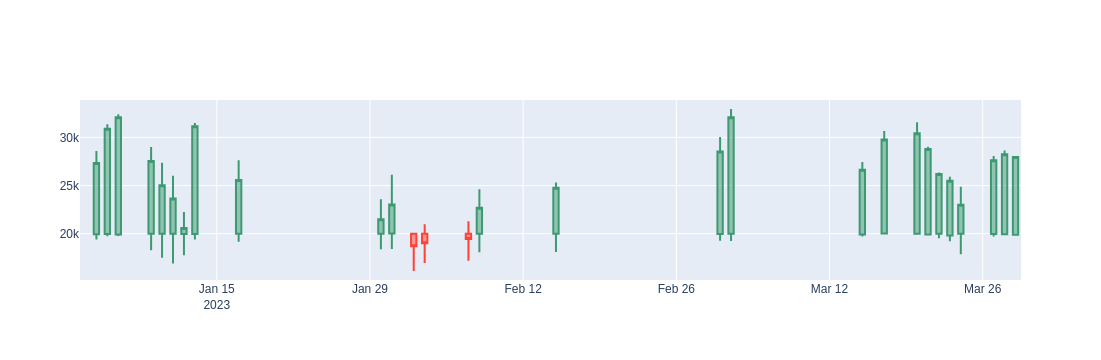

In [712]:
create_candle_stick(portfolio[ticker+[col for col in portfolio.columns if re.search(".*portfolio.*", col)]+ \
                    ["org_index","shift_index"]], date=portfolio.index[0].strftime("%Y-%m-%d"))

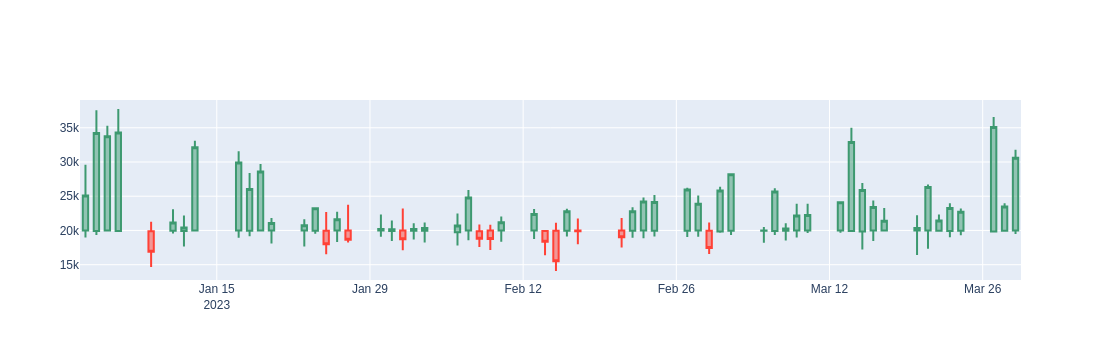

In [713]:
# create_candle_stick(portfolio_rand[ticker+[col for col in portfolio_rand.columns if re.search(".*portfolio.*", col)]], date='2024-11-07')
create_candle_stick(portfolio_rand[ticker+[col for col in portfolio_rand.columns if re.search(".*portfolio.*", col)]+ \
                    ["org_index","shift_index"]], date=portfolio_rand.index[0].strftime("%Y-%m-%d"))

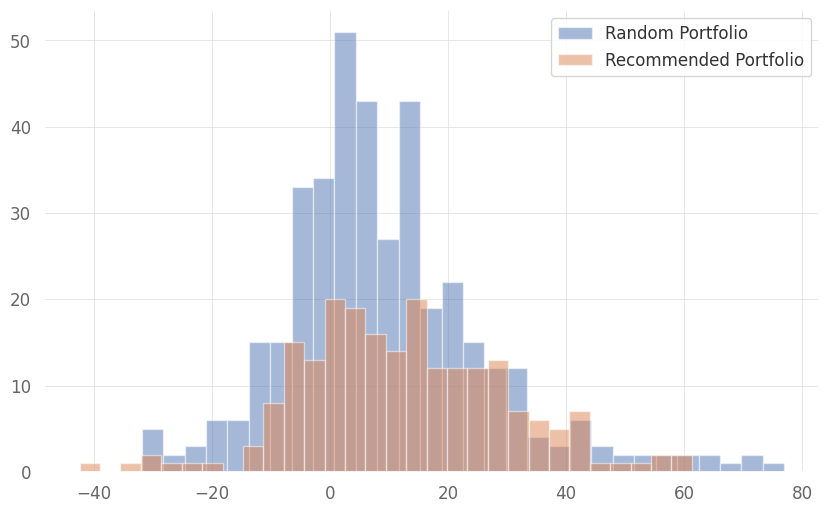

In [714]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some data
data1 = ((portfolio_rand["portfolio_curr"] - portfolio_rand["portfolio_buy"])/portfolio_rand["portfolio_buy"])*100 #np.random.normal(0, 1, 1000)
data2 = ((portfolio["portfolio_curr"] - portfolio["portfolio_buy"])/portfolio["portfolio_buy"])*100 #np.random.normal(2, 1, 1000)
# data3 = np.random.normal(-2, 1, 1000)

# Plot the histograms
plt.hist(data1, bins=30, alpha=0.5, label='Random Portfolio')
plt.hist(data2, bins=30, alpha=0.5, label='Recommended Portfolio')
# plt.hist(data3, bins=30, alpha=0.5, label='Data 3')

plt.legend()
plt.show()

In [578]:
(((portfolio_rand["portfolio_curr"] - portfolio_rand["portfolio_buy"])/portfolio_rand["portfolio_buy"])*100 ).mean()

20.7523661767077

In [579]:
(((portfolio["portfolio_curr"] - portfolio["portfolio_buy"])/portfolio["portfolio_buy"])*100 ).mean()

27.84245884061421

In [580]:
# portfolio.to_csv("result_portfolio.csv")
# portfolio.to_csv("result_portfolio_rand.csv")

In [716]:
portfolio

,NVDA,AAPL,MSFT,AMZN,GOOGL,GOOG,META,TSLA,AVGO,COST,...,MRNA_min,MRNA_max,DLTR_min,DLTR_max,WBA_min,WBA_max,portfolio_max,portfolio_min,portfolio_buy,portfolio_curr
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-03,14.305580,123.768456,236.183533,85.820000,88.899872,89.480255,124.365547,108.099998,53.540188,437.316437,...,135.660004,197.020004,135.460007,157.020004,29.106928,33.507141,NaN,NaN,NaN,NaN
2023-01-04,14.739295,125.045036,225.852097,85.139999,87.862434,88.492676,126.987663,113.639999,54.194103,440.480896,...,135.660004,197.020004,135.460007,157.020004,29.106928,33.507141,28593.326469,19384.670536,19939.179153,27342.462315
2023-01-05,14.255614,123.718979,219.158356,83.120003,85.987083,86.557426,126.558952,110.339996,53.689156,434.335327,...,135.660004,197.020004,135.460007,157.020004,29.106928,33.507141,31360.301192,19722.274354,19961.706800,30904.272795
2023-01-06,14.849224,128.271103,221.741211,86.080002,87.124260,87.944031,129.629700,113.059998,56.921032,465.864349,...,135.660004,197.020004,135.460007,157.020004,29.106928,33.507141,32406.714133,19758.116341,19906.546120,32104.109078
2023-01-09,15.617718,128.795593,223.900162,87.360001,87.802582,88.582466,129.081345,119.769997,55.804722,461.889465,...,135.660004,197.020004,135.460007,157.020004,29.106928,33.507141,28996.028625,18269.773270,19978.863052,27555.398651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-11,145.259995,224.229996,418.010010,206.839996,180.350006,181.970001,583.169983,350.000000,178.910004,932.880005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19928.339647,NaN
2024-11-12,148.289993,224.229996,423.029999,208.910004,181.619995,183.320007,584.820007,328.489990,176.220001,932.380005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19903.289836,NaN
2024-11-13,146.270004,225.119995,425.200012,214.100006,178.880005,180.490005,580.000000,330.239990,173.580002,933.729980,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19995.299902,NaN
